# DAILY GLOBAL HISTORICAL CLIMATOLOGY NETWORK (GHCN-DAILY) 

Version 3.24

[Andreas Loukas](https://andreasloukas.wordpress.com/), [EPFL LTS2](https://lts2.epfl.ch/), [Michaël Defferrard](http://deff.ch)

Menne, M.J., I. Durre, B. Korzeniewski, S. McNeal, K. Thomas, X. Yin, S. Anthony, R. Ray, 
R.S. Vose, B.E.Gleason, and T.G. Houston, 2012: Global Historical Climatology Network - 
Daily (GHCN-Daily), Version 3. 

The five core features are:

* PRCP = Precipitation (tenths of mm)
* SNOW = Snowfall (mm)
* SNWD = Snow depth (mm)
* TMAX = Maximum temperature (tenths of degrees C)
* TMIN = Minimum temperature (tenths of degrees C)

The other features are:

* ACMC = Average cloudiness midnight to midnight from 30-second ceilometer data (percent)
* ACMH = Average cloudiness midnight to midnight from manual observations (percent)
* ACSC = Average cloudiness sunrise to sunset from 30-second ceilometer data (percent)
* ACSH = Average cloudiness sunrise to sunset from manual observations (percent)
* AWDR = Average daily wind direction (degrees)
* AWND = Average daily wind speed (tenths of meters per second)
* DAEV = Number of days included in the multiday evaporation total (MDEV)
* DAPR = Number of days included in the multiday precipiation total (MDPR)
* DASF = Number of days included in the multiday snowfall total (MDSF)		  
* DATN = Number of days included in the multiday minimum temperature (MDTN)
* DATX = Number of days included in the multiday maximum temperature (MDTX)
* DAWM = Number of days included in the multiday wind movement (MDWM)
* DWPR = Number of days with non-zero precipitation included in multiday precipitation total (MDPR)
* EVAP = Evaporation of water from evaporation pan (tenths of mm)
* FMTM = Time of fastest mile or fastest 1-minute wind (hours and minutes, i.e., HHMM)
* FRGB = Base of frozen ground layer (cm)
* FRGT = Top of frozen ground layer (cm)
* FRTH = Thickness of frozen ground layer (cm)
* GAHT = Difference between river and gauge height (cm)
* MDEV = Multiday evaporation total (tenths of mm; use with DAEV)
* MDPR = Multiday precipitation total (tenths of mm; use with DAPR and DWPR, if available)
* MDSF = Multiday snowfall total 
* MDTN = Multiday minimum temperature (tenths of degrees C; use with DATN)
* MDTX = Multiday maximum temperature (tenths of degress C; use with DATX)
* MDWM = Multiday wind movement (km)
* MNPN = Daily minimum temperature of water in an evaporation pan (tenths of degrees C)
* MXPN = Daily maximum temperature of water in an evaporation pan (tenths of degrees C)
* PGTM = Peak gust time (hours and minutes, i.e., HHMM)
* PSUN = Daily percent of possible sunshine (percent)
* SN*# = Minimum soil temperature (tenths of degrees C) where * corresponds to a code for ground cover and # corresponds to a code for soil depth. For ground cover and depth codes see [readme](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt)
* SX*# = Maximum soil temperature (tenths of degrees C)  where * corresponds to a code for ground cover  and # corresponds to a code for soil depth.  See SN*# for ground cover and depth codes. 
* TAVG = Average temperature (tenths of degrees C) [Note that TAVG from source 'S' corresponds to an average for the period ending at 2400 UTC rather than local midnight]
* THIC = Thickness of ice on water (tenths of mm)	
* TOBS = Temperature at the time of observation (tenths of degrees C)
* TSUN = Daily total sunshine (minutes)
* WDF1 = Direction of fastest 1-minute wind (degrees)
* WDF2 = Direction of fastest 2-minute wind (degrees)
* WDF5 = Direction of fastest 5-second wind (degrees)
* WDFG = Direction of peak wind gust (degrees)
* WDFI = Direction of highest instantaneous wind (degrees)
* WDFM = Fastest mile wind direction (degrees)
* WDMV = 24-hour wind movement (km)	   
* WESD = Water equivalent of snow on the ground (tenths of mm)
* WESF = Water equivalent of snowfall (tenths of mm)
* WSF1 = Fastest 1-minute wind speed (tenths of meters per second)
* WSF2 = Fastest 2-minute wind speed (tenths of meters per second)
* WSF5 = Fastest 5-second wind speed (tenths of meters per second)
* WSFG = Peak gust wind speed (tenths of meters per second)
* WSFI = Highest instantaneous wind speed (tenths of meters per second)
* WSFM = Fastest mile wind speed (tenths of meters per second)
* WT** = Weather Type. For numeric codes ** see [readme](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt)
* WV** = Weather in the Vicinity. For numeric codes ** see [readme](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt)

[FTP link](ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd

from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import cartopy.crs as ccrs

In [3]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

In [4]:
import numpy as np
from scipy import sparse

def regression_tikhonov(G, y, M, tau=0):
    r"""Solve a regression problem on graph via Tikhonov minimization.
    The function solves
    .. math:: \operatorname*{arg min}_x \| M x - y \|_2^2 + \tau \ x^T L x
    if :math:`\tau > 0`, and
    .. math:: \operatorname*{arg min}_x x^T L x \ \text{ s. t. } \ y = M x
    otherwise.
    Parameters
    ----------
    G : :class:`pygsp.graphs.Graph`
    y : array, length G.n_vertices
        Measurements.
    M : array of boolean, length G.n_vertices
        Masking vector.
    tau : float
        Regularization parameter.
    Returns
    -------
    x : array, length G.n_vertices
        Recovered values :math:`x`.
    Examples
    --------
    >>> from pygsp import graphs, filters, learning
    >>> import matplotlib.pyplot as plt
    >>>
    >>> G = graphs.Sensor(N=100, seed=42)
    >>> G.estimate_lmax()
    Create a smooth ground truth signal:
    >>> filt = lambda x: 1 / (1 + 10*x)
    >>> filt = filters.Filter(G, filt)
    >>> rs = np.random.RandomState(42)
    >>> signal = filt.analyze(rs.normal(size=G.n_vertices))
    Construct a measurement signal from a binary mask:
    >>> mask = rs.uniform(0, 1, G.n_vertices) > 0.5
    >>> measures = signal.copy()
    >>> measures[~mask] = np.nan
    Solve the regression problem by reconstructing the signal:
    >>> recovery = learning.regression_tikhonov(G, measures, mask, tau=0)
    Plot the results:
    >>> fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(10, 3))
    >>> limits = [signal.min(), signal.max()]
    >>> _ = G.plot_signal(signal, ax=ax1, limits=limits, title='Ground truth')
    >>> _ = G.plot_signal(measures, ax=ax2, limits=limits, title='Measures')
    >>> _ = G.plot_signal(recovery, ax=ax3, limits=limits, title='Recovery')
    >>> _ = fig.tight_layout()
    """

    if tau > 0:

        y[M == False] = 0

        if sparse.issparse(G.L):

            def Op(x):
                return (M * x.T).T + tau * (G.L.dot(x))

            LinearOp = sparse.linalg.LinearOperator([G.N, G.N], Op)

            if y.ndim > 1:
                sol = np.empty(shape=y.shape)
                res = np.empty(shape=y.shape[1])
                for i in range(y.shape[1]):
                    sol[:, i], res[i] = sparse.linalg.cg(
                        LinearOp, y[:, i])
            else:
                sol, res = sparse.linalg.cg(LinearOp, y)

            # TODO: do something with the residual...
            return sol

        else:

            # Creating this matrix may be problematic in term of memory.
            # Consider using an operator instead...
            if type(G.L).__module__ == np.__name__:
                LinearOp = np.diag(M*1) + tau * G.L
            return np.linalg.solve(LinearOp, M * y)

    else:

        if np.prod(M.shape) != G.n_vertices:
            raise ValueError("M should be of size [G.n_vertices,]")

        indl = M
        indu = (M == False)

        Luu = G.L[indu, :][:, indu]
        Wul = - G.L[indu, :][:, indl]

        if sparse.issparse(G.L):
            sol_part = sparse.linalg.spsolve(Luu, Wul.dot(y[indl]))
        else:
            sol_part = np.linalg.solve(Luu, np.matmul(Wul, y[indl]))

        sol = y.copy()
        sol[indu] = sol_part

        return sol

In [5]:
datapath = "/mnt/nas/LTS2/datasets/ghcn-daily/processed/"
rawpath = "/mnt/nas/LTS2/datasets/ghcn-daily/raw/"
newdatapath = "./data/ghcn-daily/processed/"

In [6]:
years = np.arange(2010,2015)
years2 = np.arange(2010,2018)

feature_names = ['PRCP', 'TMIN', 'TMAX', 'SNOW']
n_features = len(feature_names)
n_years  = len(years)

## Station

In [7]:
filename = 'stations_{:4d}-{:4d}.npz'.format(years[0], years[-1])

# only recompute if necessary
if not os.path.isfile(datapath+filename):
    print('Problem occured')
    raise ValueError()
    
    # Variable   Columns   Type
    # ID            1-11   Character
    # LATITUDE     13-20   Real
    # LONGITUDE    22-30   Real
    # ELEVATION    32-37   Real
    # STATE        39-40   Character
    # NAME         42-71   Character
    # GSN FLAG     73-75   Character
    # HCN/CRN FLAG 77-79   Character
    # WMO ID       81-85   Character

    id_ghcn, lat, lon, elev, name = [], [], [], [], []
    with open('raw/ghcnd-stations.txt', 'r') as f:
        for line in f:

            iid, ilat, ilon, ielev, iname = line[0:11], line[12:20], line[21:30], line[31:37], line[41:71]         
            # state, GSN_flag, HCNCRN_flag, WMO_id = line[38:40], line[72:75], line[76:79], line[80:85] 

            assert (not iid.isspace()) and (not ilat.isspace()) and (not ilon.isspace()) \
                and (not ielev.isspace()) and (not iname.isspace())

            id_ghcn.append(iid.strip())
            lat.append(float(ilat.strip()))
            lon.append(float(ilon.strip()))
            elev.append(float(ielev.strip()))
            name.append(iname.strip())

    id_ghcn, lat, lon, elev, name = np.array(id_ghcn), np.array(lat), np.array(lon), np.array(elev), np.array(name)

    # Identify *relevant* stations: These are stations giving measurements in the years of interest
    # that also have known coordinates.

    # first, construct the set of all ghcn identifiers encountered in daily
    id_ghcn_relevant = set([])

    for yearIdx,year in enumerate(years):

        filename2 = 'raw/{:4}.csv.gz'.format(year)
        print('- pre-parsing : {}'.format(filename2))

        df = pd.read_csv(filename2, names=['id_ghcn', 'date', 'type', 'value', '?0', '?1', '?2', '?3'], \
                         nrows=None, usecols=[0,1,2,3])


        id_ghcn_relevant |= set(df["id_ghcn"].values)

    # second, find identifiers both in id_ghcn and id_ghcn_relevant
    id_ghcn_relevant = set(id_ghcn) & id_ghcn_relevant

    # third, keep only relevant station data 
    keep = [id in id_ghcn_relevant for id in id_ghcn] 
    id_ghcn, lat, lon, elev, name = id_ghcn[keep], lat[keep], lon[keep], elev[keep], name[keep] 

    # free up some memory
    del id_ghcn_relevant, keep

    np.savez_compressed(filename, id_ghcn=id_ghcn, lat=lat, lon=lon, elev=elev, name=name, years=years)
    
else:
    station_file = np.load(datapath+filename)
    id_ghcn, lat, lon, elev, name = station_file['id_ghcn'], station_file['lat'], station_file['lon'], station_file['elev'], station_file['name']
    del station_file
    
n_stations = id_ghcn.shape[0]
print('{} weather stations identified.'.format(n_stations))

#  a dictionary mapping GHCN ids to local ids (rows in id array) 
ghcn_to_local = dict(zip(id_ghcn, np.arange(n_stations)))

50469 weather stations identified.


## Data

In [8]:
feature_names = ['PRCP', 'TMIN', 'TMAX', 'SNOW', 'SNWD', 'WT']
# max stations, 50'469
# in 2010, in nbr stations [36k, 16k, 16k, 6k, 22k, 20k, 0, 0, 28, 1k, 6, 5k, 0]
# in 2011, in nbr stations [36k, 16k, 16k, 6k, 22k, 18k, 0, 0, 38, 1k, 22, 5k, 0]
# in 2014, in nbr stations [39k, 15k, 15k, 6k, 24k, 19k, 0, 0, 40, 1k, 49, 4k, 0]

filenames = []
datas = []
valid_days_list = []
n_stations_list = []
for feature_name in feature_names:
    filenames.append('data_{:4d}-{:4d}_{}.npz'.format(years[0], years[-1], feature_name))
    print(f'- Checking if file {filenames[-1]} exists..')

    # only recompute if necessary
    if not os.path.isfile(newdatapath+filenames[-1]):

        print('- The file is not there. Parsing everything from raw. This will take a while.')
        os.makedirs(newdatapath, exist_ok=True)
        # Load the station measurements into a year-list of dataframes
        df_years = []

        for yearIdx,year in enumerate(years):

            filename_year = rawpath+'{:4}.csv.gz'.format(year)
            print(' - parsing *{}*'.format(filename_year))

            df = pd.read_csv(filename_year, names=['id_ghcn', 'date', 'type', 'value', 'MF', 'qualityF', 'source', '?0'], \
                             nrows=None, usecols=[0,1,2,3,5])

            # create a new column with the id_local
            id_local = [ghcn_to_local.get(id_g) for id_g in df["id_ghcn"].values]
            id_local = [-1 if v is None else v for v in id_local]
            id_local = np.array(id_local).astype(np.int)

            df = df.assign(id_local=pd.Series(id_local, index=df.index).values)

            # remove measurement of stations with unknown id_local
            df = df[df.id_local != -1] 
            
            # replace measurements with bad quality flag
            #df.value[~df.qualityF.isna()] = np.nan
            df = df[df.qualityF.isna()]
            df = df.drop('qualityF', axis=1)
            
            df_years.append(df)

        del df, id_local
        print('done!')

        # Construct one array per feature and save it to disk

        # indicate for which days we have measurements (this also deals with months of different lengths)
        valid_days = np.zeros((n_years, 12, 31), dtype=np.bool)

        for _, name in enumerate(feature_names):

            print(f' - Looking at {name}')

            data = np.zeros((n_stations, n_years, 12, 31), dtype=np.float) * np.nan

            for yearIdx,year in enumerate(years):

                df = df_years[yearIdx]
                idf = df.loc[df.type.str.contains(name)]

                print(f'  - year {year}')

                # remove measurement of stations with unknown id_local
                idf = idf[idf.id_local != -1] 

                for monthIdx,month in enumerate(range(1,12+1)): 
                    for dayIdx,day in enumerate(range(1,31+1)):        

                        date = int('{:4d}{:02d}{:02d}'.format(year,month,day))
                        jdf = idf.loc[idf['date'] == date]

                        # sort data according to the id_local 
                        jdf.set_index('id_local', inplace=True)
                        jdf = jdf.sort_index()

                        index = jdf.index.values
                        if name is 'WT' or name is 'WV':
                            values = jdf.type.str.extract(r'(\d+)').values.astype(int)
                            values = values[:,0]
                        else:
                            values = jdf['value'].values.astype(np.float)

                        if len(index) != 0: 
                            data[index,yearIdx,monthIdx,dayIdx] = values
                            valid_days[yearIdx,monthIdx,dayIdx] = True

            print('  - saving to disk')
            np.savez_compressed(newdatapath+'data_{:4d}-{:4d}_{}.npz'.format(years[0], years[-1], name), data=data, valid_days=valid_days)

            del index, values, df, idf, jdf    

    else:    
        print('- Loading data from disk..')

        data_file = np.load(newdatapath+filenames[-1])
        data, valid_days = data_file['data'], data_file['valid_days']        
        n_stations = data.shape[0]
        print(f'- {n_stations} stations loaded.')
        data = data.reshape((n_stations, n_years*12*31))
        if feature_name == 'TMIN' or feature_name == 'TMAX' or feature_name == 'PRCP':
            data = data.astype(np.float)
            data /= 10
        datas.append(data)
        valid_days = np.squeeze(valid_days.reshape(n_years*12*31)).astype(np.bool)
        valid_days_list.append(valid_days)
        n_stations_list.append(n_stations)

- Checking if file data_2010-2014_PRCP.npz exists..
- Loading data from disk..
- 50469 stations loaded.
- Checking if file data_2010-2014_TMIN.npz exists..
- Loading data from disk..
- 50469 stations loaded.
- Checking if file data_2010-2014_TMAX.npz exists..
- Loading data from disk..
- 50469 stations loaded.
- Checking if file data_2010-2014_SNOW.npz exists..
- Loading data from disk..
- 50469 stations loaded.
- Checking if file data_2010-2014_SNWD.npz exists..
- Loading data from disk..
- 50469 stations loaded.
- Checking if file data_2010-2014_WT.npz exists..
- Loading data from disk..
- 50469 stations loaded.


In [ ]:
# #feature_name = 'TMAX'
# # feature_names
# filenames = []
# datas_old = []
# valid_days_list = []
# n_stations_list = []
# for feature_name in feature_names[:4]:
#     filenames.append('data_{:4d}-{:4d}_{}.npz'.format(years[0], years[-1], feature_name))
#     print(f'- Checking if file {filenames[-1]} exists..')

#     # only recompute if necessary
#     if not os.path.isfile(datapath+filenames[-1]):

#         print('- The file is not there. Parsing everything from raw. This will take a while.')
#         # Load the station measurements into a year-list of dataframes
#         df_years = []

#         for yearIdx,year in enumerate(years):

#             filename_year = rawpath+'{:4}.csv.gz'.format(year)
#             print(' - parsing *{}*'.format(filename_year))

#             df = pd.read_csv(filename_year, names=['id_ghcn', 'date', 'type', 'value', '?0', '?1', '?2', '?3'], \
#                              nrows=None, usecols=[0,1,2,3])

#             # create a new column with the id_local
#             id_local = [ghcn_to_local.get(id_g) for id_g in df["id_ghcn"].values]
#             id_local = [-1 if v is None else v for v in id_local]
#             id_local = np.array(id_local).astype(np.int)

#             df = df.assign(id_local=pd.Series(id_local, index=df.index).values)

#             # remove measurement of stations with unknown id_local
#             df = df[df.id_local != -1] 

#             df_years.append(df)

#         del df, id_local
#         print('done!')

#         # Construct one array per feature and save it to disk

#         # indicate for which days we have measurements (this also deals with months of different lengths)
#         valid_days = np.zeros((n_years, 12, 31), dtype=np.bool)

#         for _, name in enumerate(feature_names):

#             print(f' - Looking at {name}')

#             data = np.zeros((n_stations, n_years, 12, 31), dtype=np.float) * np.nan

#             for yearIdx,year in enumerate(years):

#                 df = df_years[yearIdx]
#                 idf = df.loc[df['type'] == name]

#                 print(f'  - year {year}')

#                 # remove measurement of stations with unknown id_local
#                 idf = idf[idf.id_local != -1] 

#                 for monthIdx,month in enumerate(range(1,12+1)): 
#                     for dayIdx,day in enumerate(range(1,31+1)):        

#                         date = int('{:4d}{:02d}{:02d}'.format(year,month,day))
#                         jdf = idf.loc[idf['date'] == date]

#                         # sort data according to the id_local 
#                         jdf.set_index('id_local', inplace=True)
#                         jdf = jdf.sort_index()

#                         index = jdf.index.values
#                         values = jdf['value'].values.astype(np.float)

#                         if len(index) != 0: 
#                             data[index,yearIdx,monthIdx,dayIdx] = values
#                             valid_days[yearIdx,monthIdx,dayIdx] = True

#             print('  - saving to disk')
#             np.savez_compressed('processed/data_{:4d}-{:4d}_{}.npz'.format(years[0], years[-1], name), data=data, valid_days=valid_days)

#             del index, values, df, idf, jdf    

#     else:    
#         print('- Loading data from disk..')

#         data_file = np.load(datapath+filenames[-1])
#         data, valid_days = data_file['data'], data_file['valid_days']        
#         n_stations = data.shape[0]
#         print(f'- {n_stations} stations loaded.')
#         data = data.reshape((n_stations, n_years*12*31))
#         if feature_name == 'TMIN' or feature_name == 'TMAX' or feature_name == 'PRCP':
#             data = data.astype(np.float)
#             data /= 10
#         datas_old.append(data)
#         valid_days = np.squeeze(valid_days.reshape(n_years*12*31)).astype(np.bool)
#         valid_days_list.append(valid_days)
#         n_stations_list.append(n_stations)

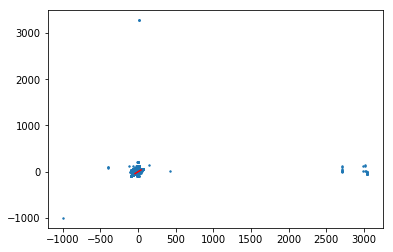

In [24]:
plt.scatter(datas_old[1][:,valid_days], datas_old[2][:,valid_days], s=2)
plt.plot(range(-50, 51), range(-50, 51), 'r')

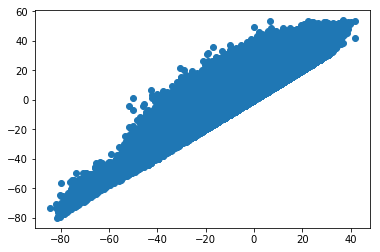

In [26]:
plt.scatter(datas[1][:,valid_days], datas[2][:,valid_days])

In [9]:
assert n_stations_list[0] == n_stations_list[1] == n_stations_list[2] == n_stations_list[3]

In [10]:
assert np.all(valid_days_list[0] == valid_days_list[0])
assert np.all(valid_days_list[0] == valid_days_list[1])
assert np.all(valid_days_list[0] == valid_days_list[2])
assert np.all(valid_days_list[0] == valid_days_list[3])
assert np.all(valid_days_list[0] == valid_days_list[4])
assert np.all(valid_days_list[0] == valid_days_list[5])
# assert np.all(valid_days_list[0] == valid_days_list[6])

In [11]:
full_data = np.stack(datas, axis=2)

In [12]:
full_data = full_data[:, valid_days_list[0], :]

n_days = full_data.shape[1]

assert n_stations == full_data.shape[0]

print(f'n_stations: {n_stations}, n_days: {n_days}')

n_stations: 50469, n_days: 1826


In [13]:
np.all(np.isnan(datas[0]).all(axis=(1)) == np.isnan(datas[1]).all(axis=(1)))

False

In [14]:
from pygsp import utils
from pygsp.graphs import Graph
from pygsp.graphs import NNGraph
class sphereGraph(NNGraph):
    def __init__(self, phi, theta, neighbors, rad=True, epsilon=True, **kwargs):
        if not rad:
            theta, phi = np.deg2rad(theta), np.deg2rad(phi)
        theta -= np.pi/2
        ct = np.cos(theta).flatten()
        st = np.sin(theta).flatten()
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        self.coords = np.vstack([x, y, z]).T
        NNtype = 'radius' if epsilon else 'knn'
        plotting = {"limits": np.array([-1, 1, -1, 1, -1, 1])*0.5}
        self.n_vertices = len(self.coords)
        super(sphereGraph, self).__init__(self.coords, k=neighbors, NNtype=NNtype, center=False, rescale=False,
                                     plotting=plotting, **kwargs)

In [27]:
g_full = sphereGraph(lon, lat, 2, rad=False, epsilon=False)

2019-05-20 14:43:51,198:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


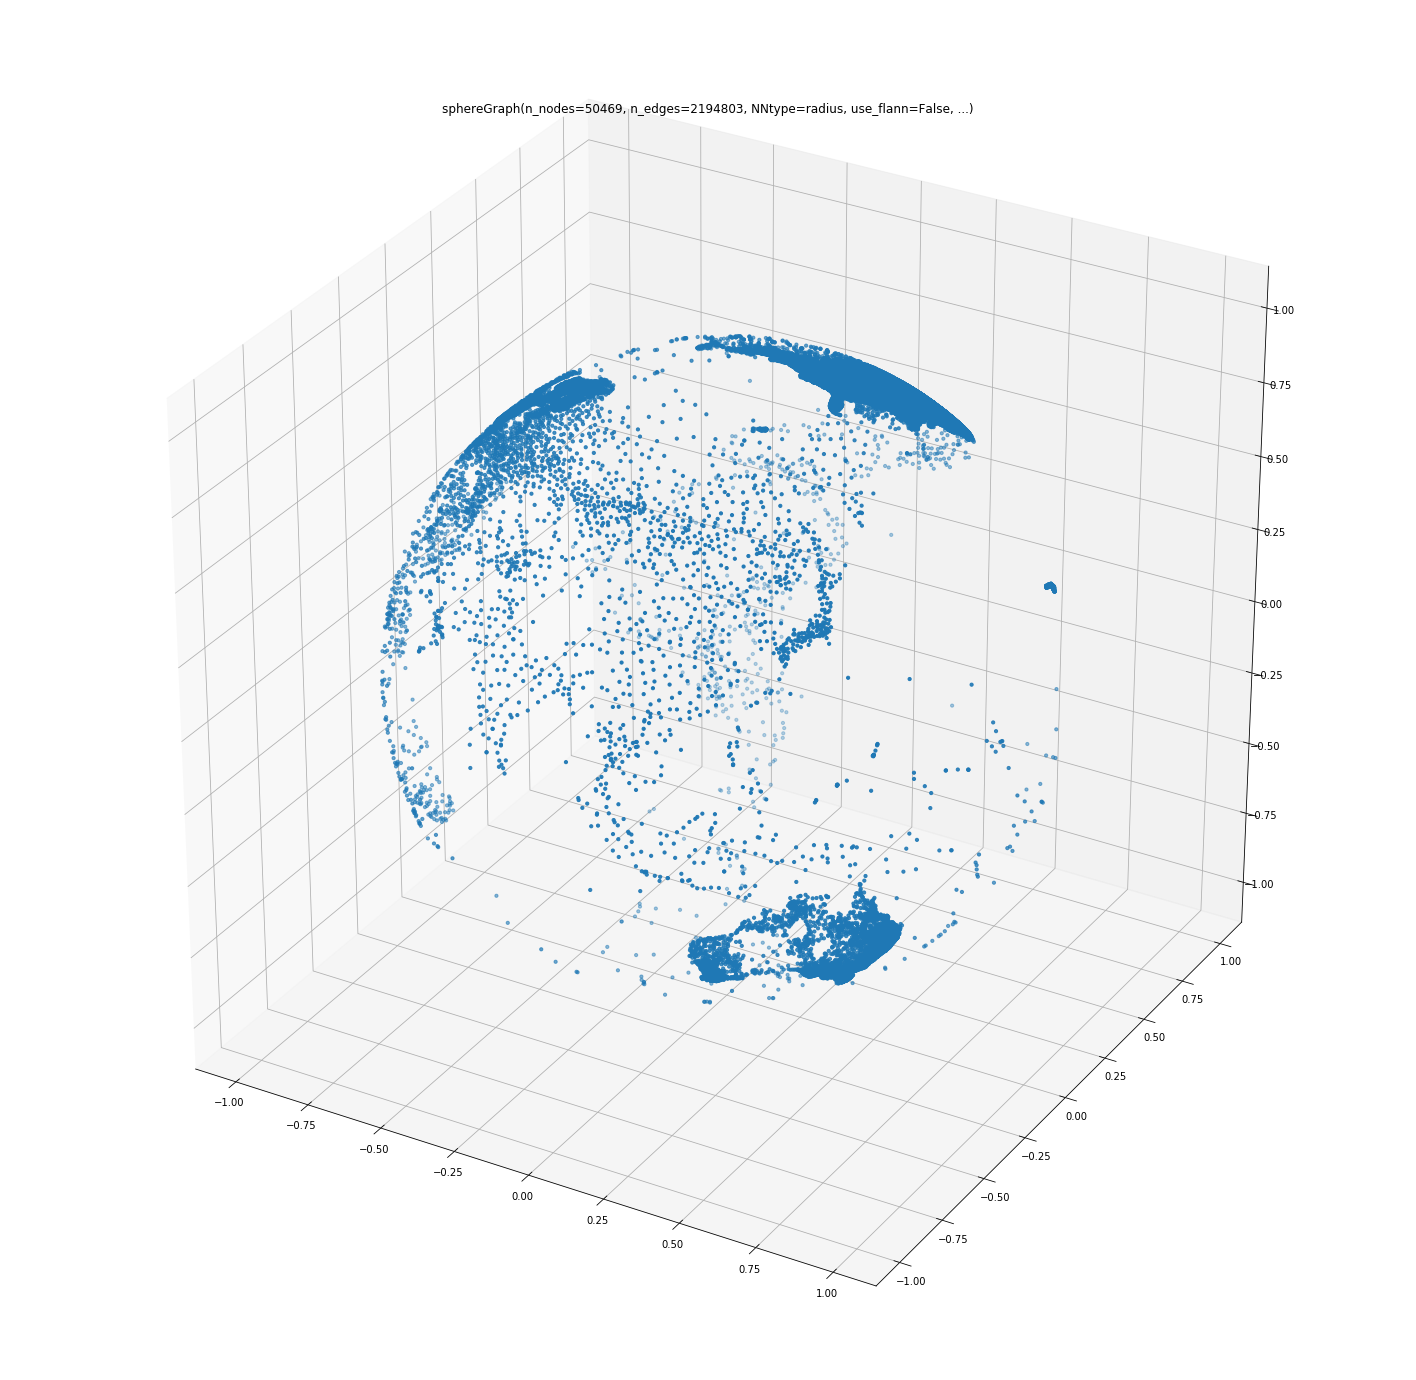

In [16]:
fig = plt.figure(figsize=(25,25))
axes = fig.add_subplot(111, projection='3d')
g_full.plot(vertex_size=10, edges=False, ax=axes)

In [19]:
g_full.compute_laplacian("normalized")
g_full.compute_fourier_basis(recompute=True, n_eigenvectors=500)
g_full.set_coordinates(g_full.U[:,1:4])
g_full.plot(vertex_size=10)

In [ ]:
plt.plot(g_full.e[:16], 'o')

## inference train

Temperature MAX from Temperature MIN

In [15]:
dataset = full_data.transpose((1, 0, 2))
keepToo = ~np.isnan(dataset[:,:,1:3]).any(axis=0)
keepSuper = ((~np.isnan(dataset[:,:,:3])).sum(axis=0)>0.75*dataset.shape[0])
keepToo = keepToo.all(axis=1)
keepSuper = keepSuper.all(axis=1)
dataset_temp = dataset[:, keepToo, 1:3]

# remove outliers (remove outiler stations) (other option is to replace value by mean of knn)
# out = np.where((dataset_temp<-60) + (dataset_temp>80))
# dataset_temp = np.delete(dataset_temp, np.unique(out[1]), axis=1)
# keepToo[np.argwhere(keepToo)[np.unique(out[1])]] = False

# out = np.where(dataset_temp[:,:,1]==60)
# dataset_temp = np.delete(dataset_temp, np.unique(out[1]), axis=1)
# keepToo[np.argwhere(keepToo)[np.unique(out[1])]] = False

# out = np.where((dataset_temp[:,:,0]==-35.6)*(dataset_temp[:,:,1]>0))
# dataset_temp = np.delete(dataset_temp, np.unique(out[1]), axis=1)
# keepToo[np.argwhere(keepToo)[np.unique(out[1])]] = False

print("number of stations in min set: {}\nnumber of stations in super set: {}".format(keepToo.sum(), keepSuper.sum()))

number of stations in min set: 1573
number of stations in super set: 9728


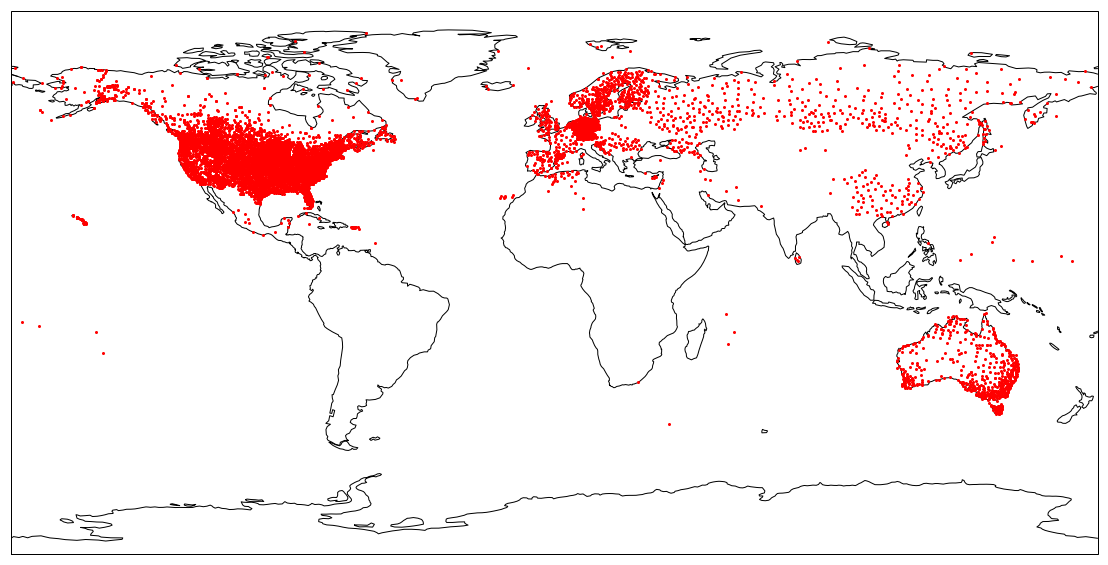

In [25]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.plot(lon[keepSuper], lat[keepSuper], 'or', marker='o', markerfacecolor='r', markersize=2)

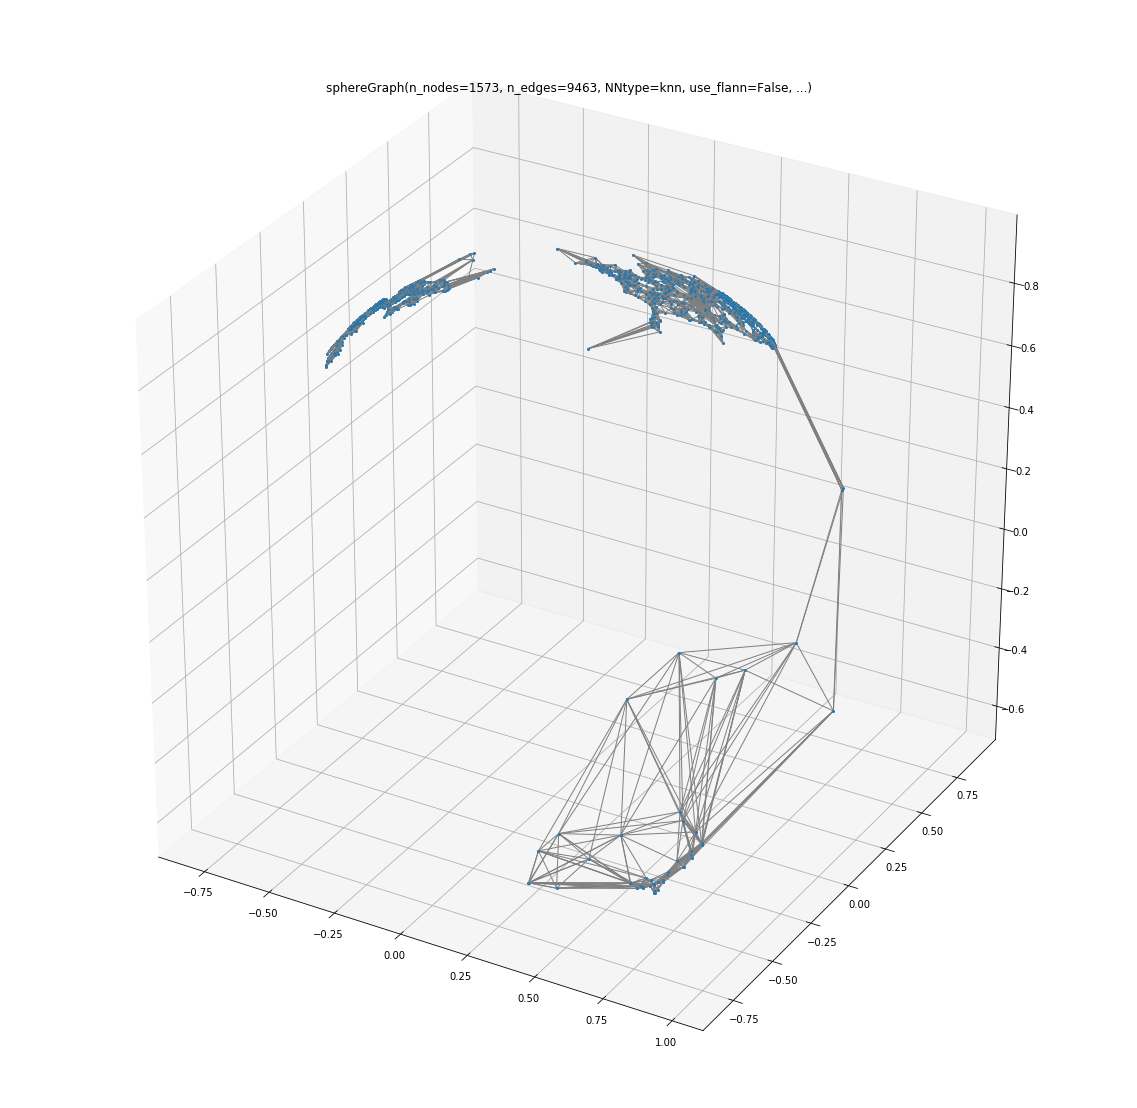

In [17]:
neighbour = 10
fig2 = plt.figure(figsize=(20,20))
axes = fig2.add_subplot(111, projection='3d')
gTemp = sphereGraph(lon[keepToo], lat[keepToo], neighbour, rad=False, epsilon=False)
gTemp.plot(vertex_size=10, edges=True, ax=axes)
gTemp.compute_laplacian("normalized")

In [18]:
## temp max from temp min

ratio = 0.7
n_days = dataset_temp.shape[0]
limit= int(ratio*n_days)

mean = dataset_temp.mean(axis=(0,1))[0]
std = dataset_temp.std(axis=(0,1))[0]

x_train = (dataset_temp[:limit,:,0] - mean) / std
labels_train = dataset_temp[:limit,:,1]
x_val = (dataset_temp[limit:,:,0] - mean) / std
labels_val = dataset_temp[limit:,:,1]


training = LabeledDataset(x_train, labels_train)
validation = LabeledDataset(x_val, labels_val)

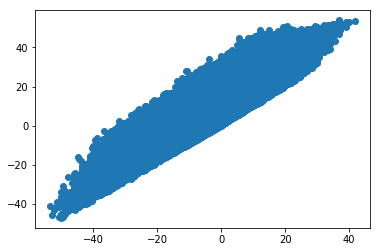

In [19]:
plt.scatter(dataset_temp[:,:,0], dataset_temp[:,:,1])

In [20]:
mask = ~np.isnan(dataset[:,keepSuper,1:3])
dataset_super = dataset[:, keepSuper, 1:3] # n_days graphs of superset
gTempSuper = sphereGraph(lon[keepSuper], lat[keepSuper], 10, rad=False, epsilon=False)
gTempSuper.compute_laplacian("normalized")

2019-05-21 10:22:35,670:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [22]:
for day in range(dataset_super.shape[0]):
    for feat in range(dataset_super.shape[-1]):
        dataset_super[day,:,feat] = regression_tikhonov(gTempSuper, dataset_super[day,:,feat], mask[day,:,feat])

In [23]:
np.isnan(dataset_super).sum()

0

In [70]:
## temp max from temp min

ratio = 0.7
n_days = dataset_temp.shape[0]
limit= int(ratio*n_days)

mean = np.nanmean(dataset[:, keepSuper, 1:3], axis=(0,1))[0]
std = np.nanstd(dataset[:, keepSuper, 1:3], axis=(0,1))[0]

x_train = (dataset_super[:limit,:,0] - mean) / std
labels_train = dataset_super[:limit,:,1]
x_val = (dataset_super[limit:,:,0] - mean) / std
labels_val = dataset_super[limit:,:,1]

x_train = np.dstack([x_train, 
                     mask[:limit, :, :]])
x_val = np.dstack([x_val, 
                   mask[limit:, :, :]])


training_super = LabeledDataset(x_train, labels_train)
validation_super = LabeledDataset(x_val, labels_val)

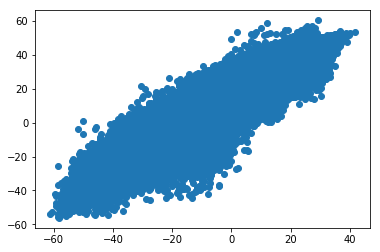

In [24]:
plt.scatter(dataset_super[:,:,0], dataset_super[:,:,1])

#### Precipirtation from temperatures (MIN, MAX)

In [23]:
dataset = full_data.transpose((1, 0, 2)).copy()
# remove outliers
### min temp is impossible
# out = np.where(dataset[:,:,1]>100)
# dataset[:,:,1][out] = np.nan

# ### min temp is always the same and max temp doesn't make sens
# out = np.where(dataset[:,:,1]<-60)
# dataset[:,:,1][out] = np.nan

# ### max temp is too big ofr the location and the min temp
# out = np.where(dataset[:,:,2]>60)
# dataset[:,:,2][out] = np.nan


# ## min is bigger than max
# out = np.where(dataset[:,:,1]>dataset[:,:,2])
# dataset[:,:,1:3][out] = np.nan

# ## dif between two days is bigger than 20° (what max is possible?)
# out = np.where(np.abs(np.diff(dataset[:,:,1:3], axis=0))>20)
# dataset[:,:,1:3][out] = np.nan
# dataset[:,:,1:3][out[0]+1,out[1], out[2]] = np.nan


keepToo = ~np.isnan(dataset[:,:,:3]).any(axis=0)
keepSuper = ((~np.isnan(dataset[:,:,:3])).sum(axis=0)>0.75*dataset.shape[0])
keepToo = keepToo.all(axis=1)
keepSuper = keepSuper.all(axis=1)
dataset_prec = dataset[:, keepToo, :3]

In [24]:
print("n stations minset = {}".format(keepToo.sum()))
print("n stations superset = {}".format(keepSuper.sum()))

n stations minset = 526
n stations superset = 8932


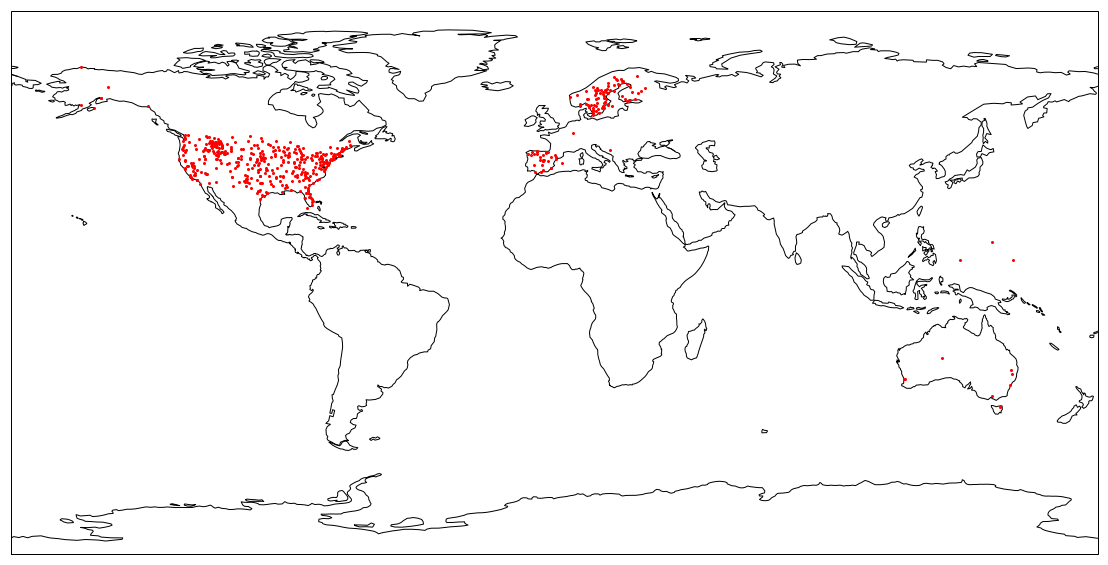

In [25]:
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.plot(lon[keepToo], lat[keepToo], 'or', marker='o', markerfacecolor='r', markersize=2)

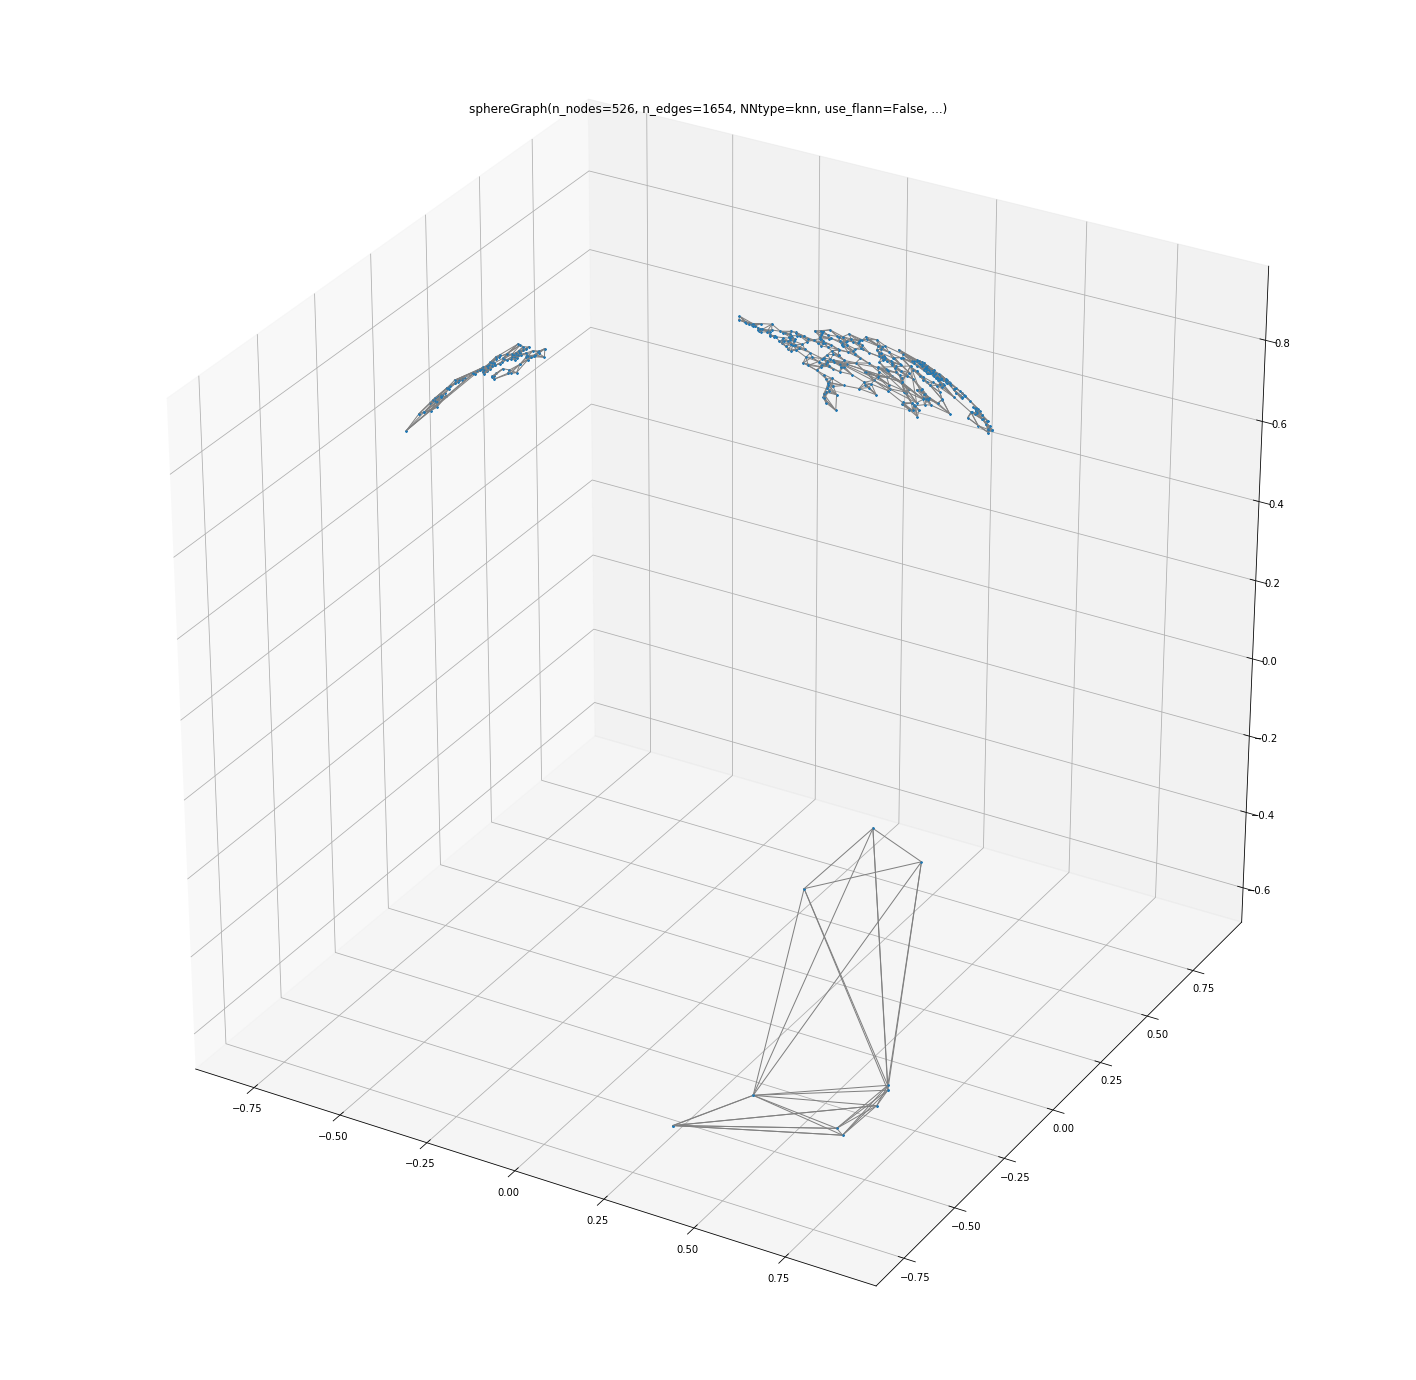

In [26]:
neighbour = 5
fig = plt.figure(figsize=(25,25))
axes = fig.add_subplot(111, projection='3d')
gPrec = sphereGraph(lon[keepToo], lat[keepToo], neighbour, rad=False, epsilon=False)
gPrec.plot(vertex_size=10, edges=True, ax=axes)
gPrec.compute_laplacian("normalized")

In [27]:
leap_years = np.zeros_like(years).astype(np.bool)
for i, in_year in enumerate(np.split(valid_days,len(years))):
    leap_years[i] = in_year.sum()==366

In [28]:
w_months = np.tile(np.repeat(np.arange(12), 31), years[-1]-years[0]+1)[valid_days]
w_days = np.tile(np.arange(365),years[-1]-years[0]+1)
for i, leap in enumerate(leap_years):
    if leap:
        w_days = np.insert(w_days, ((i+1)*365), 365)

In [29]:
## precipitation from temp

ratio = 0.7
n_days = dataset_prec.shape[0]
limit= int(ratio*n_days)

mean = dataset_prec.mean(axis=(0,1))[1:3]
std = dataset_prec.std(axis=(0,1))[1:3]
# mean_label = dataset_prec.mean(axis=(0,1))[0]
# std_label = dataset_prec.std(axis=(0,1))[0]

x_train = (dataset_prec[:limit,:,1:3] - mean) / std
labels_train = dataset_prec[:limit,:,0]
x_val = (dataset_prec[limit:,:,1:3] - mean) / std
labels_val = dataset_prec[limit:,:,0]

# location of stations
coords_v = np.stack([lon[keepToo], lat[keepToo]], axis=-1)
coords_v = (coords_v-coords_v.mean(axis=0))/coords_v.std(axis=0)
# altitude of stations
alt_v = elev[keepToo]
alt_v = (alt_v-alt_v.mean())/alt_v.std()

x_train = np.dstack([x_train, np.repeat(coords_v[np.newaxis,:], x_train.shape[0], axis=0),
                     np.repeat(alt_v[np.newaxis,:], x_train.shape[0], axis=0),
                     np.repeat(w_days[:limit, np.newaxis], x_train.shape[1], axis=1)])
x_val = np.dstack([x_val, np.repeat(coords_v[np.newaxis,:], x_val.shape[0], axis=0),
                  np.repeat(alt_v[np.newaxis,:], x_val.shape[0], axis=0),
                  np.repeat(w_days[limit:, np.newaxis], x_val.shape[1], axis=1)])

training = LabeledDataset(x_train, labels_train)
validation = LabeledDataset(x_val, labels_val)

In [130]:
mask = ~np.isnan(dataset[:,keepSuper,1:3])
dataset_super = dataset[:, keepSuper, 1:3] # n_days graphs of superset
gRegSuper = sphereGraph(lon[keepSuper], lat[keepSuper], 10, rad=False, epsilon=False)
gRegSuper.compute_laplacian("normalized")

2019-05-20 15:48:57,869:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [131]:
for day in range(dataset_super.shape[0]):
    for feat in range(dataset_super.shape[-1]):
        dataset_super[day,:,feat] = regression_tikhonov(gRegSuper, dataset_super[day,:,feat], mask[day,:,feat])

In [133]:
np.isnan(dataset_super).sum()

0

In [30]:
## precipitation from temp

ratio = 0.7
n_days = dataset_super.shape[0]
limit= int(ratio*n_days)

mean = dataset_super.mean(axis=(0,1))[1:3]
std = dataset_super.std(axis=(0,1))[1:3]
# mean_label = dataset_prec.mean(axis=(0,1))[0]
# std_label = dataset_prec.std(axis=(0,1))[0]

x_train_super = (dataset_super[:limit,:,1:3] - mean) / std
labels_train_super = dataset_super[:limit,:,0]
x_val_super = (dataset_super[limit:,:,1:3] - mean) / std
labels_val_super = dataset_super[limit:,:,0]

# location of stations
coords_v = np.stack([lon[keepSuper], lat[keepSuper]], axis=-1)
coords_v = (coords_v-coords_v.mean(axis=0))/coords_v.std(axis=0)
# altitude of stations
alt_v = elev[keepSuper]
alt_v = (alt_v-alt_v.mean())/alt_v.std()

x_train_super = np.dstack([x_train_super, np.repeat(coords_v[np.newaxis,:], x_train_super.shape[0], axis=0),
                     np.repeat(alt_v[np.newaxis,:], x_train_super.shape[0], axis=0),
                     np.repeat(w_days[:limit, np.newaxis], x_train_super.shape[1], axis=1)])
x_val_super = np.dstack([x_val_super, np.repeat(coords_v[np.newaxis,:], x_val_super.shape[0], axis=0),
                  np.repeat(alt_v[np.newaxis,:], x_val_super.shape[0], axis=0),
                  np.repeat(w_days[limit:, np.newaxis], x_val_super.shape[1], axis=1)])

training = LabeledDataset(x_train_super, labels_train_super)
validation = LabeledDataset(x_val_super, labels_val_super)

NameError: name 'dataset_super' is not defined

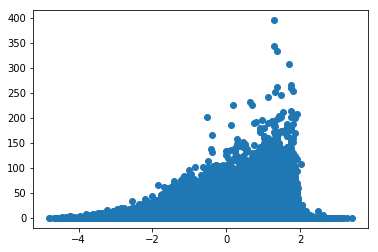

In [31]:
plt.scatter(x_train[:,:,0], labels_train)

In [32]:
plt.scatter(x_train_super[:,:,0], labels_train_super)

NameError: name 'x_train_super' is not defined

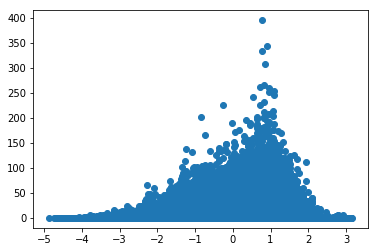

In [33]:
plt.scatter(x_train[:,:,1], labels_train)

In [ ]:
plt.scatter(x_train_super[:,:,1], labels_train_super)

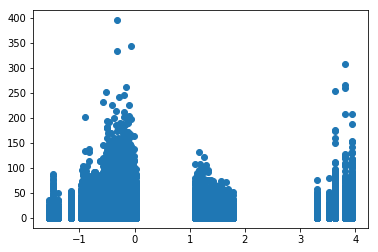

In [34]:
plt.scatter(x_train[:,:,2], labels_train)

In [ ]:
plt.scatter(x_train_super[:,:,2], labels_train_super)

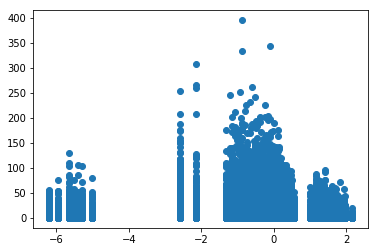

In [35]:
plt.scatter(x_train[:,:,3], labels_train)

In [ ]:
plt.scatter(x_train_super[:,:,3], labels_train_super)

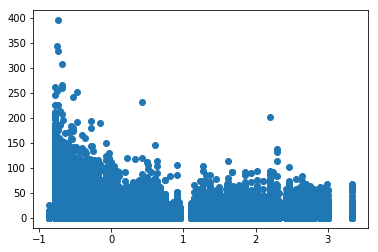

In [36]:
plt.scatter(x_train[:,:,4], labels_train)

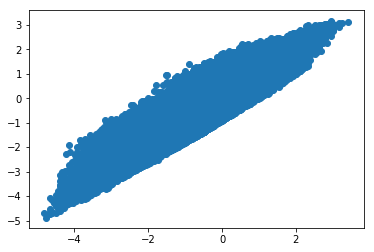

In [37]:
plt.scatter(x_train[:,:,0], x_train[:,:,1])

In [ ]:
plt.scatter(x_train_super[:,:,0], x_train_super[:,:,1])

In [38]:
time = np.empty_like(x_train[:,:,0])
time[:,:] = np.arange(time.shape[0])[:,np.newaxis]

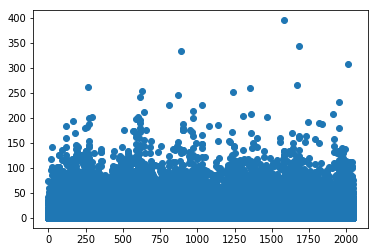

In [39]:
plt.scatter(time, labels_train)

#### future temperature to find, regression

In [40]:
dataset = full_data.transpose((1, 0, 2)).copy()
# # remove outliers
# ### min temp is impossible
# out = np.where(dataset[:,:,1]>100)
# dataset[:,:,1][out] = np.nan

# ### min temp is always the same and max temp doesn't make sens
# out = np.where(dataset[:,:,1]<-60)
# dataset[:,:,1][out] = np.nan

# ### max temp is too big ofr the location and the min temp
# out = np.where(dataset[:,:,2]>=60)
# dataset[:,:,2][out] = np.nan

# ## series of exact same values for the same location. seems strange
# out = np.where((dataset[:,:,1]==-35.6)*(dataset[:,:,2]>0))
# dataset[:,:,1][out] = np.nan

# ## min is bigger than max
# out = np.where(dataset[:,:,1]>dataset[:,:,2])
# dataset[:,:,1:3][out] = np.nan

# ## dif between two days is bigger than 20° (what max is possible)
# out = np.where(np.abs(np.diff(dataset[:,:,1:3], axis=0))>20)
# dataset[:,:,1:3][out] = np.nan
# dataset[:,:,1:3][out[0]+1,out[1], out[2]] = np.nan


keepToo = ~np.isnan(dataset[:,:,1:3]).any(axis=0)
keepSuper = ((~np.isnan(dataset[:,:,1:3])).sum(axis=0)>0.75*dataset.shape[0])
keepToo = keepToo.all(axis=1)
keepSuper = keepSuper.all(axis=1)
dataset_temp_reg = dataset[:, keepToo, 1:3]

In [41]:
print("n stations minset = {}".format(keepToo.sum()))
print("n stations superset = {}".format(keepSuper.sum()))

n stations minset = 763
n stations superset = 11025


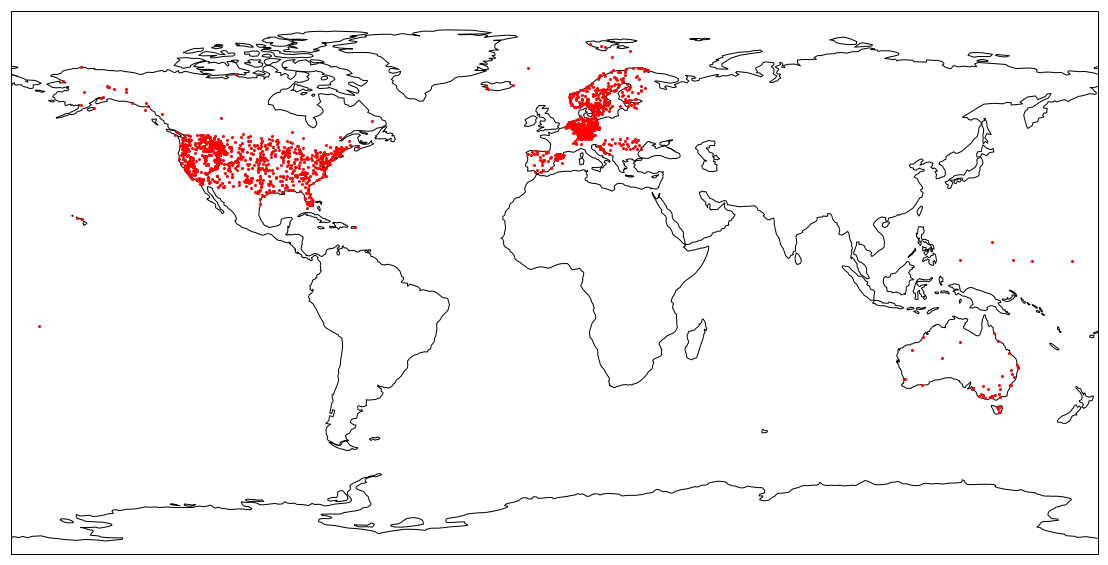

In [90]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.plot(lon[keepToo], lat[keepToo], 'or', marker='o', markerfacecolor='r', markersize=2)

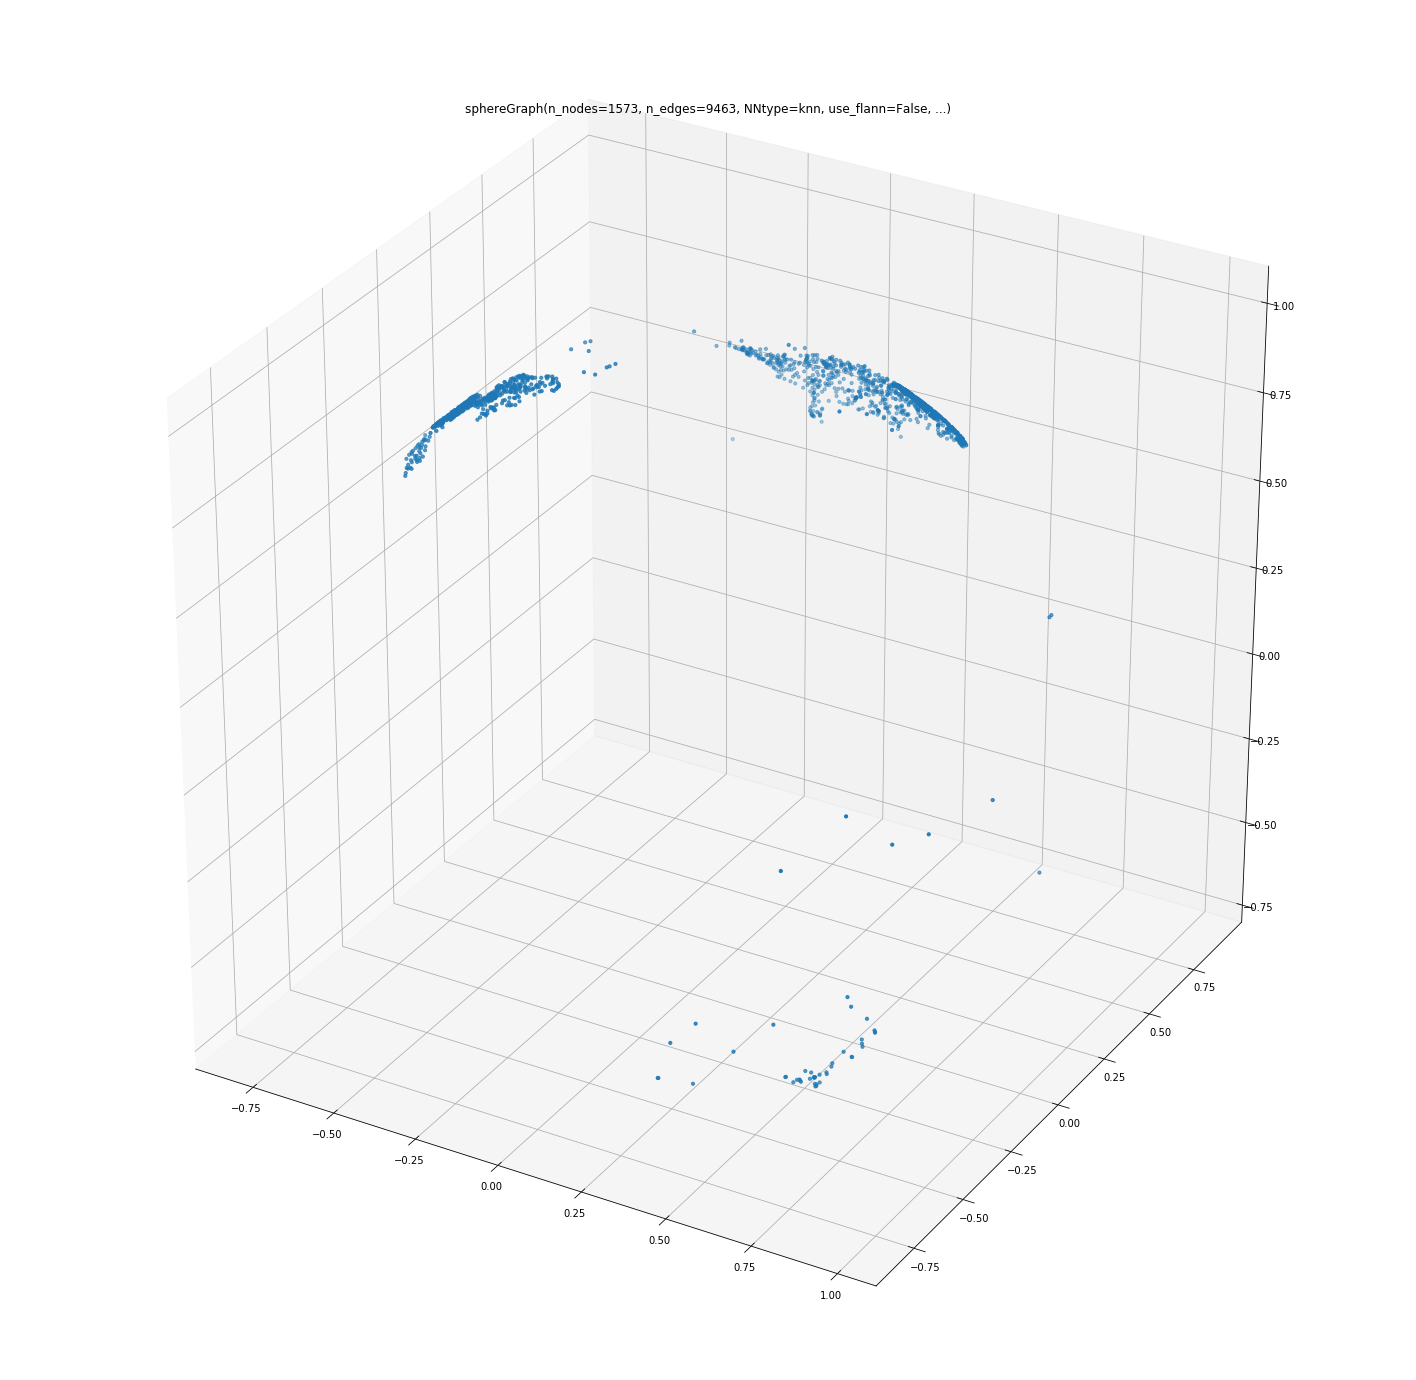

In [91]:
neighbour = 10
fig = plt.figure(figsize=(25,25))
axes = fig.add_subplot(111, projection='3d')
gReg = sphereGraph(lon[keepToo], lat[keepToo], neighbour, rad=False, epsilon=False)
gReg.plot(vertex_size=10, edges=False, ax=axes)
gReg.compute_laplacian("normalized")

In [142]:
## temp future (regression)
days_pred = 5

n_days, n_stations, n_feature= dataset_temp_reg.shape

dataset_x = np.vstack([np.roll(dataset_temp_reg, -i, axis=0) for i in range(days_pred)])
dataset_x = dataset_x.reshape(days_pred, n_days, n_stations, n_feature).transpose((1,2,3,0))

# mean_x = dataset_x.mean(axis=(0,1))
# std_x = dataset_x.std(axis=(0,1))

# month_x = np.vstack([np.roll(w_months, -i, axis=0) for i in range(days_pred)])
# month_x = month_x.reshape(days_pred, n_days).transpose()

days_x = np.vstack([np.roll(w_days, -i, axis=0) for i in range(days_pred)])
days_x = days_x.reshape(days_pred, n_days).transpose()

x_train = dataset_x[:n_days-days_pred,:,0,:]
labels_train = dataset_temp_reg[days_pred:,:,0]
x_val = dataset_x[:n_days-days_pred,:,1,:]
labels_val = dataset_temp_reg[days_pred:,:,1]

# x_train = (x_train-mean_x[0])/std_x[0]
# x_val = (x_val-mean_x[1])/std_x[1]

# location of stations
coords_v = np.stack([lon[keepToo], lat[keepToo]], axis=-1)
coords_v = (coords_v-coords_v.mean(axis=0))/coords_v.std(axis=0)
# altitude of stations
alt_v = elev[keepToo]
alt_v = (alt_v-alt_v.mean())/alt_v.std()

# can include information on which period we are? month?
x_train = np.dstack([x_train, 
#                     np.broadcast_to(month_x[:n_days-days_pred,np.newaxis, :], x_train.shape),
                     np.repeat(coords_v[np.newaxis,:], x_train.shape[0],axis=0),
                     np.repeat(alt_v[np.newaxis,:], x_train.shape[0],axis=0),
                     np.broadcast_to(days_x[:n_days-days_pred,np.newaxis, :], x_train.shape)])
x_val = np.dstack([x_val, 
#                   np.broadcast_to(month_x[:n_days-days_pred,np.newaxis, :], x_val.shape), 
                   np.repeat(coords_v[np.newaxis,:], x_train.shape[0],axis=0),
                   np.repeat(alt_v[np.newaxis,:], x_train.shape[0],axis=0),
                   np.broadcast_to(days_x[:n_days-days_pred,np.newaxis, :], x_val.shape)])

training = LabeledDataset(x_train, labels_train)
validation = LabeledDataset(x_val, labels_val)

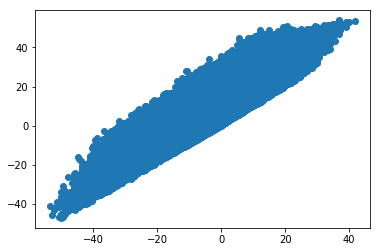

In [143]:
plt.scatter(dataset_temp_reg[:,:,0], dataset_temp_reg[:,:,1])

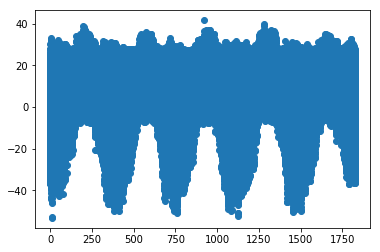

In [144]:
timereg = np.empty_like(dataset_temp_reg[:,:,0])
timereg[:,:] = np.arange(timereg.shape[0])[:,np.newaxis]
plt.scatter(timereg, dataset_temp_reg[:,:,0])

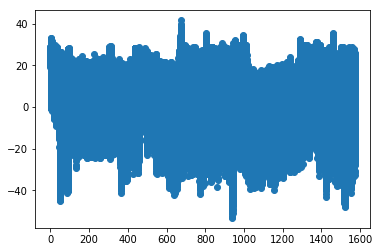

In [145]:
placereg = np.empty_like(dataset_temp_reg[:,:,0])
placereg[:,:] = np.arange(placereg.shape[1])
plt.scatter(placereg, dataset_temp_reg[:,:,0])

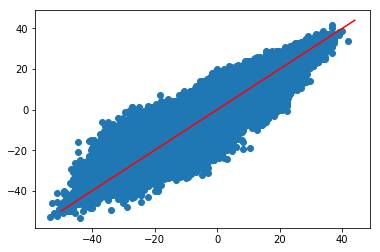

In [148]:
## is it possible to have a difference of 40 degrees between 1 day?  (must fix to +- 30 degrees)
plt.scatter(x_train[:,:,days_pred-1], labels_train)
plt.plot(range(-50, 45), range(-50, 45),'r')

#### dense-classification, segmentation weather types

In [43]:
dataset = full_data.transpose((1, 0, 2)).copy()

keep = ~np.isnan(dataset[:,:,np.array([-1])]).all(axis=0)[:,0]
dataset = dataset[:,keep,:]
keep_days = ~np.isnan(dataset[:,:,-1]).all(axis=1)
dataset = dataset[keep_days,:,:]

keepToo = ~np.isnan(dataset[:,:,np.array([-1])]).any(axis=0)
keepSuper = ((~np.isnan(dataset[:,:,np.array([-1])])).sum(axis=0)>0.75*dataset.shape[0])
keepToo = keepToo.all(axis=1)
keepSuper = keepSuper.all(axis=1)
dataset_seg = dataset[:, keepToo, 1:3]

In [44]:
print("n stations minset = {}".format(keepToo.sum()))
print("n stations superset = {}".format(keepSuper.sum()))

n stations minset = 0
n stations superset = 9


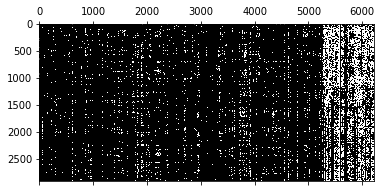

In [45]:
plt.spy(np.isnan(dataset[:,:,-1]))

#### snow prevision

In [189]:
dataset = full_data.transpose((1, 0, 2)).copy()

keepToo = ~np.isnan(dataset[:,:,:5]).any(axis=0)
keepSuper = ((~np.isnan(dataset[:,:,:5])).sum(axis=0)>0.75*dataset.shape[0])
keepToo = keepToo.all(axis=1)
keepSuper = keepSuper.all(axis=1)
dataset_snow = dataset[:, keepToo, :5]

In [188]:
print("n stations minset = {}".format(keepToo.sum()))
print("n stations superset = {}".format(keepSuper.sum()))

n stations minset = 167
n stations superset = 2439


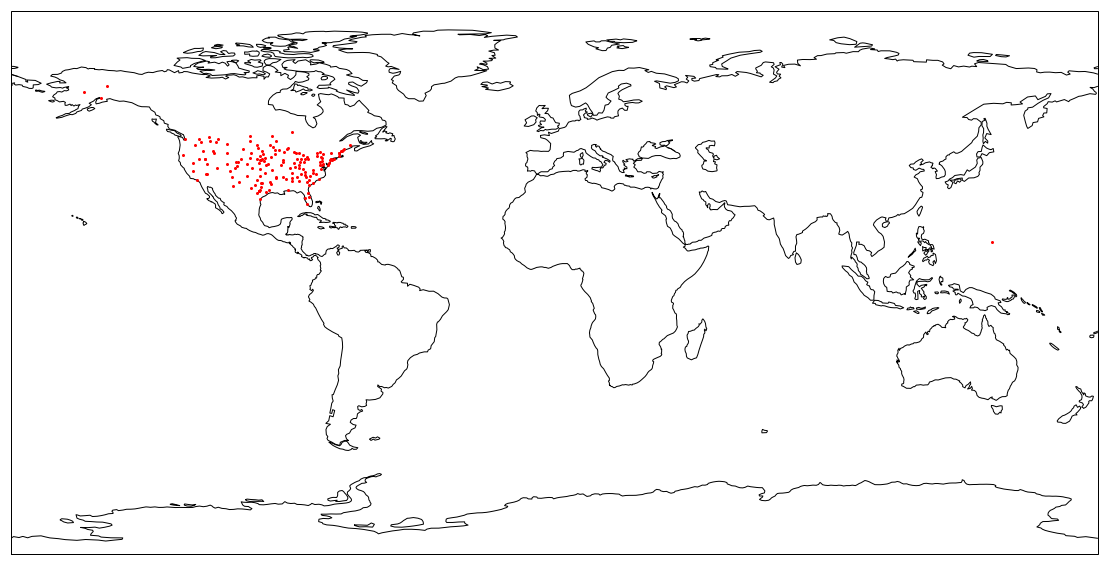

In [190]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.plot(lon[keepToo], lat[keepToo], 'or', marker='o', markerfacecolor='r', markersize=2)

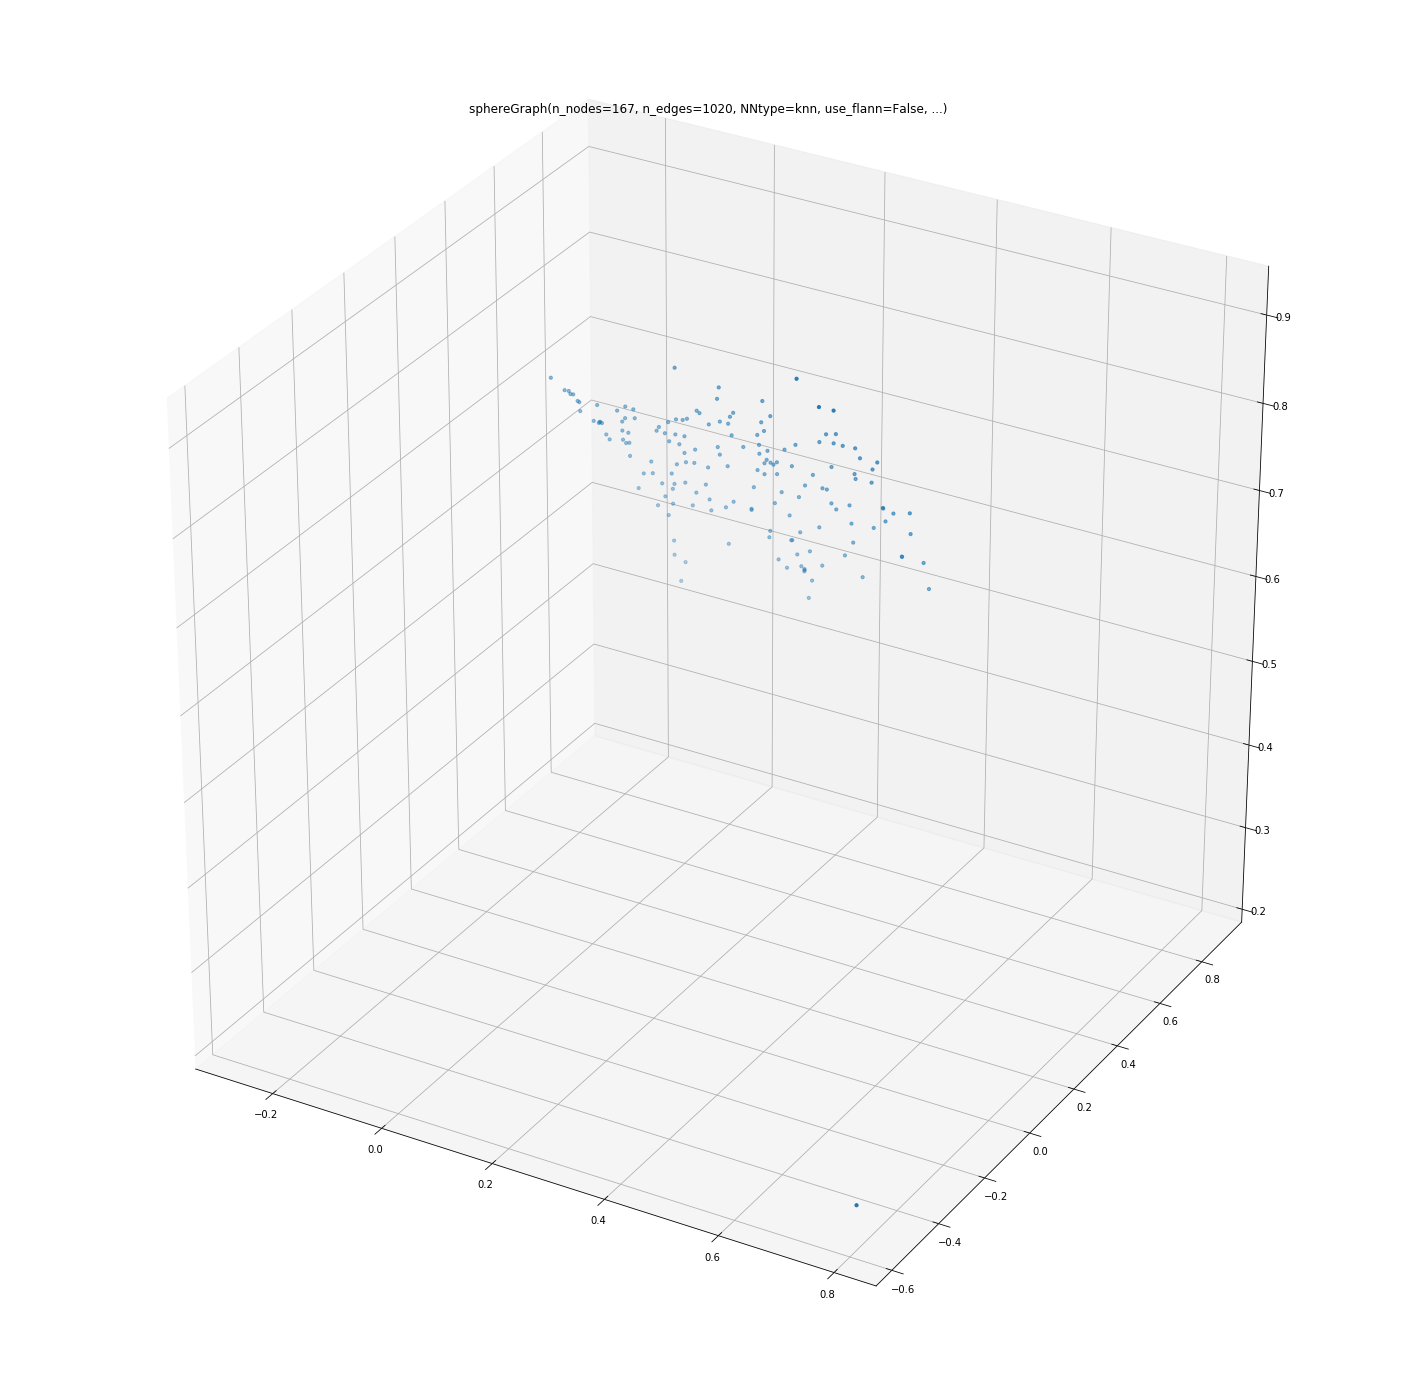

In [191]:
neighbour = 10
fig = plt.figure(figsize=(25,25))
axes = fig.add_subplot(111, projection='3d')
gSnow = sphereGraph(lon[keepToo], lat[keepToo], neighbour, rad=False, epsilon=False)
gSnow.plot(vertex_size=10, edges=False, ax=axes)
gSnow.compute_laplacian("normalized")

In [ ]:
gSnow = sphereGraph(lon[keepToo], lat[keepToo], neighbour, rad=False, epsilon=False)
gSnow.compute_laplacian("normalized")

In [193]:
## snow from others

ratio = 0.7
n_days = dataset_snow.shape[0]
limit= int(ratio*n_days)

mean = dataset_snow.mean(axis=(0,1))[:3]
std = dataset_snow.std(axis=(0,1))[:3]
# mean_label = dataset_prec.mean(axis=(0,1))[0]
# std_label = dataset_prec.std(axis=(0,1))[0]

x_train = (dataset_snow[:limit,:,:3] - mean) / std
labels_train = dataset_snow[:limit,:,3]
labels_train2 = dataset_snow[:limit,:,4]
x_val = (dataset_snow[limit:,:,:3] - mean) / std
labels_val = dataset_snow[limit:,:,3]
labels_val2 = dataset_snow[limit:,:,4]

# location of stations
coords_v = np.stack([lon[keepToo], lat[keepToo]], axis=-1)
coords_v = (coords_v-coords_v.mean(axis=0))/coords_v.std(axis=0)
# altitude of stations
alt_v = elev[keepToo]
alt_v = (alt_v-alt_v.mean())/alt_v.std()

x_train = np.dstack([x_train, np.repeat(coords_v[np.newaxis,:], x_train.shape[0], axis=0),
                     np.repeat(alt_v[np.newaxis,:], x_train.shape[0], axis=0),
                     np.repeat(w_days[:limit, np.newaxis], x_train.shape[1], axis=1)])
x_val = np.dstack([x_val, np.repeat(coords_v[np.newaxis,:], x_val.shape[0], axis=0),
                  np.repeat(alt_v[np.newaxis,:], x_val.shape[0], axis=0),
                  np.repeat(w_days[limit:, np.newaxis], x_val.shape[1], axis=1)])

training = LabeledDataset(x_train, labels_train)
validation = LabeledDataset(x_val, labels_val)

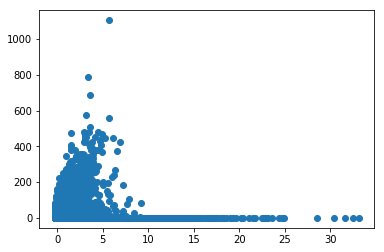

In [195]:
plt.scatter(x_train[:,:,0], labels_train)

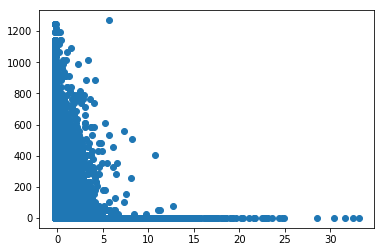

In [196]:
plt.scatter(x_train[:,:,0], labels_train2)

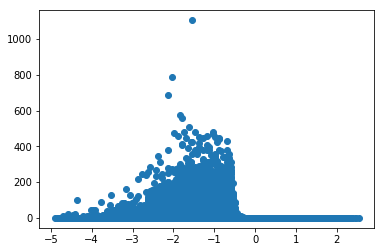

In [197]:
plt.scatter(x_train[:,:,1], labels_train)

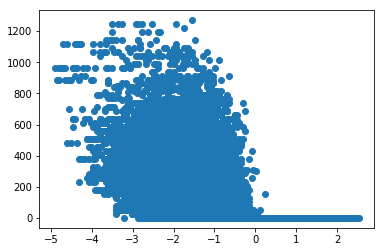

In [198]:
plt.scatter(x_train[:,:,1], labels_train2)

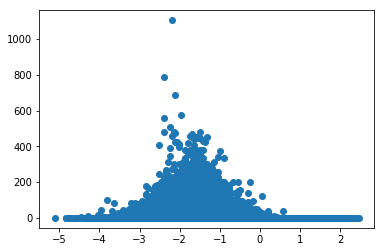

In [199]:
plt.scatter(x_train[:,:,2], labels_train)

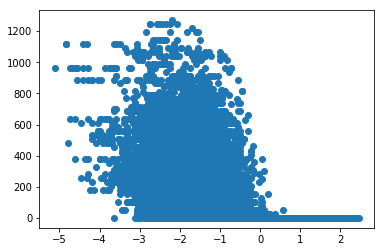

In [200]:
plt.scatter(x_train[:,:,2], labels_train2)

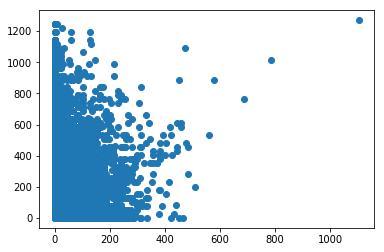

In [201]:
plt.scatter(labels_train, labels_train2)

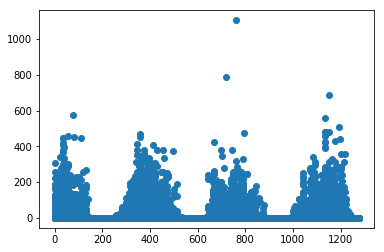

In [203]:
timesnow = np.empty_like(labels_train)
timesnow[:,:] = np.arange(timesnow.shape[0])[:,np.newaxis]
plt.scatter(timesnow, labels_train)

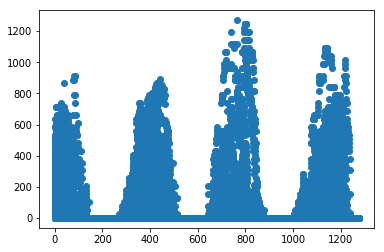

In [204]:
plt.scatter(timesnow, labels_train2)

## training

In [72]:
import tensorflow as tf
params = {'L': [gTempSuper.L.astype(np.float32)]*3,
          'p': [1,1,1],
          'F': [50, 100, 1],
          'K': [3]*3,
          'batch_norm': [True]*3}
EXP_NAME = params['dir_name'] = 'GHCN_temp_super_{}neighbours'.format(neighbour)
params['num_feat_in'] = x_train.shape[-1] # 2*days_pred+3
params['conv'] = 'chebyshev5'
params['pool'] = 'max'
params['activation'] = 'relu'
params['statistics'] = None#'mean'
params['regularization'] = 0
params['dropout'] = 1
params['num_epochs'] = 200  # Number of passes through the training data.
params['batch_size'] = 64
params['scheduler'] = lambda step: tf.train.exponential_decay(1e-3, step, decay_steps=5, decay_rate=1)
#params['optimizer'] = lambda lr: tf.train.GradientDescentOptimizer(lr)
params['optimizer'] = lambda lr: tf.train.RMSPropOptimizer(lr, decay=0.9, momentum=0.)
n_evaluations = 200
params['eval_frequency'] = int(params['num_epochs'] * (training.N) / params['batch_size'] / n_evaluations)
params['M'] = []
params['regression']=True
params['mask'] = [mask[:limit,:,1], mask[limit:,:,1]]
model = models.cgcnn(**params)

NN architecture
  input: M_0 = 9728
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 9728 * 50 / 1 = 486400
    weights: F_0 * F_1 * K_1 = 3 * 50 * 3 = 450
    biases: F_1 = 50
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 9728 * 100 / 1 = 972800
    weights: F_1 * F_2 * K_2 = 50 * 100 * 3 = 15000
    biases: F_2 = 100
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 9728 * 1 / 1 = 9728
    weights: F_2 * F_3 * K_3 = 100 * 1 * 3 = 300
    batch normalization


In [34]:
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

NN architecture
  input: M_0 = 1508
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1508 * 10 / 1 = 15080
    weights: F_0 * F_1 * K_1 = 2 * 10 * 3 = 60
    biases: F_1 = 10
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 1508 * 20 / 1 = 30160
    weights: F_1 * F_2 * K_2 = 10 * 20 * 5 = 1000
    biases: F_2 = 20
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 1508 * 50 / 1 = 75400
    weights: F_2 * F_3 * K_3 = 20 * 50 * 10 = 10000
    biases: F_3 = 50
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 1508 * 1 / 1 = 1508
    weights: F_3 * F_4 * K_4 = 50 * 1 * 20 = 1000
    batch normalization
step 19 / 399 (epoch 0.95 / 20):
  learning_rate = 2.91e-06, training accuracy = nan, training loss = 5.38e+03
  validation explained variance: 0.0004, r2: -0.1625, loss (MSE): 5.308e+03
  CPU time: 6s, wall time: 12s, perf_time_load: 0.379s, perf_time: 0.000s
step 38 / 399 (epoch 1.90 / 20)

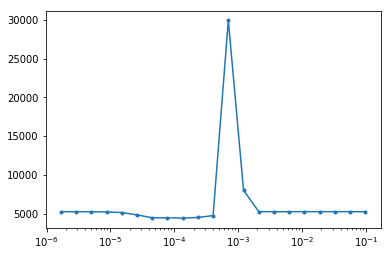

In [185]:
from deepsphere.utils import test_learning_rates
backup = params.copy()

params, learning_rate = test_learning_rates(params, training.N, 1e-6, 1e-1, num_epochs=20)

shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)

model = models.cgcnn(**params)
_, loss_validation, _, _, _ = model.fit(training, validation)

params.update(backup)
model = models.cgcnn(**params)
plt.semilogx(learning_rate, loss_validation, '.-')

In [191]:
shutil.rmtree('summaries/lr_finder/', ignore_errors=True)
shutil.rmtree('checkpoints/lr_finder/', ignore_errors=True)

In [74]:
accuracy_validation, loss_validation, loss_training, t_step, t_batch = model.fit(training_super, validation_super)

step 19 / 3993 (epoch 0.95 / 200):
  learning_rate = 1.00e-03, training accuracy = nan, training loss = 2.17e+02
  validation explained variance: 0.5335, r2: -2.1501, loss (MSE): 2.189e+02, loss (MAE): 1.285e+01
  CPU time: 9s, wall time: 28s, perf_time_load: 1.111s, perf_time: 0.000s
step 38 / 3993 (epoch 1.90 / 200):
  learning_rate = 1.00e-03, training accuracy = nan, training loss = 1.64e+02
  validation explained variance: 0.6342, r2: -1.0476, loss (MSE): 1.540e+02, loss (MAE): 1.071e+01
  CPU time: 18s, wall time: 56s, perf_time_load: 1.250s, perf_time: 0.000s
step 57 / 3993 (epoch 2.85 / 200):
  learning_rate = 1.00e-03, training accuracy = nan, training loss = 7.77e+01
  validation explained variance: 0.7158, r2: -0.1546, loss (MSE): 9.409e+01, loss (MAE): 8.113e+00
  CPU time: 26s, wall time: 85s, perf_time_load: 1.295s, perf_time: 0.000s
step 76 / 3993 (epoch 3.81 / 200):
  learning_rate = 1.00e-03, training accuracy = nan, training loss = 4.54e+01
  validation explained vari

  validation explained variance: 0.8053, r2: 0.6938, loss (MSE): 2.347e+01, loss (MAE): 3.559e+00
  CPU time: 226s, wall time: 783s, perf_time_load: 1.119s, perf_time: 0.000s
step 570 / 3993 (epoch 28.54 / 200):
  learning_rate = 1.00e-03, training accuracy = nan, training loss = 2.22e+01
  validation explained variance: 0.8060, r2: 0.7036, loss (MSE): 2.333e+01, loss (MAE): 3.537e+00
  CPU time: 233s, wall time: 808s, perf_time_load: 1.107s, perf_time: 0.000s
step 589 / 3993 (epoch 29.50 / 200):
  learning_rate = 1.00e-03, training accuracy = nan, training loss = 2.42e+01
  validation explained variance: 0.8001, r2: 0.6633, loss (MSE): 2.434e+01, loss (MAE): 3.657e+00
  CPU time: 240s, wall time: 833s, perf_time_load: 1.113s, perf_time: 0.000s
step 608 / 3993 (epoch 30.45 / 200):
  learning_rate = 1.00e-03, training accuracy = nan, training loss = 2.29e+01
  validation explained variance: 0.8018, r2: 0.6886, loss (MSE): 2.373e+01, loss (MAE): 3.565e+00
  CPU time: 247s, wall time: 858

step 1102 / 3993 (epoch 55.19 / 200):
  learning_rate = 1.00e-03, training accuracy = nan, training loss = 2.10e+01
  validation explained variance: 0.8133, r2: 0.7266, loss (MSE): 2.282e+01, loss (MAE): 3.461e+00
  CPU time: 436s, wall time: 1506s, perf_time_load: 1.118s, perf_time: 0.000s
step 1121 / 3993 (epoch 56.14 / 200):
  learning_rate = 1.00e-03, training accuracy = nan, training loss = 2.09e+01
  validation explained variance: 0.8094, r2: 0.7171, loss (MSE): 2.303e+01, loss (MAE): 3.471e+00
  CPU time: 443s, wall time: 1531s, perf_time_load: 1.151s, perf_time: 0.000s
step 1140 / 3993 (epoch 57.09 / 200):
  learning_rate = 1.00e-03, training accuracy = nan, training loss = 2.12e+01
  validation explained variance: 0.8127, r2: 0.7248, loss (MSE): 2.300e+01, loss (MAE): 3.470e+00
  CPU time: 451s, wall time: 1556s, perf_time_load: 1.139s, perf_time: 0.000s
step 1159 / 3993 (epoch 58.04 / 200):
  learning_rate = 1.00e-03, training accuracy = nan, training loss = 2.18e+01
  valida

  validation explained variance: 0.8091, r2: 0.7057, loss (MSE): 2.301e+01, loss (MAE): 3.478e+00
  CPU time: 638s, wall time: 2201s, perf_time_load: 1.120s, perf_time: 0.000s
step 1653 / 3993 (epoch 82.78 / 200):
  learning_rate = 1.00e-03, training accuracy = nan, training loss = 2.13e+01
  validation explained variance: 0.8118, r2: 0.7005, loss (MSE): 2.291e+01, loss (MAE): 3.506e+00
  CPU time: 645s, wall time: 2226s, perf_time_load: 1.103s, perf_time: 0.000s
step 1672 / 3993 (epoch 83.73 / 200):
  learning_rate = 1.00e-03, training accuracy = nan, training loss = 2.24e+01
  validation explained variance: 0.8150, r2: 0.7263, loss (MSE): 2.236e+01, loss (MAE): 3.422e+00
  CPU time: 652s, wall time: 2251s, perf_time_load: 1.114s, perf_time: 0.000s
step 1691 / 3993 (epoch 84.68 / 200):
  learning_rate = 1.00e-03, training accuracy = nan, training loss = 2.07e+01
  validation explained variance: 0.8127, r2: 0.7161, loss (MSE): 2.248e+01, loss (MAE): 3.440e+00
  CPU time: 660s, wall tim

step 2185 / 3993 (epoch 109.42 / 200):
  learning_rate = 1.00e-03, training accuracy = nan, training loss = 2.16e+01
  validation explained variance: 0.8114, r2: 0.7183, loss (MSE): 2.246e+01, loss (MAE): 3.419e+00
  CPU time: 848s, wall time: 2921s, perf_time_load: 1.118s, perf_time: 0.000s
step 2204 / 3993 (epoch 110.37 / 200):
  learning_rate = 1.00e-03, training accuracy = nan, training loss = 2.13e+01
  validation explained variance: 0.8091, r2: 0.7019, loss (MSE): 2.284e+01, loss (MAE): 3.477e+00
  CPU time: 855s, wall time: 2946s, perf_time_load: 1.132s, perf_time: 0.000s
step 2223 / 3993 (epoch 111.32 / 200):
  learning_rate = 1.00e-03, training accuracy = nan, training loss = 2.44e+01
  validation explained variance: 0.8089, r2: 0.7121, loss (MSE): 2.281e+01, loss (MAE): 3.453e+00
  CPU time: 862s, wall time: 2971s, perf_time_load: 1.140s, perf_time: 0.000s
step 2242 / 3993 (epoch 112.28 / 200):
  learning_rate = 1.00e-03, training accuracy = nan, training loss = 2.04e+01
  va

step 2717 / 3993 (epoch 136.06 / 200):
  learning_rate = 1.00e-03, training accuracy = nan, training loss = 2.01e+01
  validation explained variance: 0.8184, r2: 0.7396, loss (MSE): 2.193e+01, loss (MAE): 3.383e+00
  CPU time: 1048s, wall time: 3617s, perf_time_load: 1.110s, perf_time: 0.000s
step 2736 / 3993 (epoch 137.01 / 200):
  learning_rate = 1.00e-03, training accuracy = nan, training loss = 2.05e+01
  validation explained variance: 0.8158, r2: 0.7269, loss (MSE): 2.230e+01, loss (MAE): 3.435e+00
  CPU time: 1055s, wall time: 3642s, perf_time_load: 1.106s, perf_time: 0.000s
step 2755 / 3993 (epoch 137.97 / 200):
  learning_rate = 1.00e-03, training accuracy = nan, training loss = 2.30e+01
  validation explained variance: 0.8163, r2: 0.7339, loss (MSE): 2.195e+01, loss (MAE): 3.387e+00
  CPU time: 1063s, wall time: 3667s, perf_time_load: 1.128s, perf_time: 0.000s
step 2774 / 3993 (epoch 138.92 / 200):
  learning_rate = 1.00e-03, training accuracy = nan, training loss = 2.05e+01
 

KeyboardInterrupt: 

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


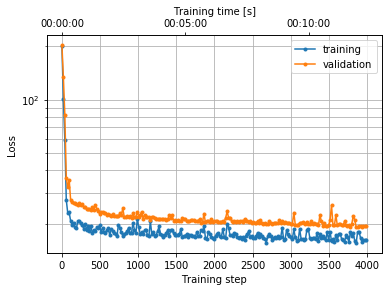

In [38]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

In [221]:
# predictions = []
# for i in range(days_pred):
#     predictions.append(dataset_temp_reg[i,:,0])
# for i in tqdm(range(len(dataset_temp_reg)-2*days_pred)):
#     x_pred = np.asarray(predictions[-days_pred:]).T
#     x_pred = np.hstack([x_pred, 
# #                      np.broadcast_to(w_months[np.newaxis,i:i+days_pred], x_pred.shape),
#                        coords_v,
#                        alt_v[:,np.newaxis],
#                        np.broadcast_to(w_days[np.newaxis, i:i+days_pred], x_pred.shape)])
#     x_pred = np.repeat(x_pred[np.newaxis,:,:], 64, axis=0)
#     res = model.predict(x_pred)
#     predictions.append(res[0,:])

  0%|          | 0/1816 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  0%|          | 1/1816 [00:00<05:44,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  0%|          | 2/1816 [00:00<05:27,  5.54it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  0%|          | 3/1816 [00:00<05:27,  5.54it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  0%|          | 4/1816 [00:00<05:27,  5.54it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  0%|          | 5/1816 [00:00<05:20,  5.65it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  0%|          | 6/1816 [00:01<05:20,  5.65it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  0%|          | 7/1816 [00:01<05:20,  5.64it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  0%|          | 8/1816 [00:01<05:33,  5.41it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  0%|          | 9/1816 [00:01<05:37,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  1%|          | 10/1816 [00:01<05:44,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  1%|          | 11/1816 [00:02<05:41,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  1%|          | 12/1816 [00:02<05:42,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  1%|          | 13/1816 [00:02<05:43,  5.24it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  1%|          | 14/1816 [00:02<05:42,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  1%|          | 15/1816 [00:02<05:40,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  1%|          | 16/1816 [00:03<05:39,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  1%|          | 17/1816 [00:03<05:42,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  1%|          | 18/1816 [00:03<05:46,  5.19it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  1%|          | 19/1816 [00:03<05:47,  5.17it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  1%|          | 20/1816 [00:03<05:47,  5.16it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  1%|          | 21/1816 [00:04<05:47,  5.17it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  1%|          | 22/1816 [00:04<05:45,  5.20it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  1%|▏         | 23/1816 [00:04<05:45,  5.18it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  1%|▏         | 24/1816 [00:04<05:45,  5.19it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  1%|▏         | 25/1816 [00:04<05:43,  5.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  1%|▏         | 26/1816 [00:04<05:42,  5.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  1%|▏         | 27/1816 [00:05<05:42,  5.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  2%|▏         | 28/1816 [00:05<05:42,  5.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  2%|▏         | 29/1816 [00:05<05:40,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  2%|▏         | 30/1816 [00:05<05:39,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  2%|▏         | 31/1816 [00:05<05:38,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  2%|▏         | 32/1816 [00:06<05:38,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  2%|▏         | 33/1816 [00:06<05:38,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  2%|▏         | 34/1816 [00:06<05:38,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  2%|▏         | 35/1816 [00:06<05:38,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  2%|▏         | 36/1816 [00:06<05:37,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  2%|▏         | 37/1816 [00:07<05:36,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  2%|▏         | 38/1816 [00:07<05:37,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  2%|▏         | 39/1816 [00:07<05:37,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  2%|▏         | 40/1816 [00:07<05:38,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  2%|▏         | 41/1816 [00:07<05:39,  5.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  2%|▏         | 42/1816 [00:08<05:39,  5.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  2%|▏         | 43/1816 [00:08<05:38,  5.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  2%|▏         | 44/1816 [00:08<05:38,  5.24it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  2%|▏         | 45/1816 [00:08<05:38,  5.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  3%|▎         | 46/1816 [00:08<05:40,  5.20it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  3%|▎         | 47/1816 [00:09<05:41,  5.18it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  3%|▎         | 48/1816 [00:09<05:41,  5.18it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  3%|▎         | 49/1816 [00:09<05:41,  5.18it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  3%|▎         | 50/1816 [00:09<05:40,  5.18it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  3%|▎         | 51/1816 [00:09<05:41,  5.18it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  3%|▎         | 52/1816 [00:10<05:41,  5.17it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  3%|▎         | 53/1816 [00:10<05:40,  5.17it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  3%|▎         | 54/1816 [00:10<05:41,  5.16it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  3%|▎         | 55/1816 [00:10<05:40,  5.17it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  3%|▎         | 56/1816 [00:10<05:40,  5.18it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  3%|▎         | 57/1816 [00:11<05:39,  5.18it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  3%|▎         | 58/1816 [00:11<05:39,  5.18it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  3%|▎         | 59/1816 [00:11<05:38,  5.19it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  3%|▎         | 60/1816 [00:11<05:38,  5.19it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  3%|▎         | 61/1816 [00:11<05:39,  5.17it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  3%|▎         | 62/1816 [00:11<05:39,  5.17it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  3%|▎         | 63/1816 [00:12<05:39,  5.17it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  4%|▎         | 64/1816 [00:12<05:39,  5.16it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  4%|▎         | 65/1816 [00:12<05:39,  5.16it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  4%|▎         | 66/1816 [00:12<05:38,  5.17it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  4%|▎         | 67/1816 [00:12<05:38,  5.16it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  4%|▎         | 68/1816 [00:13<05:39,  5.15it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  4%|▍         | 69/1816 [00:13<05:39,  5.14it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  4%|▍         | 70/1816 [00:13<05:39,  5.14it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  4%|▍         | 71/1816 [00:13<05:39,  5.14it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  4%|▍         | 72/1816 [00:13<05:38,  5.14it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  4%|▍         | 73/1816 [00:14<05:38,  5.15it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  4%|▍         | 74/1816 [00:14<05:37,  5.15it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  4%|▍         | 75/1816 [00:14<05:37,  5.16it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  4%|▍         | 76/1816 [00:14<05:36,  5.17it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  4%|▍         | 77/1816 [00:14<05:36,  5.17it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  4%|▍         | 78/1816 [00:15<05:35,  5.18it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  4%|▍         | 79/1816 [00:15<05:34,  5.19it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  4%|▍         | 80/1816 [00:15<05:33,  5.20it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  4%|▍         | 81/1816 [00:15<05:33,  5.20it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  5%|▍         | 82/1816 [00:15<05:33,  5.20it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  5%|▍         | 83/1816 [00:15<05:32,  5.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  5%|▍         | 84/1816 [00:16<05:32,  5.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  5%|▍         | 85/1816 [00:16<05:31,  5.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  5%|▍         | 86/1816 [00:16<05:31,  5.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  5%|▍         | 87/1816 [00:16<05:30,  5.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  5%|▍         | 88/1816 [00:16<05:31,  5.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  5%|▍         | 89/1816 [00:17<05:31,  5.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  5%|▍         | 90/1816 [00:17<05:31,  5.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  5%|▌         | 91/1816 [00:17<05:31,  5.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  5%|▌         | 92/1816 [00:17<05:30,  5.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  5%|▌         | 93/1816 [00:17<05:30,  5.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  5%|▌         | 94/1816 [00:18<05:30,  5.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  5%|▌         | 95/1816 [00:18<05:29,  5.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  5%|▌         | 96/1816 [00:18<05:29,  5.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  5%|▌         | 97/1816 [00:18<05:29,  5.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  5%|▌         | 98/1816 [00:18<05:29,  5.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  5%|▌         | 99/1816 [00:19<05:29,  5.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  6%|▌         | 100/1816 [00:19<05:29,  5.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  6%|▌         | 101/1816 [00:19<05:29,  5.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  6%|▌         | 102/1816 [00:19<05:28,  5.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  6%|▌         | 103/1816 [00:19<05:28,  5.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  6%|▌         | 104/1816 [00:19<05:27,  5.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  6%|▌         | 105/1816 [00:20<05:27,  5.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  6%|▌         | 106/1816 [00:20<05:27,  5.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  6%|▌         | 107/1816 [00:20<05:26,  5.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  6%|▌         | 108/1816 [00:20<05:26,  5.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  6%|▌         | 109/1816 [00:20<05:26,  5.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  6%|▌         | 110/1816 [00:21<05:25,  5.24it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  6%|▌         | 111/1816 [00:21<05:25,  5.24it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  6%|▌         | 112/1816 [00:21<05:25,  5.24it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  6%|▌         | 113/1816 [00:21<05:25,  5.24it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  6%|▋         | 114/1816 [00:21<05:24,  5.24it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  6%|▋         | 115/1816 [00:21<05:24,  5.24it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  6%|▋         | 116/1816 [00:22<05:24,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  6%|▋         | 117/1816 [00:22<05:24,  5.24it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  6%|▋         | 118/1816 [00:22<05:23,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  7%|▋         | 119/1816 [00:22<05:23,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  7%|▋         | 120/1816 [00:22<05:23,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  7%|▋         | 121/1816 [00:23<05:22,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  7%|▋         | 122/1816 [00:23<05:22,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  7%|▋         | 123/1816 [00:23<05:22,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  7%|▋         | 124/1816 [00:23<05:22,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  7%|▋         | 125/1816 [00:23<05:21,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  7%|▋         | 126/1816 [00:23<05:21,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  7%|▋         | 127/1816 [00:24<05:20,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  7%|▋         | 128/1816 [00:24<05:20,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  7%|▋         | 129/1816 [00:24<05:20,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  7%|▋         | 130/1816 [00:24<05:20,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  7%|▋         | 131/1816 [00:24<05:20,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  7%|▋         | 132/1816 [00:25<05:20,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  7%|▋         | 133/1816 [00:25<05:20,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  7%|▋         | 134/1816 [00:25<05:20,  5.24it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  7%|▋         | 135/1816 [00:25<05:20,  5.24it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  7%|▋         | 136/1816 [00:25<05:20,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  8%|▊         | 137/1816 [00:26<05:19,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  8%|▊         | 138/1816 [00:26<05:19,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  8%|▊         | 139/1816 [00:26<05:19,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  8%|▊         | 140/1816 [00:26<05:18,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  8%|▊         | 141/1816 [00:26<05:18,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  8%|▊         | 142/1816 [00:26<05:18,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  8%|▊         | 143/1816 [00:27<05:18,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  8%|▊         | 144/1816 [00:27<05:17,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  8%|▊         | 145/1816 [00:27<05:17,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  8%|▊         | 146/1816 [00:27<05:17,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  8%|▊         | 147/1816 [00:27<05:17,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  8%|▊         | 148/1816 [00:28<05:17,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  8%|▊         | 149/1816 [00:28<05:16,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  8%|▊         | 150/1816 [00:28<05:16,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  8%|▊         | 151/1816 [00:28<05:16,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  8%|▊         | 152/1816 [00:28<05:16,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  8%|▊         | 153/1816 [00:29<05:15,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  8%|▊         | 154/1816 [00:29<05:15,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  9%|▊         | 155/1816 [00:29<05:15,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  9%|▊         | 156/1816 [00:29<05:14,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  9%|▊         | 157/1816 [00:29<05:14,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  9%|▊         | 158/1816 [00:29<05:14,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  9%|▉         | 159/1816 [00:30<05:14,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  9%|▉         | 160/1816 [00:30<05:13,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  9%|▉         | 161/1816 [00:30<05:13,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  9%|▉         | 162/1816 [00:30<05:13,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  9%|▉         | 163/1816 [00:30<05:13,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  9%|▉         | 164/1816 [00:31<05:13,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  9%|▉         | 165/1816 [00:31<05:13,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  9%|▉         | 166/1816 [00:31<05:13,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  9%|▉         | 167/1816 [00:31<05:13,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  9%|▉         | 168/1816 [00:31<05:13,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  9%|▉         | 169/1816 [00:32<05:13,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  9%|▉         | 170/1816 [00:32<05:12,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  9%|▉         | 171/1816 [00:32<05:12,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


  9%|▉         | 172/1816 [00:32<05:12,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 10%|▉         | 173/1816 [00:32<05:11,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 10%|▉         | 174/1816 [00:33<05:11,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 10%|▉         | 175/1816 [00:33<05:11,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 10%|▉         | 176/1816 [00:33<05:11,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 10%|▉         | 177/1816 [00:33<05:10,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 10%|▉         | 178/1816 [00:33<05:10,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 10%|▉         | 179/1816 [00:33<05:10,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 10%|▉         | 180/1816 [00:34<05:10,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 10%|▉         | 181/1816 [00:34<05:09,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 10%|█         | 182/1816 [00:34<05:09,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 10%|█         | 183/1816 [00:34<05:09,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 10%|█         | 184/1816 [00:34<05:09,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 10%|█         | 185/1816 [00:35<05:10,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 10%|█         | 186/1816 [00:35<05:10,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 10%|█         | 187/1816 [00:35<05:09,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 10%|█         | 188/1816 [00:35<05:09,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 10%|█         | 189/1816 [00:35<05:09,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 10%|█         | 190/1816 [00:36<05:09,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 11%|█         | 191/1816 [00:36<05:09,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 11%|█         | 192/1816 [00:36<05:08,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 11%|█         | 193/1816 [00:36<05:08,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 11%|█         | 194/1816 [00:36<05:08,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 11%|█         | 195/1816 [00:37<05:08,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 11%|█         | 196/1816 [00:37<05:08,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 11%|█         | 197/1816 [00:37<05:07,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 11%|█         | 198/1816 [00:37<05:07,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 11%|█         | 199/1816 [00:37<05:07,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 11%|█         | 200/1816 [00:38<05:07,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 11%|█         | 201/1816 [00:38<05:06,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 11%|█         | 202/1816 [00:38<05:06,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 11%|█         | 203/1816 [00:38<05:06,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 11%|█         | 204/1816 [00:38<05:06,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 11%|█▏        | 205/1816 [00:38<05:06,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 11%|█▏        | 206/1816 [00:39<05:05,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 11%|█▏        | 207/1816 [00:39<05:05,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 11%|█▏        | 208/1816 [00:39<05:05,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 12%|█▏        | 209/1816 [00:39<05:05,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 12%|█▏        | 210/1816 [00:39<05:05,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 12%|█▏        | 211/1816 [00:40<05:04,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 12%|█▏        | 212/1816 [00:40<05:04,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 12%|█▏        | 213/1816 [00:40<05:04,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 12%|█▏        | 214/1816 [00:40<05:04,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 12%|█▏        | 215/1816 [00:40<05:04,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 12%|█▏        | 216/1816 [00:41<05:04,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 12%|█▏        | 217/1816 [00:41<05:04,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 12%|█▏        | 218/1816 [00:41<05:04,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 12%|█▏        | 219/1816 [00:41<05:04,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 12%|█▏        | 220/1816 [00:41<05:04,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 12%|█▏        | 221/1816 [00:42<05:03,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 12%|█▏        | 222/1816 [00:42<05:03,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 12%|█▏        | 223/1816 [00:42<05:03,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 12%|█▏        | 224/1816 [00:42<05:02,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 12%|█▏        | 225/1816 [00:42<05:02,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 12%|█▏        | 226/1816 [00:42<05:02,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 12%|█▎        | 227/1816 [00:43<05:02,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 13%|█▎        | 228/1816 [00:43<05:02,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 13%|█▎        | 229/1816 [00:43<05:01,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 13%|█▎        | 230/1816 [00:43<05:01,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 13%|█▎        | 231/1816 [00:43<05:01,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 13%|█▎        | 232/1816 [00:44<05:00,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 13%|█▎        | 233/1816 [00:44<05:00,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 13%|█▎        | 234/1816 [00:44<05:00,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 13%|█▎        | 235/1816 [00:44<05:00,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 13%|█▎        | 236/1816 [00:44<04:59,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 13%|█▎        | 237/1816 [00:44<04:59,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 13%|█▎        | 238/1816 [00:45<04:59,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 13%|█▎        | 239/1816 [00:45<04:59,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 13%|█▎        | 240/1816 [00:45<04:59,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 13%|█▎        | 241/1816 [00:45<04:59,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 13%|█▎        | 242/1816 [00:45<04:58,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 13%|█▎        | 243/1816 [00:46<04:58,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 13%|█▎        | 244/1816 [00:46<04:58,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 13%|█▎        | 245/1816 [00:46<04:58,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 14%|█▎        | 246/1816 [00:46<04:58,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 14%|█▎        | 247/1816 [00:46<04:58,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 14%|█▎        | 248/1816 [00:47<04:57,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 14%|█▎        | 249/1816 [00:47<04:58,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 14%|█▍        | 250/1816 [00:47<04:57,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 14%|█▍        | 251/1816 [00:47<04:57,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 14%|█▍        | 252/1816 [00:47<04:57,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 14%|█▍        | 253/1816 [00:48<04:57,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 14%|█▍        | 254/1816 [00:48<04:57,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 14%|█▍        | 255/1816 [00:48<04:56,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 14%|█▍        | 256/1816 [00:48<04:56,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 14%|█▍        | 257/1816 [00:48<04:56,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 14%|█▍        | 258/1816 [00:49<04:56,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 14%|█▍        | 259/1816 [00:49<04:56,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 14%|█▍        | 260/1816 [00:49<04:56,  5.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 14%|█▍        | 261/1816 [00:49<04:55,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 14%|█▍        | 262/1816 [00:49<04:55,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 14%|█▍        | 263/1816 [00:49<04:55,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 15%|█▍        | 264/1816 [00:50<04:54,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 15%|█▍        | 265/1816 [00:50<04:54,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 15%|█▍        | 266/1816 [00:50<04:54,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 15%|█▍        | 267/1816 [00:50<04:54,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 15%|█▍        | 268/1816 [00:50<04:53,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 15%|█▍        | 269/1816 [00:51<04:53,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 15%|█▍        | 270/1816 [00:51<04:53,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 15%|█▍        | 271/1816 [00:51<04:53,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 15%|█▍        | 272/1816 [00:51<04:52,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 15%|█▌        | 273/1816 [00:51<04:52,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 15%|█▌        | 274/1816 [00:51<04:52,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 15%|█▌        | 275/1816 [00:52<04:52,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 15%|█▌        | 276/1816 [00:52<04:51,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 15%|█▌        | 277/1816 [00:52<04:51,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 15%|█▌        | 278/1816 [00:52<04:51,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 15%|█▌        | 279/1816 [00:52<04:51,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 15%|█▌        | 280/1816 [00:53<04:51,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 15%|█▌        | 281/1816 [00:53<04:50,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 16%|█▌        | 282/1816 [00:53<04:50,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 16%|█▌        | 283/1816 [00:53<04:50,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 16%|█▌        | 284/1816 [00:53<04:50,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 16%|█▌        | 285/1816 [00:54<04:50,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 16%|█▌        | 286/1816 [00:54<04:49,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 16%|█▌        | 287/1816 [00:54<04:49,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 16%|█▌        | 288/1816 [00:54<04:49,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 16%|█▌        | 289/1816 [00:54<04:49,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 16%|█▌        | 290/1816 [00:54<04:48,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 16%|█▌        | 291/1816 [00:55<04:48,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 16%|█▌        | 292/1816 [00:55<04:48,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 16%|█▌        | 293/1816 [00:55<04:48,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 16%|█▌        | 294/1816 [00:55<04:48,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 16%|█▌        | 295/1816 [00:55<04:47,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 16%|█▋        | 296/1816 [00:55<04:47,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 16%|█▋        | 297/1816 [00:56<04:47,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 16%|█▋        | 298/1816 [00:56<04:46,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 16%|█▋        | 299/1816 [00:56<04:46,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 17%|█▋        | 300/1816 [00:56<04:46,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 17%|█▋        | 301/1816 [00:56<04:46,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 17%|█▋        | 302/1816 [00:57<04:46,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 17%|█▋        | 303/1816 [00:57<04:46,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 17%|█▋        | 304/1816 [00:57<04:46,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 17%|█▋        | 305/1816 [00:57<04:46,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 17%|█▋        | 306/1816 [00:57<04:45,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 17%|█▋        | 307/1816 [00:58<04:45,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 17%|█▋        | 308/1816 [00:58<04:45,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 17%|█▋        | 309/1816 [00:58<04:45,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 17%|█▋        | 310/1816 [00:58<04:45,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 17%|█▋        | 311/1816 [00:58<04:44,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 17%|█▋        | 312/1816 [00:59<04:44,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 17%|█▋        | 313/1816 [00:59<04:44,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 17%|█▋        | 314/1816 [00:59<04:44,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 17%|█▋        | 315/1816 [00:59<04:44,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 17%|█▋        | 316/1816 [00:59<04:43,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 17%|█▋        | 317/1816 [00:59<04:43,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 18%|█▊        | 318/1816 [01:00<04:43,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 18%|█▊        | 319/1816 [01:00<04:43,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 18%|█▊        | 320/1816 [01:00<04:43,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 18%|█▊        | 321/1816 [01:00<04:42,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 18%|█▊        | 322/1816 [01:00<04:42,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 18%|█▊        | 323/1816 [01:01<04:42,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 18%|█▊        | 324/1816 [01:01<04:42,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 18%|█▊        | 325/1816 [01:01<04:41,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 18%|█▊        | 326/1816 [01:01<04:41,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 18%|█▊        | 327/1816 [01:01<04:41,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 18%|█▊        | 328/1816 [01:02<04:41,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 18%|█▊        | 329/1816 [01:02<04:41,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 18%|█▊        | 330/1816 [01:02<04:41,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 18%|█▊        | 331/1816 [01:02<04:40,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 18%|█▊        | 332/1816 [01:02<04:40,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 18%|█▊        | 333/1816 [01:02<04:40,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 18%|█▊        | 334/1816 [01:03<04:40,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 18%|█▊        | 335/1816 [01:03<04:40,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 19%|█▊        | 336/1816 [01:03<04:39,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 19%|█▊        | 337/1816 [01:03<04:39,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 19%|█▊        | 338/1816 [01:03<04:39,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 19%|█▊        | 339/1816 [01:04<04:39,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 19%|█▊        | 340/1816 [01:04<04:38,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 19%|█▉        | 341/1816 [01:04<04:38,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 19%|█▉        | 342/1816 [01:04<04:38,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 19%|█▉        | 343/1816 [01:04<04:38,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 19%|█▉        | 344/1816 [01:05<04:38,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 19%|█▉        | 345/1816 [01:05<04:38,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 19%|█▉        | 346/1816 [01:05<04:37,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 19%|█▉        | 347/1816 [01:05<04:37,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 19%|█▉        | 348/1816 [01:05<04:37,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 19%|█▉        | 349/1816 [01:06<04:37,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 19%|█▉        | 350/1816 [01:06<04:37,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 19%|█▉        | 351/1816 [01:06<04:37,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 19%|█▉        | 352/1816 [01:06<04:36,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 19%|█▉        | 353/1816 [01:06<04:36,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 19%|█▉        | 354/1816 [01:06<04:36,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 20%|█▉        | 355/1816 [01:07<04:36,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 20%|█▉        | 356/1816 [01:07<04:35,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 20%|█▉        | 357/1816 [01:07<04:35,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 20%|█▉        | 358/1816 [01:07<04:35,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 20%|█▉        | 359/1816 [01:07<04:35,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 20%|█▉        | 360/1816 [01:08<04:35,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 20%|█▉        | 361/1816 [01:08<04:34,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 20%|█▉        | 362/1816 [01:08<04:34,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 20%|█▉        | 363/1816 [01:08<04:34,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 20%|██        | 364/1816 [01:08<04:34,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 20%|██        | 365/1816 [01:08<04:34,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 20%|██        | 366/1816 [01:09<04:34,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 20%|██        | 367/1816 [01:09<04:33,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 20%|██        | 368/1816 [01:09<04:33,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 20%|██        | 369/1816 [01:09<04:33,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 20%|██        | 370/1816 [01:10<04:33,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 20%|██        | 371/1816 [01:10<04:33,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 20%|██        | 372/1816 [01:10<04:33,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 21%|██        | 373/1816 [01:10<04:33,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 21%|██        | 374/1816 [01:10<04:32,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 21%|██        | 375/1816 [01:10<04:32,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 21%|██        | 376/1816 [01:11<04:32,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 21%|██        | 377/1816 [01:11<04:32,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 21%|██        | 378/1816 [01:11<04:32,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 21%|██        | 379/1816 [01:11<04:32,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 21%|██        | 380/1816 [01:12<04:32,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 21%|██        | 381/1816 [01:12<04:31,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 21%|██        | 382/1816 [01:12<04:31,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 21%|██        | 383/1816 [01:12<04:31,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 21%|██        | 384/1816 [01:12<04:31,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 21%|██        | 385/1816 [01:12<04:31,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 21%|██▏       | 386/1816 [01:13<04:31,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 21%|██▏       | 387/1816 [01:13<04:30,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 21%|██▏       | 388/1816 [01:13<04:30,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 21%|██▏       | 389/1816 [01:13<04:30,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 21%|██▏       | 390/1816 [01:13<04:30,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 22%|██▏       | 391/1816 [01:14<04:30,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 22%|██▏       | 392/1816 [01:14<04:29,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 22%|██▏       | 393/1816 [01:14<04:29,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 22%|██▏       | 394/1816 [01:14<04:29,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 22%|██▏       | 395/1816 [01:14<04:29,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 22%|██▏       | 396/1816 [01:15<04:28,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 22%|██▏       | 397/1816 [01:15<04:28,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 22%|██▏       | 398/1816 [01:15<04:28,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 22%|██▏       | 399/1816 [01:15<04:28,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 22%|██▏       | 400/1816 [01:15<04:28,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 22%|██▏       | 401/1816 [01:15<04:27,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 22%|██▏       | 402/1816 [01:16<04:27,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 22%|██▏       | 403/1816 [01:16<04:27,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 22%|██▏       | 404/1816 [01:16<04:27,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 22%|██▏       | 405/1816 [01:16<04:27,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 22%|██▏       | 406/1816 [01:16<04:27,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 22%|██▏       | 407/1816 [01:17<04:26,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 22%|██▏       | 408/1816 [01:17<04:26,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 23%|██▎       | 409/1816 [01:17<04:26,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 23%|██▎       | 410/1816 [01:17<04:26,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 23%|██▎       | 411/1816 [01:17<04:25,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 23%|██▎       | 412/1816 [01:17<04:25,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 23%|██▎       | 413/1816 [01:18<04:25,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 23%|██▎       | 414/1816 [01:18<04:25,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 23%|██▎       | 415/1816 [01:18<04:25,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 23%|██▎       | 416/1816 [01:18<04:25,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 23%|██▎       | 417/1816 [01:18<04:24,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 23%|██▎       | 418/1816 [01:19<04:24,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 23%|██▎       | 419/1816 [01:19<04:24,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 23%|██▎       | 420/1816 [01:19<04:24,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 23%|██▎       | 421/1816 [01:19<04:23,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 23%|██▎       | 422/1816 [01:19<04:23,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 23%|██▎       | 423/1816 [01:20<04:23,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 23%|██▎       | 424/1816 [01:20<04:23,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 23%|██▎       | 425/1816 [01:20<04:23,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 23%|██▎       | 426/1816 [01:20<04:22,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 24%|██▎       | 427/1816 [01:20<04:22,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 24%|██▎       | 428/1816 [01:20<04:22,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 24%|██▎       | 429/1816 [01:21<04:22,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 24%|██▎       | 430/1816 [01:21<04:22,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 24%|██▎       | 431/1816 [01:21<04:21,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 24%|██▍       | 432/1816 [01:21<04:21,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 24%|██▍       | 433/1816 [01:21<04:21,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 24%|██▍       | 434/1816 [01:22<04:21,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 24%|██▍       | 435/1816 [01:22<04:21,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 24%|██▍       | 436/1816 [01:22<04:20,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 24%|██▍       | 437/1816 [01:22<04:20,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 24%|██▍       | 438/1816 [01:22<04:20,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 24%|██▍       | 439/1816 [01:23<04:20,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 24%|██▍       | 440/1816 [01:23<04:20,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 24%|██▍       | 441/1816 [01:23<04:20,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 24%|██▍       | 442/1816 [01:23<04:20,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 24%|██▍       | 443/1816 [01:23<04:20,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 24%|██▍       | 444/1816 [01:24<04:19,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 25%|██▍       | 445/1816 [01:24<04:19,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 25%|██▍       | 446/1816 [01:24<04:19,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 25%|██▍       | 447/1816 [01:24<04:19,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 25%|██▍       | 448/1816 [01:24<04:19,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 25%|██▍       | 449/1816 [01:25<04:18,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 25%|██▍       | 450/1816 [01:25<04:18,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 25%|██▍       | 451/1816 [01:25<04:18,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 25%|██▍       | 452/1816 [01:25<04:18,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 25%|██▍       | 453/1816 [01:25<04:17,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 25%|██▌       | 454/1816 [01:25<04:17,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 25%|██▌       | 455/1816 [01:26<04:17,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 25%|██▌       | 456/1816 [01:26<04:17,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 25%|██▌       | 457/1816 [01:26<04:17,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 25%|██▌       | 458/1816 [01:26<04:16,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 25%|██▌       | 459/1816 [01:26<04:16,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 25%|██▌       | 460/1816 [01:27<04:16,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 25%|██▌       | 461/1816 [01:27<04:16,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 25%|██▌       | 462/1816 [01:27<04:16,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 25%|██▌       | 463/1816 [01:27<04:16,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 26%|██▌       | 464/1816 [01:27<04:15,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 26%|██▌       | 465/1816 [01:28<04:15,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 26%|██▌       | 466/1816 [01:28<04:15,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 26%|██▌       | 467/1816 [01:28<04:15,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 26%|██▌       | 468/1816 [01:28<04:15,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 26%|██▌       | 469/1816 [01:28<04:14,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 26%|██▌       | 470/1816 [01:28<04:14,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 26%|██▌       | 471/1816 [01:29<04:14,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 26%|██▌       | 472/1816 [01:29<04:14,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 26%|██▌       | 473/1816 [01:29<04:14,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 26%|██▌       | 474/1816 [01:29<04:13,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 26%|██▌       | 475/1816 [01:29<04:13,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 26%|██▌       | 476/1816 [01:30<04:13,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 26%|██▋       | 477/1816 [01:30<04:13,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 26%|██▋       | 478/1816 [01:30<04:13,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 26%|██▋       | 479/1816 [01:30<04:13,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 26%|██▋       | 480/1816 [01:30<04:12,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 26%|██▋       | 481/1816 [01:31<04:12,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 27%|██▋       | 482/1816 [01:31<04:12,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 27%|██▋       | 483/1816 [01:31<04:12,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 27%|██▋       | 484/1816 [01:31<04:12,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 27%|██▋       | 485/1816 [01:31<04:11,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 27%|██▋       | 486/1816 [01:31<04:11,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 27%|██▋       | 487/1816 [01:32<04:11,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 27%|██▋       | 488/1816 [01:32<04:11,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 27%|██▋       | 489/1816 [01:32<04:11,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 27%|██▋       | 490/1816 [01:32<04:10,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 27%|██▋       | 491/1816 [01:32<04:10,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 27%|██▋       | 492/1816 [01:33<04:10,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 27%|██▋       | 493/1816 [01:33<04:10,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 27%|██▋       | 494/1816 [01:33<04:10,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 27%|██▋       | 495/1816 [01:33<04:09,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 27%|██▋       | 496/1816 [01:33<04:09,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 27%|██▋       | 497/1816 [01:34<04:09,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 27%|██▋       | 498/1816 [01:34<04:09,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 27%|██▋       | 499/1816 [01:34<04:09,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 28%|██▊       | 500/1816 [01:34<04:09,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 28%|██▊       | 501/1816 [01:34<04:08,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 28%|██▊       | 502/1816 [01:35<04:08,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 28%|██▊       | 503/1816 [01:35<04:08,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 28%|██▊       | 504/1816 [01:35<04:08,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 28%|██▊       | 505/1816 [01:35<04:08,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 28%|██▊       | 506/1816 [01:35<04:08,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 28%|██▊       | 507/1816 [01:36<04:07,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 28%|██▊       | 508/1816 [01:36<04:07,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 28%|██▊       | 509/1816 [01:36<04:07,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 28%|██▊       | 510/1816 [01:36<04:07,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 28%|██▊       | 511/1816 [01:36<04:07,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 28%|██▊       | 512/1816 [01:37<04:07,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 28%|██▊       | 513/1816 [01:37<04:06,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 28%|██▊       | 514/1816 [01:37<04:06,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 28%|██▊       | 515/1816 [01:37<04:06,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 28%|██▊       | 516/1816 [01:37<04:06,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 28%|██▊       | 517/1816 [01:37<04:06,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 29%|██▊       | 518/1816 [01:38<04:05,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 29%|██▊       | 519/1816 [01:38<04:05,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 29%|██▊       | 520/1816 [01:38<04:05,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 29%|██▊       | 521/1816 [01:38<04:05,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 29%|██▊       | 522/1816 [01:38<04:05,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 29%|██▉       | 523/1816 [01:39<04:04,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 29%|██▉       | 524/1816 [01:39<04:04,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 29%|██▉       | 525/1816 [01:39<04:04,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 29%|██▉       | 526/1816 [01:39<04:04,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 29%|██▉       | 527/1816 [01:39<04:04,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 29%|██▉       | 528/1816 [01:40<04:03,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 29%|██▉       | 529/1816 [01:40<04:03,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 29%|██▉       | 530/1816 [01:40<04:03,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 29%|██▉       | 531/1816 [01:40<04:03,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 29%|██▉       | 532/1816 [01:40<04:03,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 29%|██▉       | 533/1816 [01:41<04:03,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 29%|██▉       | 534/1816 [01:41<04:03,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 29%|██▉       | 535/1816 [01:41<04:02,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 30%|██▉       | 536/1816 [01:41<04:02,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 30%|██▉       | 537/1816 [01:41<04:02,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 30%|██▉       | 538/1816 [01:42<04:02,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 30%|██▉       | 539/1816 [01:42<04:02,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 30%|██▉       | 540/1816 [01:42<04:02,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 30%|██▉       | 541/1816 [01:42<04:01,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 30%|██▉       | 542/1816 [01:42<04:01,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 30%|██▉       | 543/1816 [01:43<04:01,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 30%|██▉       | 544/1816 [01:43<04:01,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 30%|███       | 545/1816 [01:43<04:01,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 30%|███       | 546/1816 [01:43<04:00,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 30%|███       | 547/1816 [01:43<04:00,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 30%|███       | 548/1816 [01:43<04:00,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 30%|███       | 549/1816 [01:44<04:00,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 30%|███       | 550/1816 [01:44<04:00,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 30%|███       | 551/1816 [01:44<03:59,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 30%|███       | 552/1816 [01:44<03:59,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 30%|███       | 553/1816 [01:44<03:59,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 31%|███       | 554/1816 [01:45<03:59,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 31%|███       | 555/1816 [01:45<03:59,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 31%|███       | 556/1816 [01:45<03:58,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 31%|███       | 557/1816 [01:45<03:58,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 31%|███       | 558/1816 [01:45<03:58,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 31%|███       | 559/1816 [01:46<03:58,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 31%|███       | 560/1816 [01:46<03:58,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 31%|███       | 561/1816 [01:46<03:58,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 31%|███       | 562/1816 [01:46<03:57,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 31%|███       | 563/1816 [01:46<03:57,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 31%|███       | 564/1816 [01:46<03:57,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 31%|███       | 565/1816 [01:47<03:57,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 31%|███       | 566/1816 [01:47<03:57,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 31%|███       | 567/1816 [01:47<03:56,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 31%|███▏      | 568/1816 [01:47<03:56,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 31%|███▏      | 569/1816 [01:47<03:56,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 31%|███▏      | 570/1816 [01:48<03:56,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 31%|███▏      | 571/1816 [01:48<03:56,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 31%|███▏      | 572/1816 [01:48<03:56,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 32%|███▏      | 573/1816 [01:48<03:55,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 32%|███▏      | 574/1816 [01:48<03:55,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 32%|███▏      | 575/1816 [01:49<03:55,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 32%|███▏      | 576/1816 [01:49<03:55,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 32%|███▏      | 577/1816 [01:49<03:55,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 32%|███▏      | 578/1816 [01:49<03:55,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 32%|███▏      | 579/1816 [01:49<03:54,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 32%|███▏      | 580/1816 [01:50<03:54,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 32%|███▏      | 581/1816 [01:50<03:54,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 32%|███▏      | 582/1816 [01:50<03:54,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 32%|███▏      | 583/1816 [01:50<03:54,  5.26it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 32%|███▏      | 584/1816 [01:50<03:53,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 32%|███▏      | 585/1816 [01:51<03:53,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 32%|███▏      | 586/1816 [01:51<03:53,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 32%|███▏      | 587/1816 [01:51<03:53,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 32%|███▏      | 588/1816 [01:51<03:53,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 32%|███▏      | 589/1816 [01:51<03:52,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 32%|███▏      | 590/1816 [01:52<03:52,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 33%|███▎      | 591/1816 [01:52<03:52,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 33%|███▎      | 592/1816 [01:52<03:52,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 33%|███▎      | 593/1816 [01:52<03:52,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 33%|███▎      | 594/1816 [01:52<03:51,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 33%|███▎      | 595/1816 [01:52<03:51,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 33%|███▎      | 596/1816 [01:53<03:51,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 33%|███▎      | 597/1816 [01:53<03:51,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 33%|███▎      | 598/1816 [01:53<03:51,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 33%|███▎      | 599/1816 [01:53<03:50,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 33%|███▎      | 600/1816 [01:53<03:50,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 33%|███▎      | 601/1816 [01:53<03:50,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 33%|███▎      | 602/1816 [01:54<03:50,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 33%|███▎      | 603/1816 [01:54<03:50,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 33%|███▎      | 604/1816 [01:54<03:49,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 33%|███▎      | 605/1816 [01:54<03:49,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 33%|███▎      | 606/1816 [01:54<03:49,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 33%|███▎      | 607/1816 [01:55<03:49,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 33%|███▎      | 608/1816 [01:55<03:49,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 34%|███▎      | 609/1816 [01:55<03:48,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 34%|███▎      | 610/1816 [01:55<03:48,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 34%|███▎      | 611/1816 [01:55<03:48,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 34%|███▎      | 612/1816 [01:56<03:48,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 34%|███▍      | 613/1816 [01:56<03:48,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 34%|███▍      | 614/1816 [01:56<03:47,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 34%|███▍      | 615/1816 [01:56<03:47,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 34%|███▍      | 616/1816 [01:56<03:47,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 34%|███▍      | 617/1816 [01:56<03:47,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 34%|███▍      | 618/1816 [01:57<03:47,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 34%|███▍      | 619/1816 [01:57<03:46,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 34%|███▍      | 620/1816 [01:57<03:46,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 34%|███▍      | 621/1816 [01:57<03:46,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 34%|███▍      | 622/1816 [01:57<03:46,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 34%|███▍      | 623/1816 [01:58<03:46,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 34%|███▍      | 624/1816 [01:58<03:46,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 34%|███▍      | 625/1816 [01:58<03:45,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 34%|███▍      | 626/1816 [01:58<03:45,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 35%|███▍      | 627/1816 [01:58<03:45,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 35%|███▍      | 628/1816 [01:59<03:45,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 35%|███▍      | 629/1816 [01:59<03:45,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 35%|███▍      | 630/1816 [01:59<03:44,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 35%|███▍      | 631/1816 [01:59<03:44,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 35%|███▍      | 632/1816 [01:59<03:44,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 35%|███▍      | 633/1816 [02:00<03:44,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 35%|███▍      | 634/1816 [02:00<03:44,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 35%|███▍      | 635/1816 [02:00<03:44,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 35%|███▌      | 636/1816 [02:00<03:44,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 35%|███▌      | 637/1816 [02:00<03:43,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 35%|███▌      | 638/1816 [02:01<03:43,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 35%|███▌      | 639/1816 [02:01<03:43,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 35%|███▌      | 640/1816 [02:01<03:43,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 35%|███▌      | 641/1816 [02:01<03:43,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 35%|███▌      | 642/1816 [02:01<03:42,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 35%|███▌      | 643/1816 [02:02<03:42,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 35%|███▌      | 644/1816 [02:02<03:42,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 36%|███▌      | 645/1816 [02:02<03:42,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 36%|███▌      | 646/1816 [02:02<03:42,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 36%|███▌      | 647/1816 [02:02<03:41,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 36%|███▌      | 648/1816 [02:02<03:41,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 36%|███▌      | 649/1816 [02:03<03:41,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 36%|███▌      | 650/1816 [02:03<03:41,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 36%|███▌      | 651/1816 [02:03<03:40,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 36%|███▌      | 652/1816 [02:03<03:40,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 36%|███▌      | 653/1816 [02:03<03:40,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 36%|███▌      | 654/1816 [02:04<03:40,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 36%|███▌      | 655/1816 [02:04<03:40,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 36%|███▌      | 656/1816 [02:04<03:39,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 36%|███▌      | 657/1816 [02:04<03:39,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 36%|███▌      | 658/1816 [02:04<03:39,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 36%|███▋      | 659/1816 [02:04<03:39,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 36%|███▋      | 660/1816 [02:05<03:39,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 36%|███▋      | 661/1816 [02:05<03:39,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 36%|███▋      | 662/1816 [02:05<03:38,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 37%|███▋      | 663/1816 [02:05<03:38,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 37%|███▋      | 664/1816 [02:05<03:38,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 37%|███▋      | 665/1816 [02:06<03:38,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 37%|███▋      | 666/1816 [02:06<03:38,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 37%|███▋      | 667/1816 [02:06<03:37,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 37%|███▋      | 668/1816 [02:06<03:37,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 37%|███▋      | 669/1816 [02:06<03:37,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 37%|███▋      | 670/1816 [02:07<03:37,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 37%|███▋      | 671/1816 [02:07<03:37,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 37%|███▋      | 672/1816 [02:07<03:37,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 37%|███▋      | 673/1816 [02:07<03:36,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 37%|███▋      | 674/1816 [02:07<03:36,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 37%|███▋      | 675/1816 [02:08<03:36,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 37%|███▋      | 676/1816 [02:08<03:36,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 37%|███▋      | 677/1816 [02:08<03:35,  5.27it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 37%|███▋      | 678/1816 [02:08<03:35,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 37%|███▋      | 679/1816 [02:08<03:35,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 37%|███▋      | 680/1816 [02:08<03:35,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 38%|███▊      | 681/1816 [02:09<03:35,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 38%|███▊      | 682/1816 [02:09<03:34,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 38%|███▊      | 683/1816 [02:09<03:34,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 38%|███▊      | 684/1816 [02:09<03:34,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 38%|███▊      | 685/1816 [02:09<03:34,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 38%|███▊      | 686/1816 [02:09<03:34,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 38%|███▊      | 687/1816 [02:10<03:33,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 38%|███▊      | 688/1816 [02:10<03:33,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 38%|███▊      | 689/1816 [02:10<03:33,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 38%|███▊      | 690/1816 [02:10<03:33,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 38%|███▊      | 691/1816 [02:10<03:33,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 38%|███▊      | 692/1816 [02:11<03:32,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 38%|███▊      | 693/1816 [02:11<03:32,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 38%|███▊      | 694/1816 [02:11<03:32,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 38%|███▊      | 695/1816 [02:11<03:32,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 38%|███▊      | 696/1816 [02:11<03:32,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 38%|███▊      | 697/1816 [02:11<03:31,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 38%|███▊      | 698/1816 [02:12<03:31,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 38%|███▊      | 699/1816 [02:12<03:31,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 39%|███▊      | 700/1816 [02:12<03:31,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 39%|███▊      | 701/1816 [02:12<03:31,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 39%|███▊      | 702/1816 [02:12<03:30,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 39%|███▊      | 703/1816 [02:13<03:30,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 39%|███▉      | 704/1816 [02:13<03:30,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 39%|███▉      | 705/1816 [02:13<03:30,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 39%|███▉      | 706/1816 [02:13<03:30,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 39%|███▉      | 707/1816 [02:13<03:29,  5.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 39%|███▉      | 708/1816 [02:13<03:29,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 39%|███▉      | 709/1816 [02:14<03:29,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 39%|███▉      | 710/1816 [02:14<03:29,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 39%|███▉      | 711/1816 [02:14<03:29,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 39%|███▉      | 712/1816 [02:14<03:28,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 39%|███▉      | 713/1816 [02:14<03:28,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 39%|███▉      | 714/1816 [02:15<03:28,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 39%|███▉      | 715/1816 [02:15<03:28,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 39%|███▉      | 716/1816 [02:15<03:28,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 39%|███▉      | 717/1816 [02:15<03:27,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 40%|███▉      | 718/1816 [02:15<03:27,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 40%|███▉      | 719/1816 [02:16<03:27,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 40%|███▉      | 720/1816 [02:16<03:27,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 40%|███▉      | 721/1816 [02:16<03:27,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 40%|███▉      | 722/1816 [02:16<03:26,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 40%|███▉      | 723/1816 [02:16<03:26,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 40%|███▉      | 724/1816 [02:16<03:26,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 40%|███▉      | 725/1816 [02:17<03:26,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 40%|███▉      | 726/1816 [02:17<03:26,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 40%|████      | 727/1816 [02:17<03:25,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 40%|████      | 728/1816 [02:17<03:25,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 40%|████      | 729/1816 [02:17<03:25,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 40%|████      | 730/1816 [02:18<03:25,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 40%|████      | 731/1816 [02:18<03:25,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 40%|████      | 732/1816 [02:18<03:24,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 40%|████      | 733/1816 [02:18<03:24,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 40%|████      | 734/1816 [02:18<03:24,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 40%|████      | 735/1816 [02:18<03:24,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 41%|████      | 736/1816 [02:19<03:24,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 41%|████      | 737/1816 [02:19<03:23,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 41%|████      | 738/1816 [02:19<03:23,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 41%|████      | 739/1816 [02:19<03:23,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 41%|████      | 740/1816 [02:19<03:23,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 41%|████      | 741/1816 [02:20<03:23,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 41%|████      | 742/1816 [02:20<03:22,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 41%|████      | 743/1816 [02:20<03:22,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 41%|████      | 744/1816 [02:20<03:22,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 41%|████      | 745/1816 [02:20<03:22,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 41%|████      | 746/1816 [02:20<03:22,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 41%|████      | 747/1816 [02:21<03:21,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 41%|████      | 748/1816 [02:21<03:21,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 41%|████      | 749/1816 [02:21<03:21,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 41%|████▏     | 750/1816 [02:21<03:21,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 41%|████▏     | 751/1816 [02:21<03:21,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 41%|████▏     | 752/1816 [02:22<03:20,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 41%|████▏     | 753/1816 [02:22<03:20,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 42%|████▏     | 754/1816 [02:22<03:20,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 42%|████▏     | 755/1816 [02:22<03:20,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 42%|████▏     | 756/1816 [02:22<03:20,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 42%|████▏     | 757/1816 [02:23<03:20,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 42%|████▏     | 758/1816 [02:23<03:19,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 42%|████▏     | 759/1816 [02:23<03:19,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 42%|████▏     | 760/1816 [02:23<03:19,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 42%|████▏     | 761/1816 [02:23<03:19,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 42%|████▏     | 762/1816 [02:23<03:19,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 42%|████▏     | 763/1816 [02:24<03:18,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 42%|████▏     | 764/1816 [02:24<03:18,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 42%|████▏     | 765/1816 [02:24<03:18,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 42%|████▏     | 766/1816 [02:24<03:18,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 42%|████▏     | 767/1816 [02:24<03:18,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 42%|████▏     | 768/1816 [02:25<03:17,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 42%|████▏     | 769/1816 [02:25<03:17,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 42%|████▏     | 770/1816 [02:25<03:17,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 42%|████▏     | 771/1816 [02:25<03:17,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 43%|████▎     | 772/1816 [02:25<03:17,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 43%|████▎     | 773/1816 [02:25<03:16,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 43%|████▎     | 774/1816 [02:26<03:16,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 43%|████▎     | 775/1816 [02:26<03:16,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 43%|████▎     | 776/1816 [02:26<03:16,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 43%|████▎     | 777/1816 [02:26<03:16,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 43%|████▎     | 778/1816 [02:26<03:16,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 43%|████▎     | 779/1816 [02:27<03:15,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 43%|████▎     | 780/1816 [02:27<03:15,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 43%|████▎     | 781/1816 [02:27<03:15,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 43%|████▎     | 782/1816 [02:27<03:15,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 43%|████▎     | 783/1816 [02:27<03:15,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 43%|████▎     | 784/1816 [02:28<03:14,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 43%|████▎     | 785/1816 [02:28<03:14,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 43%|████▎     | 786/1816 [02:28<03:14,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 43%|████▎     | 787/1816 [02:28<03:14,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 43%|████▎     | 788/1816 [02:28<03:14,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 43%|████▎     | 789/1816 [02:29<03:14,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 44%|████▎     | 790/1816 [02:29<03:13,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 44%|████▎     | 791/1816 [02:29<03:13,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 44%|████▎     | 792/1816 [02:29<03:13,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 44%|████▎     | 793/1816 [02:29<03:13,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 44%|████▎     | 794/1816 [02:30<03:13,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 44%|████▍     | 795/1816 [02:30<03:12,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 44%|████▍     | 796/1816 [02:30<03:12,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 44%|████▍     | 797/1816 [02:30<03:12,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 44%|████▍     | 798/1816 [02:30<03:12,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 44%|████▍     | 799/1816 [02:31<03:12,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 44%|████▍     | 800/1816 [02:31<03:12,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 44%|████▍     | 801/1816 [02:31<03:11,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 44%|████▍     | 802/1816 [02:31<03:11,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 44%|████▍     | 803/1816 [02:31<03:11,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 44%|████▍     | 804/1816 [02:31<03:11,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 44%|████▍     | 805/1816 [02:32<03:11,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 44%|████▍     | 806/1816 [02:32<03:10,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 44%|████▍     | 807/1816 [02:32<03:10,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 44%|████▍     | 808/1816 [02:32<03:10,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 45%|████▍     | 809/1816 [02:32<03:10,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 45%|████▍     | 810/1816 [02:33<03:10,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 45%|████▍     | 811/1816 [02:33<03:09,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 45%|████▍     | 812/1816 [02:33<03:09,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 45%|████▍     | 813/1816 [02:33<03:09,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 45%|████▍     | 814/1816 [02:33<03:09,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 45%|████▍     | 815/1816 [02:33<03:09,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 45%|████▍     | 816/1816 [02:34<03:08,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 45%|████▍     | 817/1816 [02:34<03:08,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 45%|████▌     | 818/1816 [02:34<03:08,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 45%|████▌     | 819/1816 [02:34<03:08,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 45%|████▌     | 820/1816 [02:34<03:08,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 45%|████▌     | 821/1816 [02:35<03:07,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 45%|████▌     | 822/1816 [02:35<03:07,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 45%|████▌     | 823/1816 [02:35<03:07,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 45%|████▌     | 824/1816 [02:35<03:07,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 45%|████▌     | 825/1816 [02:35<03:07,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 45%|████▌     | 826/1816 [02:36<03:07,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 46%|████▌     | 827/1816 [02:36<03:06,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 46%|████▌     | 828/1816 [02:36<03:06,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 46%|████▌     | 829/1816 [02:36<03:06,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 46%|████▌     | 830/1816 [02:36<03:06,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 46%|████▌     | 831/1816 [02:37<03:06,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 46%|████▌     | 832/1816 [02:37<03:06,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 46%|████▌     | 833/1816 [02:37<03:05,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 46%|████▌     | 834/1816 [02:37<03:05,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 46%|████▌     | 835/1816 [02:37<03:05,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 46%|████▌     | 836/1816 [02:38<03:05,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 46%|████▌     | 837/1816 [02:38<03:05,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 46%|████▌     | 838/1816 [02:38<03:04,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 46%|████▌     | 839/1816 [02:38<03:04,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 46%|████▋     | 840/1816 [02:38<03:04,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 46%|████▋     | 841/1816 [02:38<03:04,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 46%|████▋     | 842/1816 [02:39<03:04,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 46%|████▋     | 843/1816 [02:39<03:03,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 46%|████▋     | 844/1816 [02:39<03:03,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 47%|████▋     | 845/1816 [02:39<03:03,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 47%|████▋     | 846/1816 [02:39<03:03,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 47%|████▋     | 847/1816 [02:40<03:03,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 47%|████▋     | 848/1816 [02:40<03:02,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 47%|████▋     | 849/1816 [02:40<03:02,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 47%|████▋     | 850/1816 [02:40<03:02,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 47%|████▋     | 851/1816 [02:40<03:02,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 47%|████▋     | 852/1816 [02:41<03:02,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 47%|████▋     | 853/1816 [02:41<03:01,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 47%|████▋     | 854/1816 [02:41<03:01,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 47%|████▋     | 855/1816 [02:41<03:01,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 47%|████▋     | 856/1816 [02:41<03:01,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 47%|████▋     | 857/1816 [02:41<03:01,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 47%|████▋     | 858/1816 [02:42<03:01,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 47%|████▋     | 859/1816 [02:42<03:00,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 47%|████▋     | 860/1816 [02:42<03:00,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 47%|████▋     | 861/1816 [02:42<03:00,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 47%|████▋     | 862/1816 [02:42<03:00,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 48%|████▊     | 863/1816 [02:43<03:00,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 48%|████▊     | 864/1816 [02:43<02:59,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 48%|████▊     | 865/1816 [02:43<02:59,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 48%|████▊     | 866/1816 [02:43<02:59,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 48%|████▊     | 867/1816 [02:43<02:59,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 48%|████▊     | 868/1816 [02:44<02:59,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 48%|████▊     | 869/1816 [02:44<02:58,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 48%|████▊     | 870/1816 [02:44<02:58,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 48%|████▊     | 871/1816 [02:44<02:58,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 48%|████▊     | 872/1816 [02:44<02:58,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 48%|████▊     | 873/1816 [02:45<02:58,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 48%|████▊     | 874/1816 [02:45<02:58,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 48%|████▊     | 875/1816 [02:45<02:58,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 48%|████▊     | 876/1816 [02:45<02:57,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 48%|████▊     | 877/1816 [02:45<02:57,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 48%|████▊     | 878/1816 [02:46<02:57,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 48%|████▊     | 879/1816 [02:46<02:57,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 48%|████▊     | 880/1816 [02:46<02:57,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 49%|████▊     | 881/1816 [02:46<02:56,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 49%|████▊     | 882/1816 [02:46<02:56,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 49%|████▊     | 883/1816 [02:46<02:56,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 49%|████▊     | 884/1816 [02:47<02:56,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 49%|████▊     | 885/1816 [02:47<02:56,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 49%|████▉     | 886/1816 [02:47<02:55,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 49%|████▉     | 887/1816 [02:47<02:55,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 49%|████▉     | 888/1816 [02:47<02:55,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 49%|████▉     | 889/1816 [02:48<02:55,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 49%|████▉     | 890/1816 [02:48<02:55,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 49%|████▉     | 891/1816 [02:48<02:54,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 49%|████▉     | 892/1816 [02:48<02:54,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 49%|████▉     | 893/1816 [02:48<02:54,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 49%|████▉     | 894/1816 [02:49<02:54,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 49%|████▉     | 895/1816 [02:49<02:54,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 49%|████▉     | 896/1816 [02:49<02:53,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 49%|████▉     | 897/1816 [02:49<02:53,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 49%|████▉     | 898/1816 [02:49<02:53,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 50%|████▉     | 899/1816 [02:49<02:53,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 50%|████▉     | 900/1816 [02:50<02:53,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 50%|████▉     | 901/1816 [02:50<02:52,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 50%|████▉     | 902/1816 [02:50<02:52,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 50%|████▉     | 903/1816 [02:50<02:52,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 50%|████▉     | 904/1816 [02:50<02:52,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 50%|████▉     | 905/1816 [02:51<02:52,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 50%|████▉     | 906/1816 [02:51<02:52,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 50%|████▉     | 907/1816 [02:51<02:51,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 50%|█████     | 908/1816 [02:51<02:51,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 50%|█████     | 909/1816 [02:51<02:51,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 50%|█████     | 910/1816 [02:52<02:51,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 50%|█████     | 911/1816 [02:52<02:51,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 50%|█████     | 912/1816 [02:52<02:50,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 50%|█████     | 913/1816 [02:52<02:50,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 50%|█████     | 914/1816 [02:52<02:50,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 50%|█████     | 915/1816 [02:53<02:50,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 50%|█████     | 916/1816 [02:53<02:50,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 50%|█████     | 917/1816 [02:53<02:49,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 51%|█████     | 918/1816 [02:53<02:49,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 51%|█████     | 919/1816 [02:53<02:49,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 51%|█████     | 920/1816 [02:53<02:49,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 51%|█████     | 921/1816 [02:54<02:49,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 51%|█████     | 922/1816 [02:54<02:48,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 51%|█████     | 923/1816 [02:54<02:48,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 51%|█████     | 924/1816 [02:54<02:48,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 51%|█████     | 925/1816 [02:54<02:48,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 51%|█████     | 926/1816 [02:54<02:48,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 51%|█████     | 927/1816 [02:55<02:47,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 51%|█████     | 928/1816 [02:55<02:47,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 51%|█████     | 929/1816 [02:55<02:47,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 51%|█████     | 930/1816 [02:55<02:47,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 51%|█████▏    | 931/1816 [02:55<02:47,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 51%|█████▏    | 932/1816 [02:56<02:47,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 51%|█████▏    | 933/1816 [02:56<02:46,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 51%|█████▏    | 934/1816 [02:56<02:46,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 51%|█████▏    | 935/1816 [02:56<02:46,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 52%|█████▏    | 936/1816 [02:56<02:46,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 52%|█████▏    | 937/1816 [02:57<02:46,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 52%|█████▏    | 938/1816 [02:57<02:45,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 52%|█████▏    | 939/1816 [02:57<02:45,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 52%|█████▏    | 940/1816 [02:57<02:45,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 52%|█████▏    | 941/1816 [02:57<02:45,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 52%|█████▏    | 942/1816 [02:57<02:45,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 52%|█████▏    | 943/1816 [02:58<02:44,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 52%|█████▏    | 944/1816 [02:58<02:44,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 52%|█████▏    | 945/1816 [02:58<02:44,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 52%|█████▏    | 946/1816 [02:58<02:44,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 52%|█████▏    | 947/1816 [02:59<02:44,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 52%|█████▏    | 948/1816 [02:59<02:44,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 52%|█████▏    | 949/1816 [02:59<02:43,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 52%|█████▏    | 950/1816 [02:59<02:43,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 52%|█████▏    | 951/1816 [02:59<02:43,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 52%|█████▏    | 952/1816 [02:59<02:43,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 52%|█████▏    | 953/1816 [03:00<02:43,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 53%|█████▎    | 954/1816 [03:00<02:42,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 53%|█████▎    | 955/1816 [03:00<02:42,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 53%|█████▎    | 956/1816 [03:00<02:42,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 53%|█████▎    | 957/1816 [03:00<02:42,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 53%|█████▎    | 958/1816 [03:01<02:42,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 53%|█████▎    | 959/1816 [03:01<02:41,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 53%|█████▎    | 960/1816 [03:01<02:41,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 53%|█████▎    | 961/1816 [03:01<02:41,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 53%|█████▎    | 962/1816 [03:01<02:41,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 53%|█████▎    | 963/1816 [03:01<02:41,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 53%|█████▎    | 964/1816 [03:02<02:40,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 53%|█████▎    | 965/1816 [03:02<02:40,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 53%|█████▎    | 966/1816 [03:02<02:40,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 53%|█████▎    | 967/1816 [03:02<02:40,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 53%|█████▎    | 968/1816 [03:02<02:40,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 53%|█████▎    | 969/1816 [03:03<02:40,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 53%|█████▎    | 970/1816 [03:03<02:39,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 53%|█████▎    | 971/1816 [03:03<02:39,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 54%|█████▎    | 972/1816 [03:03<02:39,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 54%|█████▎    | 973/1816 [03:03<02:39,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 54%|█████▎    | 974/1816 [03:04<02:39,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 54%|█████▎    | 975/1816 [03:04<02:38,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 54%|█████▎    | 976/1816 [03:04<02:38,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 54%|█████▍    | 977/1816 [03:04<02:38,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 54%|█████▍    | 978/1816 [03:04<02:38,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 54%|█████▍    | 979/1816 [03:05<02:38,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 54%|█████▍    | 980/1816 [03:05<02:37,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 54%|█████▍    | 981/1816 [03:05<02:37,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 54%|█████▍    | 982/1816 [03:05<02:37,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 54%|█████▍    | 983/1816 [03:05<02:37,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 54%|█████▍    | 984/1816 [03:06<02:37,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 54%|█████▍    | 985/1816 [03:06<02:37,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 54%|█████▍    | 986/1816 [03:06<02:36,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 54%|█████▍    | 987/1816 [03:06<02:36,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 54%|█████▍    | 988/1816 [03:06<02:36,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 54%|█████▍    | 989/1816 [03:06<02:36,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 55%|█████▍    | 990/1816 [03:07<02:36,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 55%|█████▍    | 991/1816 [03:07<02:35,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 55%|█████▍    | 992/1816 [03:07<02:35,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 55%|█████▍    | 993/1816 [03:07<02:35,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 55%|█████▍    | 994/1816 [03:07<02:35,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 55%|█████▍    | 995/1816 [03:08<02:35,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 55%|█████▍    | 996/1816 [03:08<02:34,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 55%|█████▍    | 997/1816 [03:08<02:34,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 55%|█████▍    | 998/1816 [03:08<02:34,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 55%|█████▌    | 999/1816 [03:08<02:34,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 55%|█████▌    | 1000/1816 [03:08<02:34,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 55%|█████▌    | 1001/1816 [03:09<02:33,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 55%|█████▌    | 1002/1816 [03:09<02:33,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 55%|█████▌    | 1003/1816 [03:09<02:33,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 55%|█████▌    | 1004/1816 [03:09<02:33,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 55%|█████▌    | 1005/1816 [03:09<02:33,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 55%|█████▌    | 1006/1816 [03:10<02:33,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 55%|█████▌    | 1007/1816 [03:10<02:32,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 56%|█████▌    | 1008/1816 [03:10<02:32,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 56%|█████▌    | 1009/1816 [03:10<02:32,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 56%|█████▌    | 1010/1816 [03:10<02:32,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 56%|█████▌    | 1011/1816 [03:11<02:32,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 56%|█████▌    | 1012/1816 [03:11<02:31,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 56%|█████▌    | 1013/1816 [03:11<02:31,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 56%|█████▌    | 1014/1816 [03:11<02:31,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 56%|█████▌    | 1015/1816 [03:11<02:31,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 56%|█████▌    | 1016/1816 [03:11<02:31,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 56%|█████▌    | 1017/1816 [03:12<02:30,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 56%|█████▌    | 1018/1816 [03:12<02:30,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 56%|█████▌    | 1019/1816 [03:12<02:30,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 56%|█████▌    | 1020/1816 [03:12<02:30,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 56%|█████▌    | 1021/1816 [03:12<02:30,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 56%|█████▋    | 1022/1816 [03:13<02:29,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 56%|█████▋    | 1023/1816 [03:13<02:29,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 56%|█████▋    | 1024/1816 [03:13<02:29,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 56%|█████▋    | 1025/1816 [03:13<02:29,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 56%|█████▋    | 1026/1816 [03:13<02:29,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 57%|█████▋    | 1027/1816 [03:14<02:29,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 57%|█████▋    | 1028/1816 [03:14<02:28,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 57%|█████▋    | 1029/1816 [03:14<02:28,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 57%|█████▋    | 1030/1816 [03:14<02:28,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 57%|█████▋    | 1031/1816 [03:14<02:28,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 57%|█████▋    | 1032/1816 [03:14<02:28,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 57%|█████▋    | 1033/1816 [03:15<02:27,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 57%|█████▋    | 1034/1816 [03:15<02:27,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 57%|█████▋    | 1035/1816 [03:15<02:27,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 57%|█████▋    | 1036/1816 [03:15<02:27,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 57%|█████▋    | 1037/1816 [03:15<02:27,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 57%|█████▋    | 1038/1816 [03:16<02:26,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 57%|█████▋    | 1039/1816 [03:16<02:26,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 57%|█████▋    | 1040/1816 [03:16<02:26,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 57%|█████▋    | 1041/1816 [03:16<02:26,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 57%|█████▋    | 1042/1816 [03:16<02:26,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 57%|█████▋    | 1043/1816 [03:17<02:26,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 57%|█████▋    | 1044/1816 [03:17<02:25,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 58%|█████▊    | 1045/1816 [03:17<02:25,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 58%|█████▊    | 1046/1816 [03:17<02:25,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 58%|█████▊    | 1047/1816 [03:17<02:25,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 58%|█████▊    | 1048/1816 [03:17<02:25,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 58%|█████▊    | 1049/1816 [03:18<02:24,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 58%|█████▊    | 1050/1816 [03:18<02:24,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 58%|█████▊    | 1051/1816 [03:18<02:24,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 58%|█████▊    | 1052/1816 [03:18<02:24,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 58%|█████▊    | 1053/1816 [03:18<02:24,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 58%|█████▊    | 1054/1816 [03:19<02:23,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 58%|█████▊    | 1055/1816 [03:19<02:23,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 58%|█████▊    | 1056/1816 [03:19<02:23,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 58%|█████▊    | 1057/1816 [03:19<02:23,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 58%|█████▊    | 1058/1816 [03:19<02:23,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 58%|█████▊    | 1059/1816 [03:20<02:23,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 58%|█████▊    | 1060/1816 [03:20<02:22,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 58%|█████▊    | 1061/1816 [03:20<02:22,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 58%|█████▊    | 1062/1816 [03:20<02:22,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 59%|█████▊    | 1063/1816 [03:20<02:22,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 59%|█████▊    | 1064/1816 [03:20<02:22,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 59%|█████▊    | 1065/1816 [03:21<02:21,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 59%|█████▊    | 1066/1816 [03:21<02:21,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 59%|█████▉    | 1067/1816 [03:21<02:21,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 59%|█████▉    | 1068/1816 [03:21<02:21,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 59%|█████▉    | 1069/1816 [03:21<02:21,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 59%|█████▉    | 1070/1816 [03:22<02:20,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 59%|█████▉    | 1071/1816 [03:22<02:20,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 59%|█████▉    | 1072/1816 [03:22<02:20,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 59%|█████▉    | 1073/1816 [03:22<02:20,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 59%|█████▉    | 1074/1816 [03:22<02:20,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 59%|█████▉    | 1075/1816 [03:23<02:19,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 59%|█████▉    | 1076/1816 [03:23<02:19,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 59%|█████▉    | 1077/1816 [03:23<02:19,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 59%|█████▉    | 1078/1816 [03:23<02:19,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 59%|█████▉    | 1079/1816 [03:23<02:19,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 59%|█████▉    | 1080/1816 [03:23<02:19,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 60%|█████▉    | 1081/1816 [03:24<02:18,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 60%|█████▉    | 1082/1816 [03:24<02:18,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 60%|█████▉    | 1083/1816 [03:24<02:18,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 60%|█████▉    | 1084/1816 [03:24<02:18,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 60%|█████▉    | 1085/1816 [03:24<02:18,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 60%|█████▉    | 1086/1816 [03:25<02:17,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 60%|█████▉    | 1087/1816 [03:25<02:17,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 60%|█████▉    | 1088/1816 [03:25<02:17,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 60%|█████▉    | 1089/1816 [03:25<02:17,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 60%|██████    | 1090/1816 [03:25<02:17,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 60%|██████    | 1091/1816 [03:26<02:16,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 60%|██████    | 1092/1816 [03:26<02:16,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 60%|██████    | 1093/1816 [03:26<02:16,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 60%|██████    | 1094/1816 [03:26<02:16,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 60%|██████    | 1095/1816 [03:26<02:16,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 60%|██████    | 1096/1816 [03:27<02:16,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 60%|██████    | 1097/1816 [03:27<02:15,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 60%|██████    | 1098/1816 [03:27<02:15,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 61%|██████    | 1099/1816 [03:27<02:15,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 61%|██████    | 1100/1816 [03:27<02:15,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 61%|██████    | 1101/1816 [03:27<02:15,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 61%|██████    | 1102/1816 [03:28<02:14,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 61%|██████    | 1103/1816 [03:28<02:14,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 61%|██████    | 1104/1816 [03:28<02:14,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 61%|██████    | 1105/1816 [03:28<02:14,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 61%|██████    | 1106/1816 [03:28<02:14,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 61%|██████    | 1107/1816 [03:29<02:13,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 61%|██████    | 1108/1816 [03:29<02:13,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 61%|██████    | 1109/1816 [03:29<02:13,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 61%|██████    | 1110/1816 [03:29<02:13,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 61%|██████    | 1111/1816 [03:29<02:13,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 61%|██████    | 1112/1816 [03:30<02:12,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 61%|██████▏   | 1113/1816 [03:30<02:12,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 61%|██████▏   | 1114/1816 [03:30<02:12,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 61%|██████▏   | 1115/1816 [03:30<02:12,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 61%|██████▏   | 1116/1816 [03:30<02:12,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 62%|██████▏   | 1117/1816 [03:30<02:11,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 62%|██████▏   | 1118/1816 [03:31<02:11,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 62%|██████▏   | 1119/1816 [03:31<02:11,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 62%|██████▏   | 1120/1816 [03:31<02:11,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 62%|██████▏   | 1121/1816 [03:31<02:11,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 62%|██████▏   | 1122/1816 [03:31<02:11,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 62%|██████▏   | 1123/1816 [03:32<02:10,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 62%|██████▏   | 1124/1816 [03:32<02:10,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 62%|██████▏   | 1125/1816 [03:32<02:10,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 62%|██████▏   | 1126/1816 [03:32<02:10,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 62%|██████▏   | 1127/1816 [03:32<02:10,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 62%|██████▏   | 1128/1816 [03:33<02:09,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 62%|██████▏   | 1129/1816 [03:33<02:09,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 62%|██████▏   | 1130/1816 [03:33<02:09,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 62%|██████▏   | 1131/1816 [03:33<02:09,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 62%|██████▏   | 1132/1816 [03:33<02:09,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 62%|██████▏   | 1133/1816 [03:34<02:09,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 62%|██████▏   | 1134/1816 [03:34<02:08,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 62%|██████▎   | 1135/1816 [03:34<02:08,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 63%|██████▎   | 1136/1816 [03:34<02:08,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 63%|██████▎   | 1137/1816 [03:34<02:08,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 63%|██████▎   | 1138/1816 [03:34<02:08,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 63%|██████▎   | 1139/1816 [03:35<02:07,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 63%|██████▎   | 1140/1816 [03:35<02:07,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 63%|██████▎   | 1141/1816 [03:35<02:07,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 63%|██████▎   | 1142/1816 [03:35<02:07,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 63%|██████▎   | 1143/1816 [03:35<02:07,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 63%|██████▎   | 1144/1816 [03:36<02:06,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 63%|██████▎   | 1145/1816 [03:36<02:06,  5.29it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 63%|██████▎   | 1146/1816 [03:36<02:06,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 63%|██████▎   | 1147/1816 [03:36<02:06,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 63%|██████▎   | 1148/1816 [03:36<02:06,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 63%|██████▎   | 1149/1816 [03:36<02:05,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 63%|██████▎   | 1150/1816 [03:37<02:05,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 63%|██████▎   | 1151/1816 [03:37<02:05,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 63%|██████▎   | 1152/1816 [03:37<02:05,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 63%|██████▎   | 1153/1816 [03:37<02:05,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 64%|██████▎   | 1154/1816 [03:37<02:04,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 64%|██████▎   | 1155/1816 [03:38<02:04,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 64%|██████▎   | 1156/1816 [03:38<02:04,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 64%|██████▎   | 1157/1816 [03:38<02:04,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 64%|██████▍   | 1158/1816 [03:38<02:04,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 64%|██████▍   | 1159/1816 [03:38<02:04,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 64%|██████▍   | 1160/1816 [03:38<02:03,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 64%|██████▍   | 1161/1816 [03:39<02:03,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 64%|██████▍   | 1162/1816 [03:39<02:03,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 64%|██████▍   | 1163/1816 [03:39<02:03,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 64%|██████▍   | 1164/1816 [03:39<02:03,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 64%|██████▍   | 1165/1816 [03:39<02:02,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 64%|██████▍   | 1166/1816 [03:40<02:02,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 64%|██████▍   | 1167/1816 [03:40<02:02,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 64%|██████▍   | 1168/1816 [03:40<02:02,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 64%|██████▍   | 1169/1816 [03:40<02:02,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 64%|██████▍   | 1170/1816 [03:40<02:01,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 64%|██████▍   | 1171/1816 [03:41<02:01,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 65%|██████▍   | 1172/1816 [03:41<02:01,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 65%|██████▍   | 1173/1816 [03:41<02:01,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 65%|██████▍   | 1174/1816 [03:41<02:01,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 65%|██████▍   | 1175/1816 [03:41<02:01,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 65%|██████▍   | 1176/1816 [03:42<02:00,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 65%|██████▍   | 1177/1816 [03:42<02:00,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 65%|██████▍   | 1178/1816 [03:42<02:00,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 65%|██████▍   | 1179/1816 [03:42<02:00,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 65%|██████▍   | 1180/1816 [03:42<02:00,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 65%|██████▌   | 1181/1816 [03:42<01:59,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 65%|██████▌   | 1182/1816 [03:43<01:59,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 65%|██████▌   | 1183/1816 [03:43<01:59,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 65%|██████▌   | 1184/1816 [03:43<01:59,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 65%|██████▌   | 1185/1816 [03:43<01:59,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 65%|██████▌   | 1186/1816 [03:43<01:58,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 65%|██████▌   | 1187/1816 [03:43<01:58,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 65%|██████▌   | 1188/1816 [03:44<01:58,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 65%|██████▌   | 1189/1816 [03:44<01:58,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 66%|██████▌   | 1190/1816 [03:44<01:58,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 66%|██████▌   | 1191/1816 [03:44<01:57,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 66%|██████▌   | 1192/1816 [03:44<01:57,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 66%|██████▌   | 1193/1816 [03:45<01:57,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 66%|██████▌   | 1194/1816 [03:45<01:57,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 66%|██████▌   | 1195/1816 [03:45<01:57,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 66%|██████▌   | 1196/1816 [03:45<01:56,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 66%|██████▌   | 1197/1816 [03:45<01:56,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 66%|██████▌   | 1198/1816 [03:46<01:56,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 66%|██████▌   | 1199/1816 [03:46<01:56,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 66%|██████▌   | 1200/1816 [03:46<01:56,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 66%|██████▌   | 1201/1816 [03:46<01:56,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 66%|██████▌   | 1202/1816 [03:46<01:55,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 66%|██████▌   | 1203/1816 [03:46<01:55,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 66%|██████▋   | 1204/1816 [03:47<01:55,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 66%|██████▋   | 1205/1816 [03:47<01:55,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 66%|██████▋   | 1206/1816 [03:47<01:55,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 66%|██████▋   | 1207/1816 [03:47<01:54,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 67%|██████▋   | 1208/1816 [03:47<01:54,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 67%|██████▋   | 1209/1816 [03:47<01:54,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 67%|██████▋   | 1210/1816 [03:48<01:54,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 67%|██████▋   | 1211/1816 [03:48<01:54,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 67%|██████▋   | 1212/1816 [03:48<01:53,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 67%|██████▋   | 1213/1816 [03:48<01:53,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 67%|██████▋   | 1214/1816 [03:48<01:53,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 67%|██████▋   | 1215/1816 [03:49<01:53,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 67%|██████▋   | 1216/1816 [03:49<01:53,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 67%|██████▋   | 1217/1816 [03:49<01:52,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 67%|██████▋   | 1218/1816 [03:49<01:52,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 67%|██████▋   | 1219/1816 [03:49<01:52,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 67%|██████▋   | 1220/1816 [03:50<01:52,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 67%|██████▋   | 1221/1816 [03:50<01:52,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 67%|██████▋   | 1222/1816 [03:50<01:51,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 67%|██████▋   | 1223/1816 [03:50<01:51,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 67%|██████▋   | 1224/1816 [03:50<01:51,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 67%|██████▋   | 1225/1816 [03:51<01:51,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 68%|██████▊   | 1226/1816 [03:51<01:51,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 68%|██████▊   | 1227/1816 [03:51<01:51,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 68%|██████▊   | 1228/1816 [03:51<01:50,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 68%|██████▊   | 1229/1816 [03:51<01:50,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 68%|██████▊   | 1230/1816 [03:51<01:50,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 68%|██████▊   | 1231/1816 [03:52<01:50,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 68%|██████▊   | 1232/1816 [03:52<01:50,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 68%|██████▊   | 1233/1816 [03:52<01:49,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 68%|██████▊   | 1234/1816 [03:52<01:49,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 68%|██████▊   | 1235/1816 [03:52<01:49,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 68%|██████▊   | 1236/1816 [03:53<01:49,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 68%|██████▊   | 1237/1816 [03:53<01:49,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 68%|██████▊   | 1238/1816 [03:53<01:48,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 68%|██████▊   | 1239/1816 [03:53<01:48,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 68%|██████▊   | 1240/1816 [03:53<01:48,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 68%|██████▊   | 1241/1816 [03:53<01:48,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 68%|██████▊   | 1242/1816 [03:54<01:48,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 68%|██████▊   | 1243/1816 [03:54<01:48,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 69%|██████▊   | 1244/1816 [03:54<01:47,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 69%|██████▊   | 1245/1816 [03:54<01:47,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 69%|██████▊   | 1246/1816 [03:54<01:47,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 69%|██████▊   | 1247/1816 [03:55<01:47,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 69%|██████▊   | 1248/1816 [03:55<01:47,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 69%|██████▉   | 1249/1816 [03:55<01:46,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 69%|██████▉   | 1250/1816 [03:55<01:46,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 69%|██████▉   | 1251/1816 [03:55<01:46,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 69%|██████▉   | 1252/1816 [03:55<01:46,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 69%|██████▉   | 1253/1816 [03:56<01:46,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 69%|██████▉   | 1254/1816 [03:56<01:45,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 69%|██████▉   | 1255/1816 [03:56<01:45,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 69%|██████▉   | 1256/1816 [03:56<01:45,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 69%|██████▉   | 1257/1816 [03:56<01:45,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 69%|██████▉   | 1258/1816 [03:57<01:45,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 69%|██████▉   | 1259/1816 [03:57<01:44,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 69%|██████▉   | 1260/1816 [03:57<01:44,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 69%|██████▉   | 1261/1816 [03:57<01:44,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 69%|██████▉   | 1262/1816 [03:57<01:44,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 70%|██████▉   | 1263/1816 [03:58<01:44,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 70%|██████▉   | 1264/1816 [03:58<01:44,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 70%|██████▉   | 1265/1816 [03:58<01:43,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 70%|██████▉   | 1266/1816 [03:58<01:43,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 70%|██████▉   | 1267/1816 [03:58<01:43,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 70%|██████▉   | 1268/1816 [03:59<01:43,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 70%|██████▉   | 1269/1816 [03:59<01:43,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 70%|██████▉   | 1270/1816 [03:59<01:42,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 70%|██████▉   | 1271/1816 [03:59<01:42,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 70%|███████   | 1272/1816 [03:59<01:42,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 70%|███████   | 1273/1816 [03:59<01:42,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 70%|███████   | 1274/1816 [04:00<01:42,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 70%|███████   | 1275/1816 [04:00<01:41,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 70%|███████   | 1276/1816 [04:00<01:41,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 70%|███████   | 1277/1816 [04:00<01:41,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 70%|███████   | 1278/1816 [04:00<01:41,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 70%|███████   | 1279/1816 [04:01<01:41,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 70%|███████   | 1280/1816 [04:01<01:41,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 71%|███████   | 1281/1816 [04:01<01:40,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 71%|███████   | 1282/1816 [04:01<01:40,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 71%|███████   | 1283/1816 [04:01<01:40,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 71%|███████   | 1284/1816 [04:02<01:40,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 71%|███████   | 1285/1816 [04:02<01:40,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 71%|███████   | 1286/1816 [04:02<01:39,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 71%|███████   | 1287/1816 [04:02<01:39,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 71%|███████   | 1288/1816 [04:02<01:39,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 71%|███████   | 1289/1816 [04:02<01:39,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 71%|███████   | 1290/1816 [04:03<01:39,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 71%|███████   | 1291/1816 [04:03<01:38,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 71%|███████   | 1292/1816 [04:03<01:38,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 71%|███████   | 1293/1816 [04:03<01:38,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 71%|███████▏  | 1294/1816 [04:03<01:38,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 71%|███████▏  | 1295/1816 [04:04<01:38,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 71%|███████▏  | 1296/1816 [04:04<01:38,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 71%|███████▏  | 1297/1816 [04:04<01:37,  5.30it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 71%|███████▏  | 1298/1816 [04:04<01:37,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 72%|███████▏  | 1299/1816 [04:04<01:37,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 72%|███████▏  | 1300/1816 [04:05<01:37,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 72%|███████▏  | 1301/1816 [04:05<01:37,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 72%|███████▏  | 1302/1816 [04:05<01:36,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 72%|███████▏  | 1303/1816 [04:05<01:36,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 72%|███████▏  | 1304/1816 [04:05<01:36,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 72%|███████▏  | 1305/1816 [04:05<01:36,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 72%|███████▏  | 1306/1816 [04:06<01:36,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 72%|███████▏  | 1307/1816 [04:06<01:35,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 72%|███████▏  | 1308/1816 [04:06<01:35,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 72%|███████▏  | 1309/1816 [04:06<01:35,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 72%|███████▏  | 1310/1816 [04:06<01:35,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 72%|███████▏  | 1311/1816 [04:07<01:35,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 72%|███████▏  | 1312/1816 [04:07<01:34,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 72%|███████▏  | 1313/1816 [04:07<01:34,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 72%|███████▏  | 1314/1816 [04:07<01:34,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 72%|███████▏  | 1315/1816 [04:07<01:34,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 72%|███████▏  | 1316/1816 [04:07<01:34,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 73%|███████▎  | 1317/1816 [04:08<01:33,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 73%|███████▎  | 1318/1816 [04:08<01:33,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 73%|███████▎  | 1319/1816 [04:08<01:33,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 73%|███████▎  | 1320/1816 [04:08<01:33,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 73%|███████▎  | 1321/1816 [04:08<01:33,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 73%|███████▎  | 1322/1816 [04:09<01:33,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 73%|███████▎  | 1323/1816 [04:09<01:32,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 73%|███████▎  | 1324/1816 [04:09<01:32,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 73%|███████▎  | 1325/1816 [04:09<01:32,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 73%|███████▎  | 1326/1816 [04:09<01:32,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 73%|███████▎  | 1327/1816 [04:10<01:32,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 73%|███████▎  | 1328/1816 [04:10<01:31,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 73%|███████▎  | 1329/1816 [04:10<01:31,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 73%|███████▎  | 1330/1816 [04:10<01:31,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 73%|███████▎  | 1331/1816 [04:10<01:31,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 73%|███████▎  | 1332/1816 [04:10<01:31,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 73%|███████▎  | 1333/1816 [04:11<01:31,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 73%|███████▎  | 1334/1816 [04:11<01:30,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 74%|███████▎  | 1335/1816 [04:11<01:30,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 74%|███████▎  | 1336/1816 [04:11<01:30,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 74%|███████▎  | 1337/1816 [04:11<01:30,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 74%|███████▎  | 1338/1816 [04:12<01:30,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 74%|███████▎  | 1339/1816 [04:12<01:29,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 74%|███████▍  | 1340/1816 [04:12<01:29,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 74%|███████▍  | 1341/1816 [04:12<01:29,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 74%|███████▍  | 1342/1816 [04:12<01:29,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 74%|███████▍  | 1343/1816 [04:13<01:29,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 74%|███████▍  | 1344/1816 [04:13<01:28,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 74%|███████▍  | 1345/1816 [04:13<01:28,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 74%|███████▍  | 1346/1816 [04:13<01:28,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 74%|███████▍  | 1347/1816 [04:13<01:28,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 74%|███████▍  | 1348/1816 [04:13<01:28,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 74%|███████▍  | 1349/1816 [04:14<01:27,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 74%|███████▍  | 1350/1816 [04:14<01:27,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 74%|███████▍  | 1351/1816 [04:14<01:27,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 74%|███████▍  | 1352/1816 [04:14<01:27,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 75%|███████▍  | 1353/1816 [04:14<01:27,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 75%|███████▍  | 1354/1816 [04:15<01:27,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 75%|███████▍  | 1355/1816 [04:15<01:26,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 75%|███████▍  | 1356/1816 [04:15<01:26,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 75%|███████▍  | 1357/1816 [04:15<01:26,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 75%|███████▍  | 1358/1816 [04:15<01:26,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 75%|███████▍  | 1359/1816 [04:16<01:26,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 75%|███████▍  | 1360/1816 [04:16<01:25,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 75%|███████▍  | 1361/1816 [04:16<01:25,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 75%|███████▌  | 1362/1816 [04:16<01:25,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 75%|███████▌  | 1363/1816 [04:16<01:25,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 75%|███████▌  | 1364/1816 [04:16<01:25,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 75%|███████▌  | 1365/1816 [04:17<01:24,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 75%|███████▌  | 1366/1816 [04:17<01:24,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 75%|███████▌  | 1367/1816 [04:17<01:24,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 75%|███████▌  | 1368/1816 [04:17<01:24,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 75%|███████▌  | 1369/1816 [04:17<01:24,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 75%|███████▌  | 1370/1816 [04:17<01:23,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 75%|███████▌  | 1371/1816 [04:18<01:23,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 76%|███████▌  | 1372/1816 [04:18<01:23,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 76%|███████▌  | 1373/1816 [04:18<01:23,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 76%|███████▌  | 1374/1816 [04:18<01:23,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 76%|███████▌  | 1375/1816 [04:18<01:23,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 76%|███████▌  | 1376/1816 [04:19<01:22,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 76%|███████▌  | 1377/1816 [04:19<01:22,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 76%|███████▌  | 1378/1816 [04:19<01:22,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 76%|███████▌  | 1379/1816 [04:19<01:22,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 76%|███████▌  | 1380/1816 [04:19<01:22,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 76%|███████▌  | 1381/1816 [04:20<01:21,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 76%|███████▌  | 1382/1816 [04:20<01:21,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 76%|███████▌  | 1383/1816 [04:20<01:21,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 76%|███████▌  | 1384/1816 [04:20<01:21,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 76%|███████▋  | 1385/1816 [04:20<01:21,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 76%|███████▋  | 1386/1816 [04:21<01:21,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 76%|███████▋  | 1387/1816 [04:21<01:20,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 76%|███████▋  | 1388/1816 [04:21<01:20,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 76%|███████▋  | 1389/1816 [04:21<01:20,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 77%|███████▋  | 1390/1816 [04:21<01:20,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 77%|███████▋  | 1391/1816 [04:22<01:20,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 77%|███████▋  | 1392/1816 [04:22<01:19,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 77%|███████▋  | 1393/1816 [04:22<01:19,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 77%|███████▋  | 1394/1816 [04:22<01:19,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 77%|███████▋  | 1395/1816 [04:22<01:19,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 77%|███████▋  | 1396/1816 [04:23<01:19,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 77%|███████▋  | 1397/1816 [04:23<01:18,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 77%|███████▋  | 1398/1816 [04:23<01:18,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 77%|███████▋  | 1399/1816 [04:23<01:18,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 77%|███████▋  | 1400/1816 [04:23<01:18,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 77%|███████▋  | 1401/1816 [04:23<01:18,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 77%|███████▋  | 1402/1816 [04:24<01:17,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 77%|███████▋  | 1403/1816 [04:24<01:17,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 77%|███████▋  | 1404/1816 [04:24<01:17,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 77%|███████▋  | 1405/1816 [04:24<01:17,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 77%|███████▋  | 1406/1816 [04:24<01:17,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 77%|███████▋  | 1407/1816 [04:25<01:17,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 78%|███████▊  | 1408/1816 [04:25<01:16,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 78%|███████▊  | 1409/1816 [04:25<01:16,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 78%|███████▊  | 1410/1816 [04:25<01:16,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 78%|███████▊  | 1411/1816 [04:25<01:16,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 78%|███████▊  | 1412/1816 [04:25<01:16,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 78%|███████▊  | 1413/1816 [04:26<01:15,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 78%|███████▊  | 1414/1816 [04:26<01:15,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 78%|███████▊  | 1415/1816 [04:26<01:15,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 78%|███████▊  | 1416/1816 [04:26<01:15,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 78%|███████▊  | 1417/1816 [04:26<01:15,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 78%|███████▊  | 1418/1816 [04:27<01:14,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 78%|███████▊  | 1419/1816 [04:27<01:14,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 78%|███████▊  | 1420/1816 [04:27<01:14,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 78%|███████▊  | 1421/1816 [04:27<01:14,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 78%|███████▊  | 1422/1816 [04:27<01:14,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 78%|███████▊  | 1423/1816 [04:27<01:14,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 78%|███████▊  | 1424/1816 [04:28<01:13,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 78%|███████▊  | 1425/1816 [04:28<01:13,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 79%|███████▊  | 1426/1816 [04:28<01:13,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 79%|███████▊  | 1427/1816 [04:28<01:13,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 79%|███████▊  | 1428/1816 [04:28<01:13,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 79%|███████▊  | 1429/1816 [04:29<01:12,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 79%|███████▊  | 1430/1816 [04:29<01:12,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 79%|███████▉  | 1431/1816 [04:29<01:12,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 79%|███████▉  | 1432/1816 [04:29<01:12,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 79%|███████▉  | 1433/1816 [04:29<01:12,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 79%|███████▉  | 1434/1816 [04:29<01:11,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 79%|███████▉  | 1435/1816 [04:30<01:11,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 79%|███████▉  | 1436/1816 [04:30<01:11,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 79%|███████▉  | 1437/1816 [04:30<01:11,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 79%|███████▉  | 1438/1816 [04:30<01:11,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 79%|███████▉  | 1439/1816 [04:30<01:10,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 79%|███████▉  | 1440/1816 [04:31<01:10,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 79%|███████▉  | 1441/1816 [04:31<01:10,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 79%|███████▉  | 1442/1816 [04:31<01:10,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 79%|███████▉  | 1443/1816 [04:31<01:10,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 80%|███████▉  | 1444/1816 [04:31<01:10,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 80%|███████▉  | 1445/1816 [04:31<01:09,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 80%|███████▉  | 1446/1816 [04:32<01:09,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 80%|███████▉  | 1447/1816 [04:32<01:09,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 80%|███████▉  | 1448/1816 [04:32<01:09,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 80%|███████▉  | 1449/1816 [04:32<01:09,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 80%|███████▉  | 1450/1816 [04:32<01:08,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 80%|███████▉  | 1451/1816 [04:33<01:08,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 80%|███████▉  | 1452/1816 [04:33<01:08,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 80%|████████  | 1453/1816 [04:33<01:08,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 80%|████████  | 1454/1816 [04:33<01:08,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 80%|████████  | 1455/1816 [04:33<01:07,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 80%|████████  | 1456/1816 [04:34<01:07,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 80%|████████  | 1457/1816 [04:34<01:07,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 80%|████████  | 1458/1816 [04:34<01:07,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 80%|████████  | 1459/1816 [04:34<01:07,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 80%|████████  | 1460/1816 [04:34<01:07,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 80%|████████  | 1461/1816 [04:34<01:06,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 81%|████████  | 1462/1816 [04:35<01:06,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 81%|████████  | 1463/1816 [04:35<01:06,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 81%|████████  | 1464/1816 [04:35<01:06,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 81%|████████  | 1465/1816 [04:35<01:06,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 81%|████████  | 1466/1816 [04:35<01:05,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 81%|████████  | 1467/1816 [04:36<01:05,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 81%|████████  | 1468/1816 [04:36<01:05,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 81%|████████  | 1469/1816 [04:36<01:05,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 81%|████████  | 1470/1816 [04:36<01:05,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 81%|████████  | 1471/1816 [04:36<01:04,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 81%|████████  | 1472/1816 [04:37<01:04,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 81%|████████  | 1473/1816 [04:37<01:04,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 81%|████████  | 1474/1816 [04:37<01:04,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 81%|████████  | 1475/1816 [04:37<01:04,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 81%|████████▏ | 1476/1816 [04:37<01:03,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 81%|████████▏ | 1477/1816 [04:38<01:03,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 81%|████████▏ | 1478/1816 [04:38<01:03,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 81%|████████▏ | 1479/1816 [04:38<01:03,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 81%|████████▏ | 1480/1816 [04:38<01:03,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 82%|████████▏ | 1481/1816 [04:38<01:03,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 82%|████████▏ | 1482/1816 [04:38<01:02,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 82%|████████▏ | 1483/1816 [04:39<01:02,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 82%|████████▏ | 1484/1816 [04:39<01:02,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 82%|████████▏ | 1485/1816 [04:39<01:02,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 82%|████████▏ | 1486/1816 [04:39<01:02,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 82%|████████▏ | 1487/1816 [04:39<01:01,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 82%|████████▏ | 1488/1816 [04:40<01:01,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 82%|████████▏ | 1489/1816 [04:40<01:01,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 82%|████████▏ | 1490/1816 [04:40<01:01,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 82%|████████▏ | 1491/1816 [04:40<01:01,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 82%|████████▏ | 1492/1816 [04:40<01:00,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 82%|████████▏ | 1493/1816 [04:41<01:00,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 82%|████████▏ | 1494/1816 [04:41<01:00,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 82%|████████▏ | 1495/1816 [04:41<01:00,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 82%|████████▏ | 1496/1816 [04:41<01:00,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 82%|████████▏ | 1497/1816 [04:41<01:00,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 82%|████████▏ | 1498/1816 [04:41<00:59,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 83%|████████▎ | 1499/1816 [04:42<00:59,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 83%|████████▎ | 1500/1816 [04:42<00:59,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 83%|████████▎ | 1501/1816 [04:42<00:59,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 83%|████████▎ | 1502/1816 [04:42<00:59,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 83%|████████▎ | 1503/1816 [04:42<00:58,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 83%|████████▎ | 1504/1816 [04:43<00:58,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 83%|████████▎ | 1505/1816 [04:43<00:58,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 83%|████████▎ | 1506/1816 [04:43<00:58,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 83%|████████▎ | 1507/1816 [04:43<00:58,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 83%|████████▎ | 1508/1816 [04:43<00:57,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 83%|████████▎ | 1509/1816 [04:44<00:57,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 83%|████████▎ | 1510/1816 [04:44<00:57,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 83%|████████▎ | 1511/1816 [04:44<00:57,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 83%|████████▎ | 1512/1816 [04:44<00:57,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 83%|████████▎ | 1513/1816 [04:44<00:57,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 83%|████████▎ | 1514/1816 [04:45<00:56,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 83%|████████▎ | 1515/1816 [04:45<00:56,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 83%|████████▎ | 1516/1816 [04:45<00:56,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 84%|████████▎ | 1517/1816 [04:45<00:56,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 84%|████████▎ | 1518/1816 [04:45<00:56,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 84%|████████▎ | 1519/1816 [04:46<00:55,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 84%|████████▎ | 1520/1816 [04:46<00:55,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 84%|████████▍ | 1521/1816 [04:46<00:55,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 84%|████████▍ | 1522/1816 [04:46<00:55,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 84%|████████▍ | 1523/1816 [04:46<00:55,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 84%|████████▍ | 1524/1816 [04:47<00:54,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 84%|████████▍ | 1525/1816 [04:47<00:54,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 84%|████████▍ | 1526/1816 [04:47<00:54,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 84%|████████▍ | 1527/1816 [04:47<00:54,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 84%|████████▍ | 1528/1816 [04:47<00:54,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 84%|████████▍ | 1529/1816 [04:48<00:54,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 84%|████████▍ | 1530/1816 [04:48<00:53,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 84%|████████▍ | 1531/1816 [04:48<00:53,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 84%|████████▍ | 1532/1816 [04:48<00:53,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 84%|████████▍ | 1533/1816 [04:48<00:53,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 84%|████████▍ | 1534/1816 [04:48<00:53,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 85%|████████▍ | 1535/1816 [04:49<00:52,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 85%|████████▍ | 1536/1816 [04:49<00:52,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 85%|████████▍ | 1537/1816 [04:49<00:52,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 85%|████████▍ | 1538/1816 [04:49<00:52,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 85%|████████▍ | 1539/1816 [04:49<00:52,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 85%|████████▍ | 1540/1816 [04:50<00:51,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 85%|████████▍ | 1541/1816 [04:50<00:51,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 85%|████████▍ | 1542/1816 [04:50<00:51,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 85%|████████▍ | 1543/1816 [04:50<00:51,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 85%|████████▌ | 1544/1816 [04:50<00:51,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 85%|████████▌ | 1545/1816 [04:51<00:51,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 85%|████████▌ | 1546/1816 [04:51<00:50,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 85%|████████▌ | 1547/1816 [04:51<00:50,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 85%|████████▌ | 1548/1816 [04:51<00:50,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 85%|████████▌ | 1549/1816 [04:51<00:50,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 85%|████████▌ | 1550/1816 [04:52<00:50,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 85%|████████▌ | 1551/1816 [04:52<00:49,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 85%|████████▌ | 1552/1816 [04:52<00:49,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 86%|████████▌ | 1553/1816 [04:52<00:49,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 86%|████████▌ | 1554/1816 [04:52<00:49,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 86%|████████▌ | 1555/1816 [04:53<00:49,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 86%|████████▌ | 1556/1816 [04:53<00:48,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 86%|████████▌ | 1557/1816 [04:53<00:48,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 86%|████████▌ | 1558/1816 [04:53<00:48,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 86%|████████▌ | 1559/1816 [04:53<00:48,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 86%|████████▌ | 1560/1816 [04:53<00:48,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 86%|████████▌ | 1561/1816 [04:54<00:48,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 86%|████████▌ | 1562/1816 [04:54<00:47,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 86%|████████▌ | 1563/1816 [04:54<00:47,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 86%|████████▌ | 1564/1816 [04:54<00:47,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 86%|████████▌ | 1565/1816 [04:54<00:47,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 86%|████████▌ | 1566/1816 [04:55<00:47,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 86%|████████▋ | 1567/1816 [04:55<00:46,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 86%|████████▋ | 1568/1816 [04:55<00:46,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 86%|████████▋ | 1569/1816 [04:55<00:46,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 86%|████████▋ | 1570/1816 [04:55<00:46,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 87%|████████▋ | 1571/1816 [04:56<00:46,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 87%|████████▋ | 1572/1816 [04:56<00:45,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 87%|████████▋ | 1573/1816 [04:56<00:45,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 87%|████████▋ | 1574/1816 [04:56<00:45,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 87%|████████▋ | 1575/1816 [04:56<00:45,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 87%|████████▋ | 1576/1816 [04:56<00:45,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 87%|████████▋ | 1577/1816 [04:57<00:45,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 87%|████████▋ | 1578/1816 [04:57<00:44,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 87%|████████▋ | 1579/1816 [04:57<00:44,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 87%|████████▋ | 1580/1816 [04:57<00:44,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 87%|████████▋ | 1581/1816 [04:57<00:44,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 87%|████████▋ | 1582/1816 [04:58<00:44,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 87%|████████▋ | 1583/1816 [04:58<00:43,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 87%|████████▋ | 1584/1816 [04:58<00:43,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 87%|████████▋ | 1585/1816 [04:58<00:43,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 87%|████████▋ | 1586/1816 [04:58<00:43,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 87%|████████▋ | 1587/1816 [04:58<00:43,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 87%|████████▋ | 1588/1816 [04:59<00:42,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 88%|████████▊ | 1589/1816 [04:59<00:42,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 88%|████████▊ | 1590/1816 [04:59<00:42,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 88%|████████▊ | 1591/1816 [04:59<00:42,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 88%|████████▊ | 1592/1816 [04:59<00:42,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 88%|████████▊ | 1593/1816 [05:00<00:41,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 88%|████████▊ | 1594/1816 [05:00<00:41,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 88%|████████▊ | 1595/1816 [05:00<00:41,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 88%|████████▊ | 1596/1816 [05:00<00:41,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 88%|████████▊ | 1597/1816 [05:00<00:41,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 88%|████████▊ | 1598/1816 [05:00<00:41,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 88%|████████▊ | 1599/1816 [05:01<00:40,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 88%|████████▊ | 1600/1816 [05:01<00:40,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 88%|████████▊ | 1601/1816 [05:01<00:40,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 88%|████████▊ | 1602/1816 [05:01<00:40,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 88%|████████▊ | 1603/1816 [05:01<00:40,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 88%|████████▊ | 1604/1816 [05:02<00:39,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 88%|████████▊ | 1605/1816 [05:02<00:39,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 88%|████████▊ | 1606/1816 [05:02<00:39,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 88%|████████▊ | 1607/1816 [05:02<00:39,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 89%|████████▊ | 1608/1816 [05:02<00:39,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 89%|████████▊ | 1609/1816 [05:02<00:38,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 89%|████████▊ | 1610/1816 [05:03<00:38,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 89%|████████▊ | 1611/1816 [05:03<00:38,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 89%|████████▉ | 1612/1816 [05:03<00:38,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 89%|████████▉ | 1613/1816 [05:03<00:38,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 89%|████████▉ | 1614/1816 [05:03<00:38,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 89%|████████▉ | 1615/1816 [05:04<00:37,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 89%|████████▉ | 1616/1816 [05:04<00:37,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 89%|████████▉ | 1617/1816 [05:04<00:37,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 89%|████████▉ | 1618/1816 [05:04<00:37,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 89%|████████▉ | 1619/1816 [05:04<00:37,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 89%|████████▉ | 1620/1816 [05:05<00:36,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 89%|████████▉ | 1621/1816 [05:05<00:36,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 89%|████████▉ | 1622/1816 [05:05<00:36,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 89%|████████▉ | 1623/1816 [05:05<00:36,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 89%|████████▉ | 1624/1816 [05:05<00:36,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 89%|████████▉ | 1625/1816 [05:05<00:35,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 90%|████████▉ | 1626/1816 [05:06<00:35,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 90%|████████▉ | 1627/1816 [05:06<00:35,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 90%|████████▉ | 1628/1816 [05:06<00:35,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 90%|████████▉ | 1629/1816 [05:06<00:35,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 90%|████████▉ | 1630/1816 [05:06<00:35,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 90%|████████▉ | 1631/1816 [05:07<00:34,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 90%|████████▉ | 1632/1816 [05:07<00:34,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 90%|████████▉ | 1633/1816 [05:07<00:34,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 90%|████████▉ | 1634/1816 [05:07<00:34,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 90%|█████████ | 1635/1816 [05:07<00:34,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 90%|█████████ | 1636/1816 [05:07<00:33,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 90%|█████████ | 1637/1816 [05:08<00:33,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 90%|█████████ | 1638/1816 [05:08<00:33,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 90%|█████████ | 1639/1816 [05:08<00:33,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 90%|█████████ | 1640/1816 [05:08<00:33,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 90%|█████████ | 1641/1816 [05:08<00:32,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 90%|█████████ | 1642/1816 [05:09<00:32,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 90%|█████████ | 1643/1816 [05:09<00:32,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 91%|█████████ | 1644/1816 [05:09<00:32,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 91%|█████████ | 1645/1816 [05:09<00:32,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 91%|█████████ | 1646/1816 [05:09<00:32,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 91%|█████████ | 1647/1816 [05:10<00:31,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 91%|█████████ | 1648/1816 [05:10<00:31,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 91%|█████████ | 1649/1816 [05:10<00:31,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 91%|█████████ | 1650/1816 [05:10<00:31,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 91%|█████████ | 1651/1816 [05:10<00:31,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 91%|█████████ | 1652/1816 [05:11<00:30,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 91%|█████████ | 1653/1816 [05:11<00:30,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 91%|█████████ | 1654/1816 [05:11<00:30,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 91%|█████████ | 1655/1816 [05:11<00:30,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 91%|█████████ | 1656/1816 [05:11<00:30,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 91%|█████████ | 1657/1816 [05:11<00:29,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 91%|█████████▏| 1658/1816 [05:12<00:29,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 91%|█████████▏| 1659/1816 [05:12<00:29,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 91%|█████████▏| 1660/1816 [05:12<00:29,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 91%|█████████▏| 1661/1816 [05:12<00:29,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 92%|█████████▏| 1662/1816 [05:12<00:28,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 92%|█████████▏| 1663/1816 [05:13<00:28,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 92%|█████████▏| 1664/1816 [05:13<00:28,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 92%|█████████▏| 1665/1816 [05:13<00:28,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 92%|█████████▏| 1666/1816 [05:13<00:28,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 92%|█████████▏| 1667/1816 [05:13<00:28,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 92%|█████████▏| 1668/1816 [05:13<00:27,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 92%|█████████▏| 1669/1816 [05:14<00:27,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 92%|█████████▏| 1670/1816 [05:14<00:27,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 92%|█████████▏| 1671/1816 [05:14<00:27,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 92%|█████████▏| 1672/1816 [05:14<00:27,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 92%|█████████▏| 1673/1816 [05:14<00:26,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 92%|█████████▏| 1674/1816 [05:15<00:26,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 92%|█████████▏| 1675/1816 [05:15<00:26,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 92%|█████████▏| 1676/1816 [05:15<00:26,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 92%|█████████▏| 1677/1816 [05:15<00:26,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 92%|█████████▏| 1678/1816 [05:15<00:25,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 92%|█████████▏| 1679/1816 [05:16<00:25,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 93%|█████████▎| 1680/1816 [05:16<00:25,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 93%|█████████▎| 1681/1816 [05:16<00:25,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 93%|█████████▎| 1682/1816 [05:16<00:25,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 93%|█████████▎| 1683/1816 [05:16<00:25,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 93%|█████████▎| 1684/1816 [05:16<00:24,  5.31it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 93%|█████████▎| 1685/1816 [05:17<00:24,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 93%|█████████▎| 1686/1816 [05:17<00:24,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 93%|█████████▎| 1687/1816 [05:17<00:24,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 93%|█████████▎| 1688/1816 [05:17<00:24,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 93%|█████████▎| 1689/1816 [05:17<00:23,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 93%|█████████▎| 1690/1816 [05:17<00:23,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 93%|█████████▎| 1691/1816 [05:18<00:23,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 93%|█████████▎| 1692/1816 [05:18<00:23,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 93%|█████████▎| 1693/1816 [05:18<00:23,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 93%|█████████▎| 1694/1816 [05:18<00:22,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 93%|█████████▎| 1695/1816 [05:18<00:22,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 93%|█████████▎| 1696/1816 [05:18<00:22,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 93%|█████████▎| 1697/1816 [05:18<00:22,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 94%|█████████▎| 1698/1816 [05:19<00:22,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 94%|█████████▎| 1699/1816 [05:19<00:21,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 94%|█████████▎| 1700/1816 [05:19<00:21,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 94%|█████████▎| 1701/1816 [05:19<00:21,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 94%|█████████▎| 1702/1816 [05:19<00:21,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 94%|█████████▍| 1703/1816 [05:19<00:21,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 94%|█████████▍| 1704/1816 [05:20<00:21,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 94%|█████████▍| 1705/1816 [05:20<00:20,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 94%|█████████▍| 1706/1816 [05:20<00:20,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 94%|█████████▍| 1707/1816 [05:20<00:20,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 94%|█████████▍| 1708/1816 [05:20<00:20,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 94%|█████████▍| 1709/1816 [05:20<00:20,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 94%|█████████▍| 1710/1816 [05:21<00:19,  5.32it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 94%|█████████▍| 1711/1816 [05:21<00:19,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 94%|█████████▍| 1712/1816 [05:21<00:19,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 94%|█████████▍| 1713/1816 [05:21<00:19,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 94%|█████████▍| 1714/1816 [05:21<00:19,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 94%|█████████▍| 1715/1816 [05:21<00:18,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 94%|█████████▍| 1716/1816 [05:22<00:18,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 95%|█████████▍| 1717/1816 [05:22<00:18,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 95%|█████████▍| 1718/1816 [05:22<00:18,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 95%|█████████▍| 1719/1816 [05:22<00:18,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 95%|█████████▍| 1720/1816 [05:22<00:18,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 95%|█████████▍| 1721/1816 [05:22<00:17,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 95%|█████████▍| 1722/1816 [05:23<00:17,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 95%|█████████▍| 1723/1816 [05:23<00:17,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 95%|█████████▍| 1724/1816 [05:23<00:17,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 95%|█████████▍| 1725/1816 [05:23<00:17,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 95%|█████████▌| 1726/1816 [05:23<00:16,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 95%|█████████▌| 1727/1816 [05:23<00:16,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 95%|█████████▌| 1728/1816 [05:24<00:16,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 95%|█████████▌| 1729/1816 [05:24<00:16,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 95%|█████████▌| 1730/1816 [05:24<00:16,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 95%|█████████▌| 1731/1816 [05:24<00:15,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 95%|█████████▌| 1732/1816 [05:24<00:15,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 95%|█████████▌| 1733/1816 [05:25<00:15,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 95%|█████████▌| 1734/1816 [05:25<00:15,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 96%|█████████▌| 1735/1816 [05:25<00:15,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 96%|█████████▌| 1736/1816 [05:25<00:15,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 96%|█████████▌| 1737/1816 [05:25<00:14,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 96%|█████████▌| 1738/1816 [05:25<00:14,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 96%|█████████▌| 1739/1816 [05:26<00:14,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 96%|█████████▌| 1740/1816 [05:26<00:14,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 96%|█████████▌| 1741/1816 [05:26<00:14,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 96%|█████████▌| 1742/1816 [05:26<00:13,  5.33it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 96%|█████████▌| 1743/1816 [05:26<00:13,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 96%|█████████▌| 1744/1816 [05:26<00:13,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 96%|█████████▌| 1745/1816 [05:27<00:13,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 96%|█████████▌| 1746/1816 [05:27<00:13,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 96%|█████████▌| 1747/1816 [05:27<00:12,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 96%|█████████▋| 1748/1816 [05:27<00:12,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 96%|█████████▋| 1749/1816 [05:27<00:12,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 96%|█████████▋| 1750/1816 [05:27<00:12,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 96%|█████████▋| 1751/1816 [05:28<00:12,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 96%|█████████▋| 1752/1816 [05:28<00:11,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 97%|█████████▋| 1753/1816 [05:28<00:11,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 97%|█████████▋| 1754/1816 [05:28<00:11,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 97%|█████████▋| 1755/1816 [05:28<00:11,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 97%|█████████▋| 1756/1816 [05:28<00:11,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 97%|█████████▋| 1757/1816 [05:29<00:11,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 97%|█████████▋| 1758/1816 [05:29<00:10,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 97%|█████████▋| 1759/1816 [05:29<00:10,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 97%|█████████▋| 1760/1816 [05:29<00:10,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 97%|█████████▋| 1761/1816 [05:29<00:10,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 97%|█████████▋| 1762/1816 [05:29<00:10,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 97%|█████████▋| 1763/1816 [05:30<00:09,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 97%|█████████▋| 1764/1816 [05:30<00:09,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 97%|█████████▋| 1765/1816 [05:30<00:09,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 97%|█████████▋| 1766/1816 [05:30<00:09,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 97%|█████████▋| 1767/1816 [05:30<00:09,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 97%|█████████▋| 1768/1816 [05:30<00:08,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 97%|█████████▋| 1769/1816 [05:31<00:08,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 97%|█████████▋| 1770/1816 [05:31<00:08,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 98%|█████████▊| 1771/1816 [05:31<00:08,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 98%|█████████▊| 1772/1816 [05:31<00:08,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 98%|█████████▊| 1773/1816 [05:31<00:08,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 98%|█████████▊| 1774/1816 [05:32<00:07,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 98%|█████████▊| 1775/1816 [05:32<00:07,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 98%|█████████▊| 1776/1816 [05:32<00:07,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 98%|█████████▊| 1777/1816 [05:32<00:07,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 98%|█████████▊| 1778/1816 [05:32<00:07,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 98%|█████████▊| 1779/1816 [05:32<00:06,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 98%|█████████▊| 1780/1816 [05:33<00:06,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 98%|█████████▊| 1781/1816 [05:33<00:06,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 98%|█████████▊| 1782/1816 [05:33<00:06,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 98%|█████████▊| 1783/1816 [05:33<00:06,  5.34it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 98%|█████████▊| 1784/1816 [05:33<00:05,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 98%|█████████▊| 1785/1816 [05:33<00:05,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 98%|█████████▊| 1786/1816 [05:34<00:05,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 98%|█████████▊| 1787/1816 [05:34<00:05,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 98%|█████████▊| 1788/1816 [05:34<00:05,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 99%|█████████▊| 1789/1816 [05:34<00:05,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 99%|█████████▊| 1790/1816 [05:34<00:04,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 99%|█████████▊| 1791/1816 [05:34<00:04,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 99%|█████████▊| 1792/1816 [05:35<00:04,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 99%|█████████▊| 1793/1816 [05:35<00:04,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 99%|█████████▉| 1794/1816 [05:35<00:04,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 99%|█████████▉| 1795/1816 [05:35<00:03,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 99%|█████████▉| 1796/1816 [05:35<00:03,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 99%|█████████▉| 1797/1816 [05:35<00:03,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 99%|█████████▉| 1798/1816 [05:36<00:03,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 99%|█████████▉| 1799/1816 [05:36<00:03,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 99%|█████████▉| 1800/1816 [05:36<00:02,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 99%|█████████▉| 1801/1816 [05:36<00:02,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 99%|█████████▉| 1802/1816 [05:36<00:02,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 99%|█████████▉| 1803/1816 [05:36<00:02,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 99%|█████████▉| 1804/1816 [05:36<00:02,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 99%|█████████▉| 1805/1816 [05:37<00:02,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


 99%|█████████▉| 1806/1816 [05:37<00:01,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


100%|█████████▉| 1807/1816 [05:37<00:01,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


100%|█████████▉| 1808/1816 [05:37<00:01,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


100%|█████████▉| 1809/1816 [05:37<00:01,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


100%|█████████▉| 1810/1816 [05:38<00:01,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


100%|█████████▉| 1811/1816 [05:38<00:00,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


100%|█████████▉| 1812/1816 [05:38<00:00,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


100%|█████████▉| 1813/1816 [05:38<00:00,  5.36it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


100%|█████████▉| 1814/1816 [05:38<00:00,  5.36it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


100%|█████████▉| 1815/1816 [05:38<00:00,  5.35it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_Reg_morefeat/model-5690


100%|██████████| 1816/1816 [05:39<00:00,  5.35it/s]


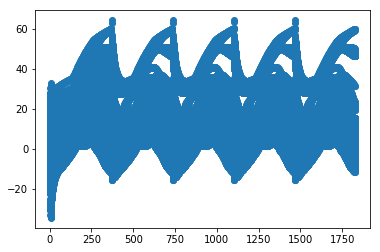

In [222]:
# plt.scatter(timereg[days_pred:,:], np.asarray(predictions))

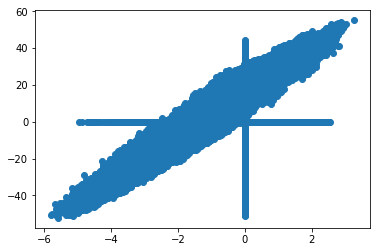

In [82]:
res = model.predict(x_train)#(np.atleast_3d((dataset_super[:,:,0]-mean)/std))
# plt.scatter(x_train[:,:,days_pred-1], res)
# plt.scatter(x_train[:,:,0], res)
plt.scatter(x_train[:,:,0]*mask[:limit,:,0], res*mask[:limit,:,1])

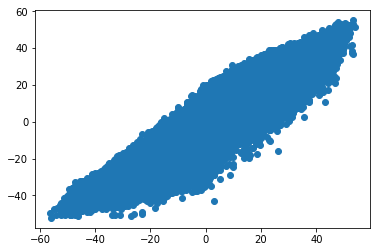

In [83]:
# plt.scatter(np.atleast_3d(dataset_temp[:,:,1]), res)
plt.scatter(labels_train*mask[:limit,:,1], res*mask[:limit,:,1])

In [54]:
# plt.scatter(timereg[days_pred:,:], res)
plt.scatter(time[:,:], res)

TypeError: 'module' object is not subscriptable

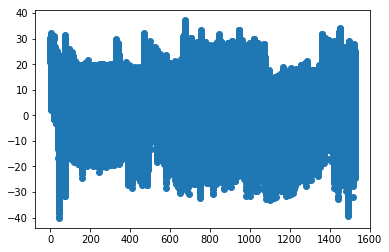

In [226]:
plt.scatter(placereg[days_pred:,:], res)

In [63]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [130]:
res = np.asarray(predictions)

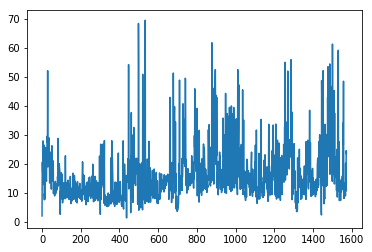

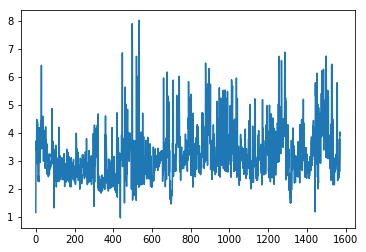

In [65]:
mse_loc = []
mae_loc = []
for i in range(res.shape[1]):
#     mse_loc.append(mse(dataset_temp[:,i,1], res[:,i]))
#     mae_loc.append(mae(dataset_temp[:,i,1], res[:,i]))
plt.plot(mse_loc)
plt.figure()
plt.plot(mae_loc)

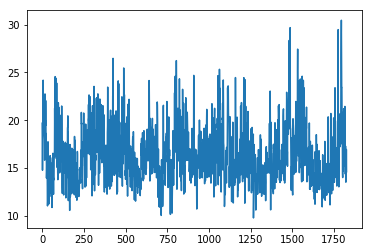

In [61]:
mse_tab = []
for i in range(res.shape[0]):
    mse_tab.append(mse(dataset_temp[i,:,1], res[i,:]))
plt.plot(mse_tab)

In [66]:
arg = np.argmax(mse_tab)

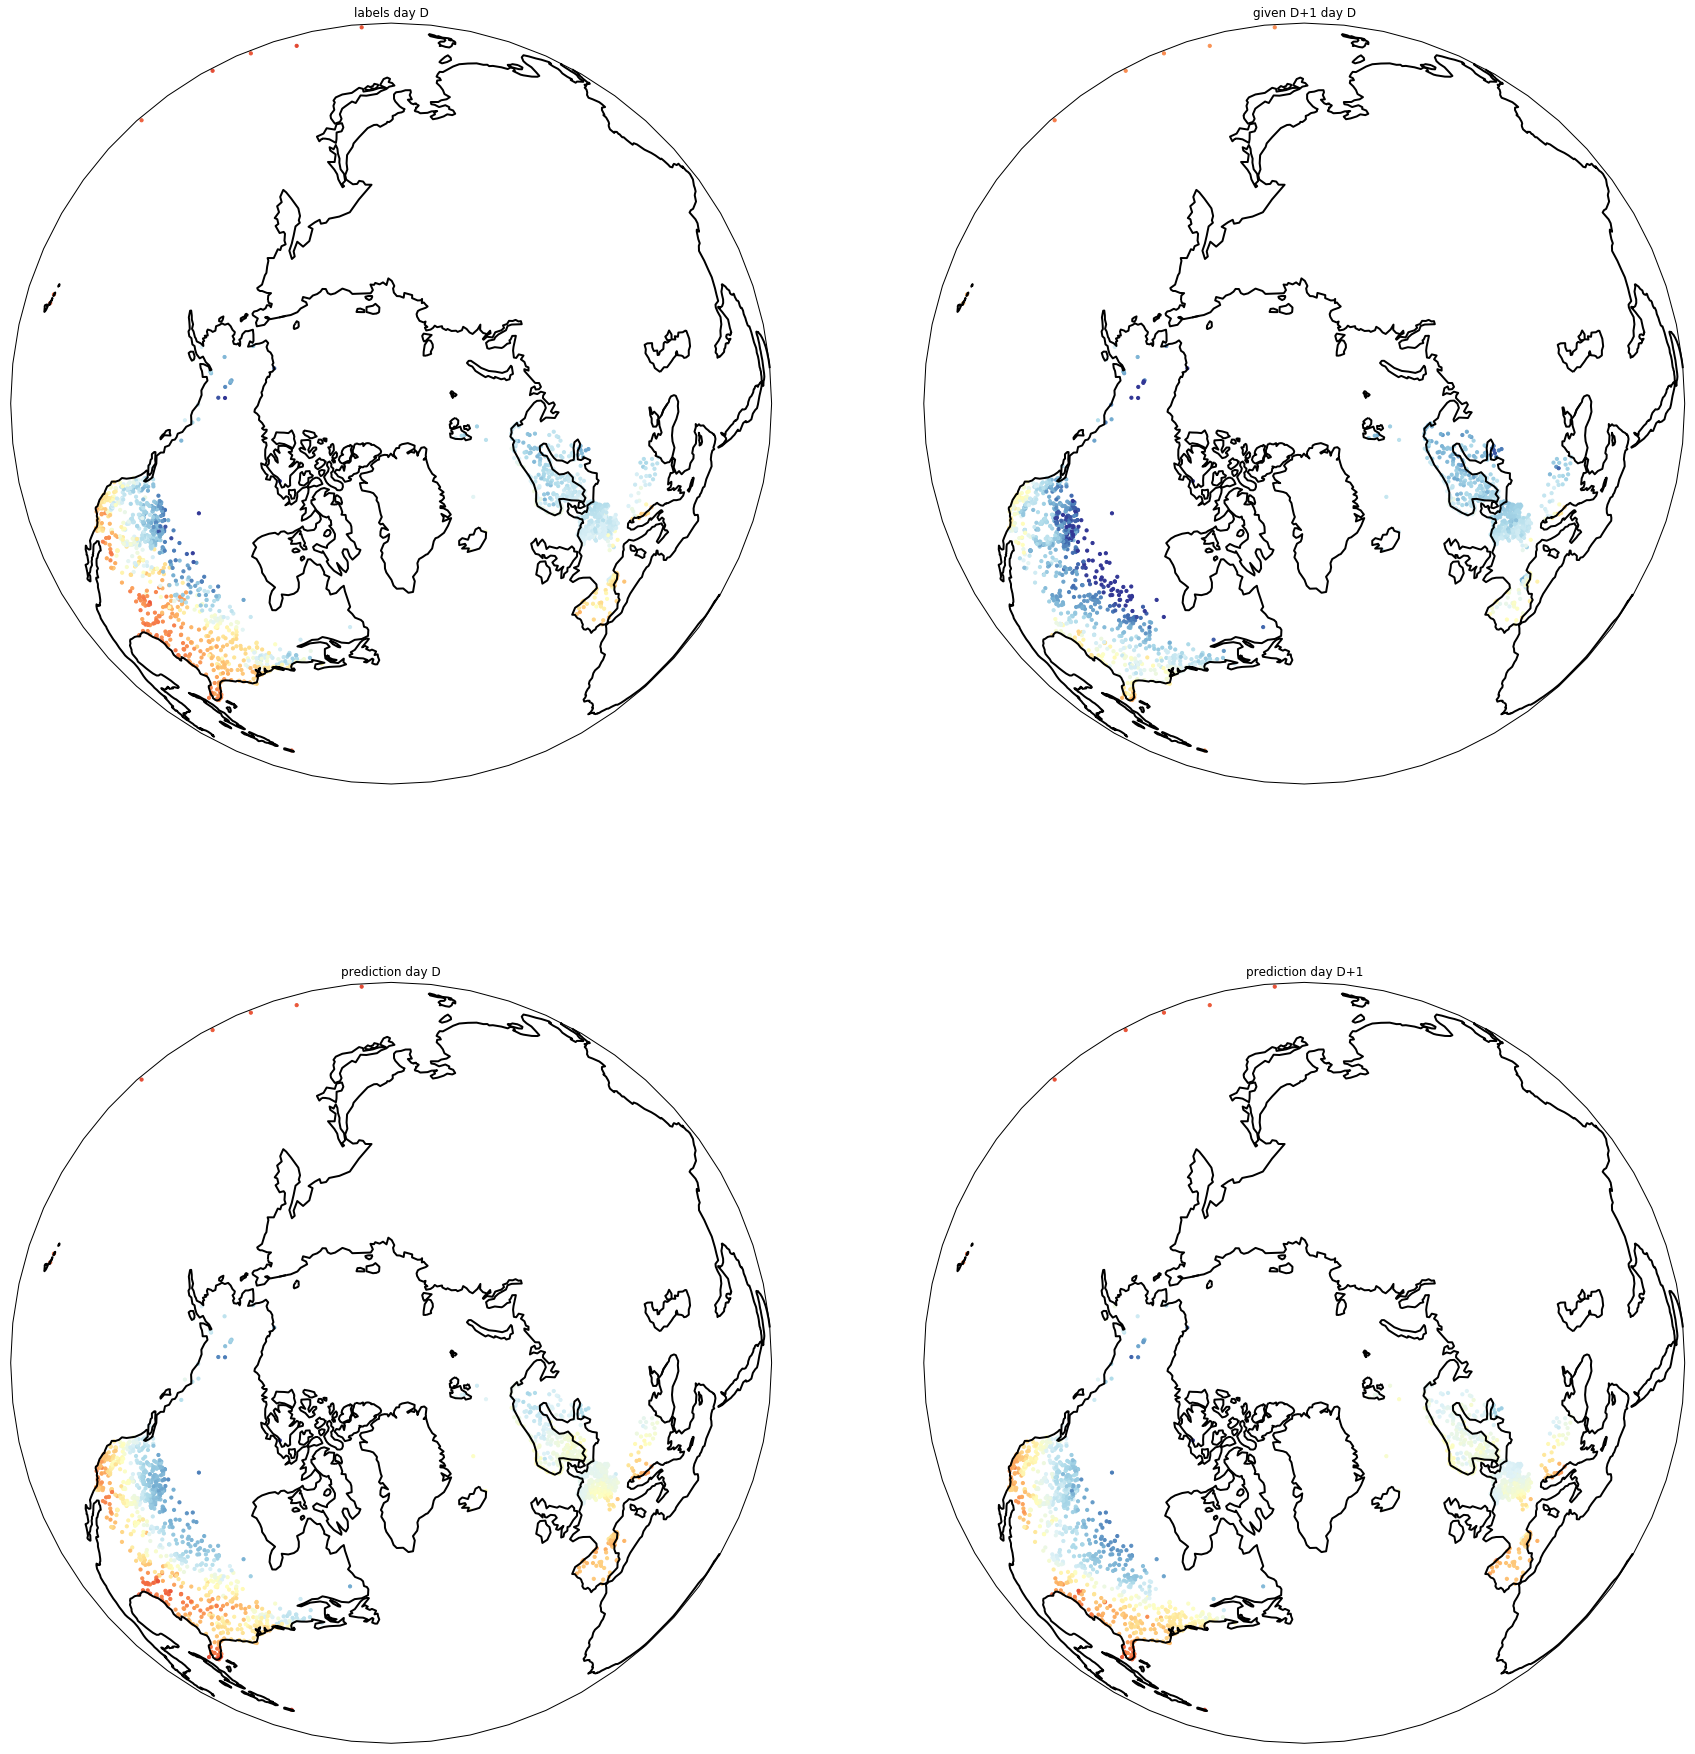

In [68]:
fig = plt.figure(figsize=(30, 50))
ax = fig.add_subplot(3, 2, 1, projection=ccrs.Orthographic(-50, 90))
ax.set_global()
ax.coastlines(linewidth=2)
ax.set_title('labels day D')

zmin, zmax = -20, 40

sc = ax.scatter(lon[keepToo], lat[keepToo], s=10,
                c=np.clip(dataset_temp[arg, :, 1], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
                vmin=zmin, vmax=zmax, alpha=1, transform=ccrs.PlateCarree())

ax = fig.add_subplot(3, 2, 3, projection=ccrs.Orthographic(-50, 90))
ax.set_global()
ax.coastlines(linewidth=2)
ax.set_title('prediction day D')

zmin, zmax = -20, 40

sc = ax.scatter(lon[keepToo], lat[keepToo], s=10,
                c=np.clip(res[arg, :], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
                vmin=zmin, vmax=zmax, alpha=1, transform=ccrs.PlateCarree())

ax = fig.add_subplot(3, 2, 4, projection=ccrs.Orthographic(-50, 90))
ax.set_global()
ax.coastlines(linewidth=2)
ax.set_title('prediction day D+1')

zmin, zmax = -20, 40

sc = ax.scatter(lon[keepToo], lat[keepToo], s=10,
                c=np.clip(res[arg+1, :], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
                vmin=zmin, vmax=zmax, alpha=1, transform=ccrs.PlateCarree())

# ax = fig.add_subplot(3, 2, 5, projection=ccrs.Orthographic(-50, 90))
# ax.set_global()
# ax.coastlines(linewidth=2)
# ax.set_title('given D day D-1')

# zmin, zmax = -20, 40

# sc = ax.scatter(lon[keepToo], lat[keepToo], s=10,
#                 c=np.clip(x_train[arg, :, days_pred-1], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
#                 vmin=zmin, vmax=zmax, alpha=1, transform=ccrs.PlateCarree())

ax = fig.add_subplot(3, 2, 2, projection=ccrs.Orthographic(-50, 90))
ax.set_global()
ax.coastlines(linewidth=2)
ax.set_title('given D+1 day D')

zmin, zmax = -20, 40

sc = ax.scatter(lon[keepToo], lat[keepToo], s=10,
                c=np.clip(dataset_temp[arg+1, :, 0], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
                vmin=zmin, vmax=zmax, alpha=1, transform=ccrs.PlateCarree())

# ax = fig.add_subplot(3, 2, 6, projection=ccrs.Orthographic(-50, 90))
# ax.set_global()
# ax.coastlines(linewidth=2)
# ax.set_title('given D+1 day D-1')

# zmin, zmax = -20, 40

# sc = ax.scatter(lon[keepToo], lat[keepToo], s=10,
#                 c=np.clip(x_train[arg+1, :, days_pred-2], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
#                 vmin=zmin, vmax=zmax, alpha=1, transform=ccrs.PlateCarree())

# pooling the graph

## Normal

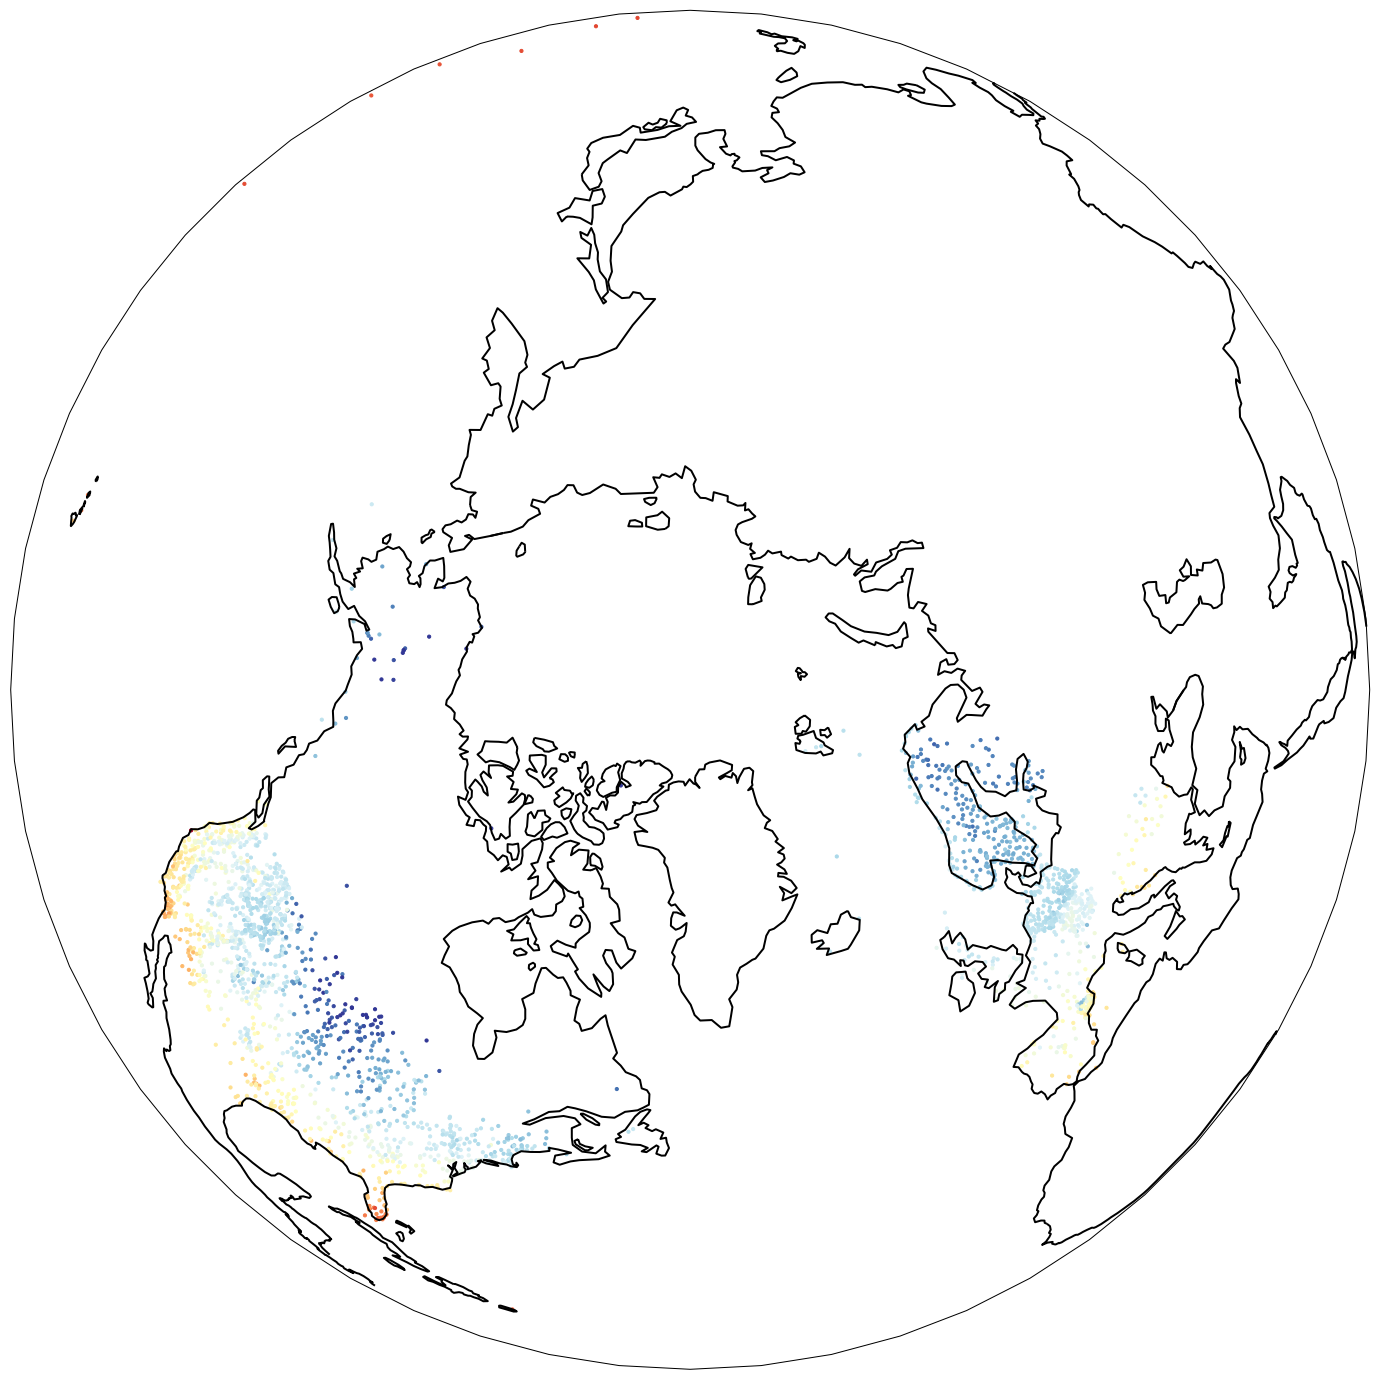

In [40]:
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(-50, 90))
ax.set_global()
ax.coastlines(linewidth=2)

zmin, zmax = -20, 40

sc = ax.scatter(lon[keepToo], lat[keepToo], s=10,
                c=np.clip(full_data[keepToo, 0, 2], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
                vmin=zmin, vmax=zmax, alpha=1, transform=ccrs.PlateCarree())

## area pixel

In [53]:
import healpy as hp

In [133]:
pool = 'max' # in ['max', 'mean', ...]
Nside = 64
theta = lon[keepToo]#np.deg2rad(lon[keepToo])
phi = lat[keepToo]#np.deg2rad(lat[keepToo])
# dataset_temp
pix, weights = hp.get_interp_weights(Nside, theta, phi, nest=True, lonlat=True)
indexes = np.unique(pix)
size = dataset_temp.shape
size = list(size)
size[1] = len(indexes) # hp.nside2npix(Nside)
size = tuple(size)
new_map = np.zeros(size)
# new_map[new_map==0] = hp.UNSEEN
pool_fun = getattr(np, pool)
for i, index in enumerate(indexes):
    pl = np.where(pix==index)
    wght = weights[pl]
    data_p = wght[np.newaxis,:,np.newaxis] * dataset_temp[:, pl[1], :]
    new_map[:,i,:] = pool_fun(data_p, axis=1)
new_lon, new_lat = hp.pix2ang(Nside, indexes, nest=True, lonlat=True)

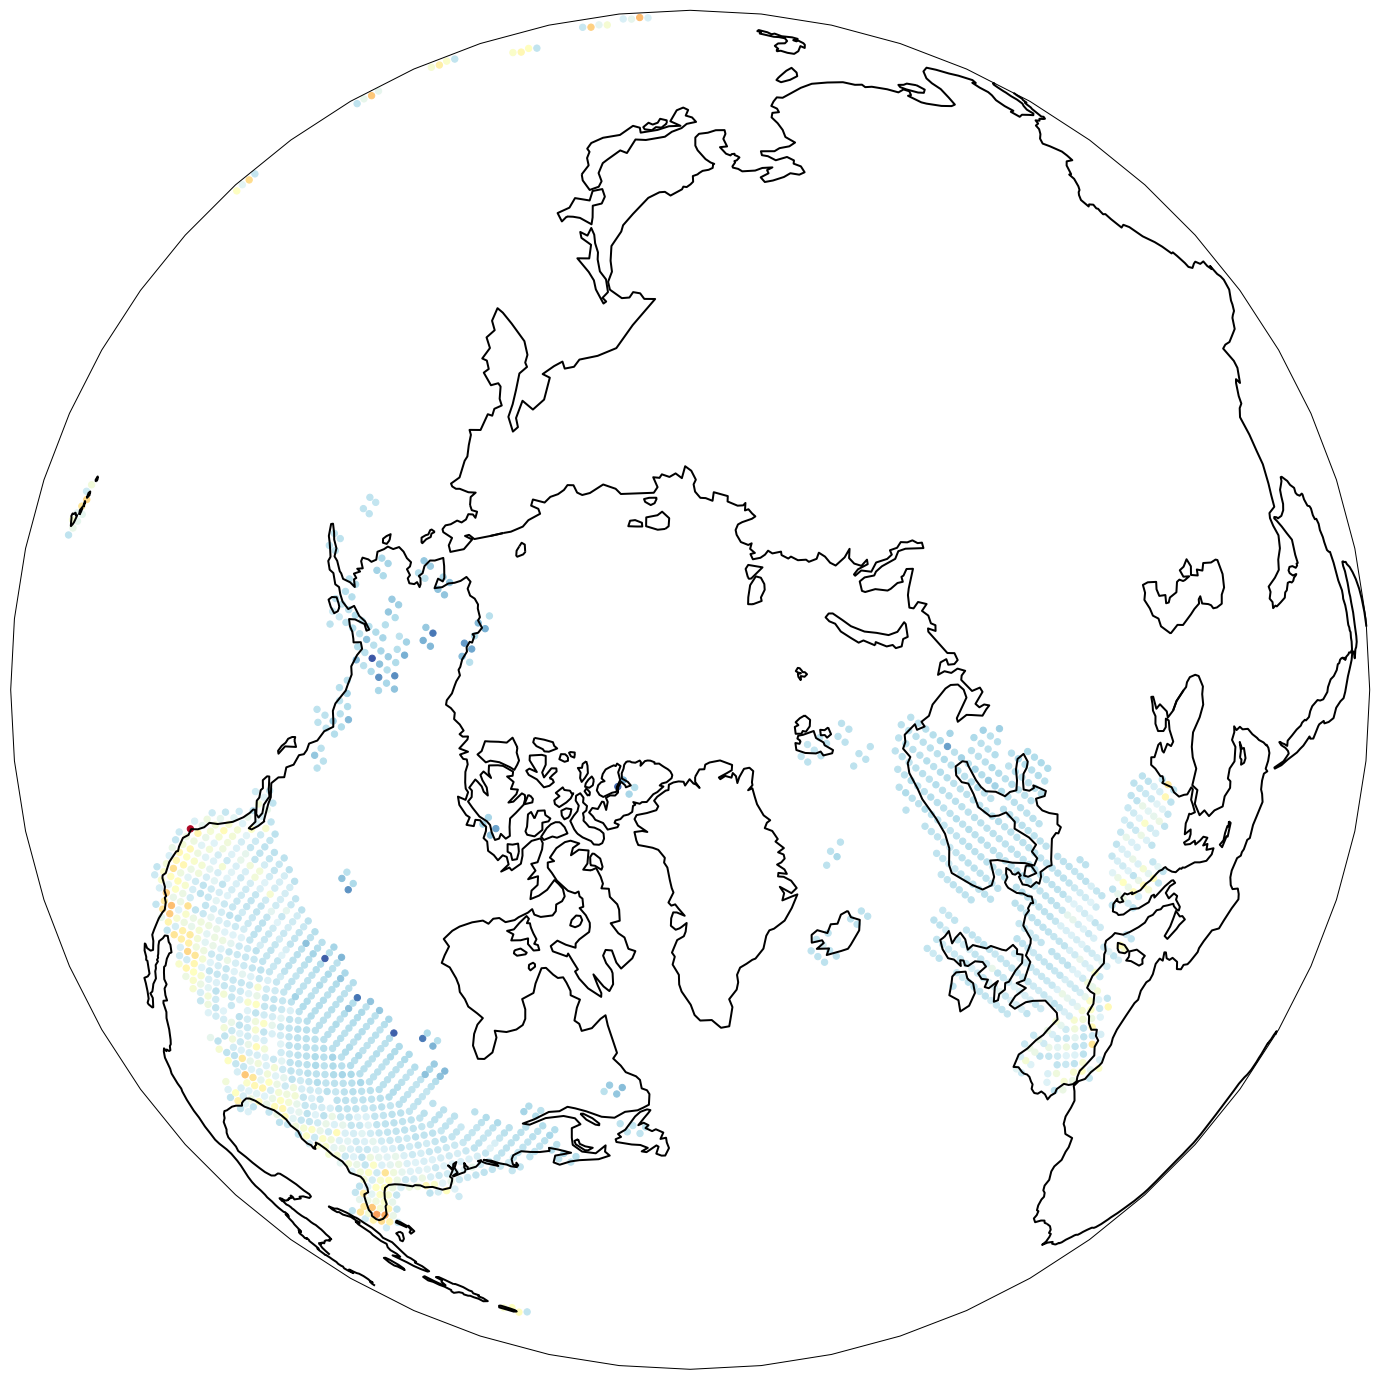

In [134]:
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(-50, 90))
ax.set_global()
ax.coastlines(linewidth=2)

zmin, zmax = -20, 40

sc = ax.scatter(new_lon, new_lat, s=40,
                c=np.clip(new_map[0, :, 1], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
                vmin=zmin, vmax=zmax, alpha=1, transform=ccrs.PlateCarree())

## NNeighbours

### use knn graph

Separate in cluser, and merge them???

/home/gusset/.local/lib/python3.6/site-packages/pygsp/graphs/graph.py:522: RuntimeWarning: divide by zero encountered in power
  d = np.power(self.dw, -0.5)


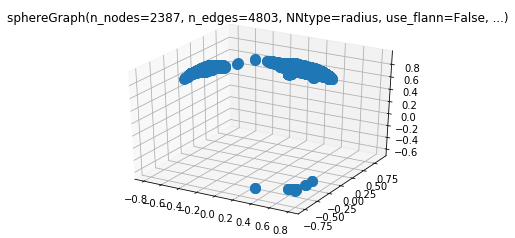

In [172]:
k = 2
NCluster = dataset_temp.shape[1]//k
gTemp_1 = sphereGraph(lon[keepToo], lat[keepToo], 3*k, rad=False)
gTemp_1.plot()
gTemp_1.compute_laplacian('normalized')
gTemp_1.compute_fourier_basis(n_eigenvectors=NCluster)

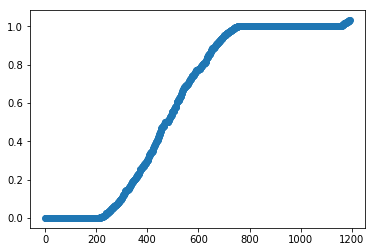

In [173]:
plt.plot(gTemp_1.e[:NCluster], 'o')

In [174]:
from sklearn.cluster import KMeans
eig_vectors = gTemp_1.U[:,1:NCluster+1]
clusters = KMeans(n_clusters=NCluster).fit_predict(eig_vectors)

In [175]:
clust_lon, clust_lat = np.empty(NCluster), np.empty(NCluster)
size = dataset_temp.shape
size = list(size)
size[1] = NCluster
size = tuple(size)
new_map = np.zeros(size)
pool = 'max'
pool_fun = getattr(np, pool)
for i in range(NCluster):
    indices = np.where(clusters==i)[0]
    clust_lon[i] = lon[keepToo][indices].mean()
    clust_lat[i] = lat[keepToo][indices].mean()
    data_p = dataset_temp[:, indices, :]
    new_map[:,i,:] = pool_fun(data_p, axis=1)

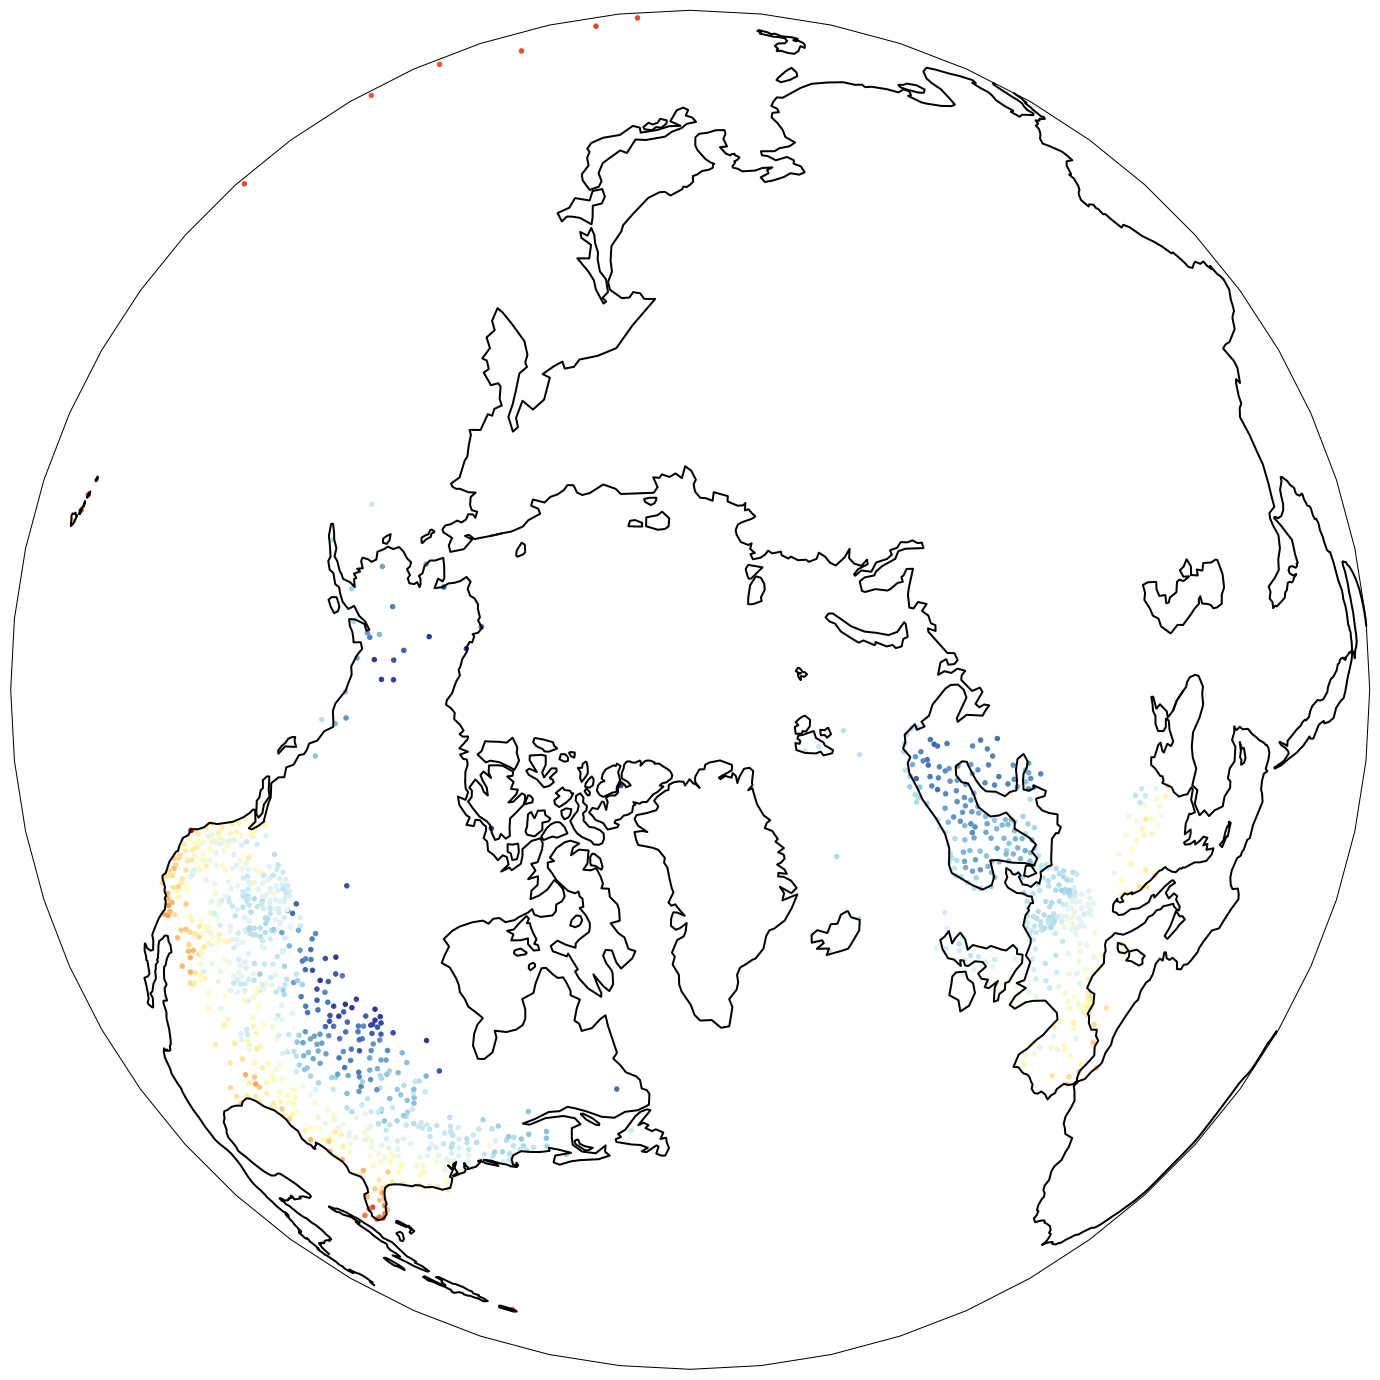

In [176]:
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(-50, 90))
ax.set_global()
ax.coastlines(linewidth=2)

zmin, zmax = -20, 40

sc = ax.scatter(clust_lon, clust_lat, s=20,
                c=np.clip(new_map[0,:,1], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
                vmin=zmin, vmax=zmax, alpha=1, transform=ccrs.PlateCarree())

/home/gusset/.local/lib/python3.6/site-packages/pygsp/graphs/graph.py:522: RuntimeWarning: divide by zero encountered in power
  d = np.power(self.dw, -0.5)


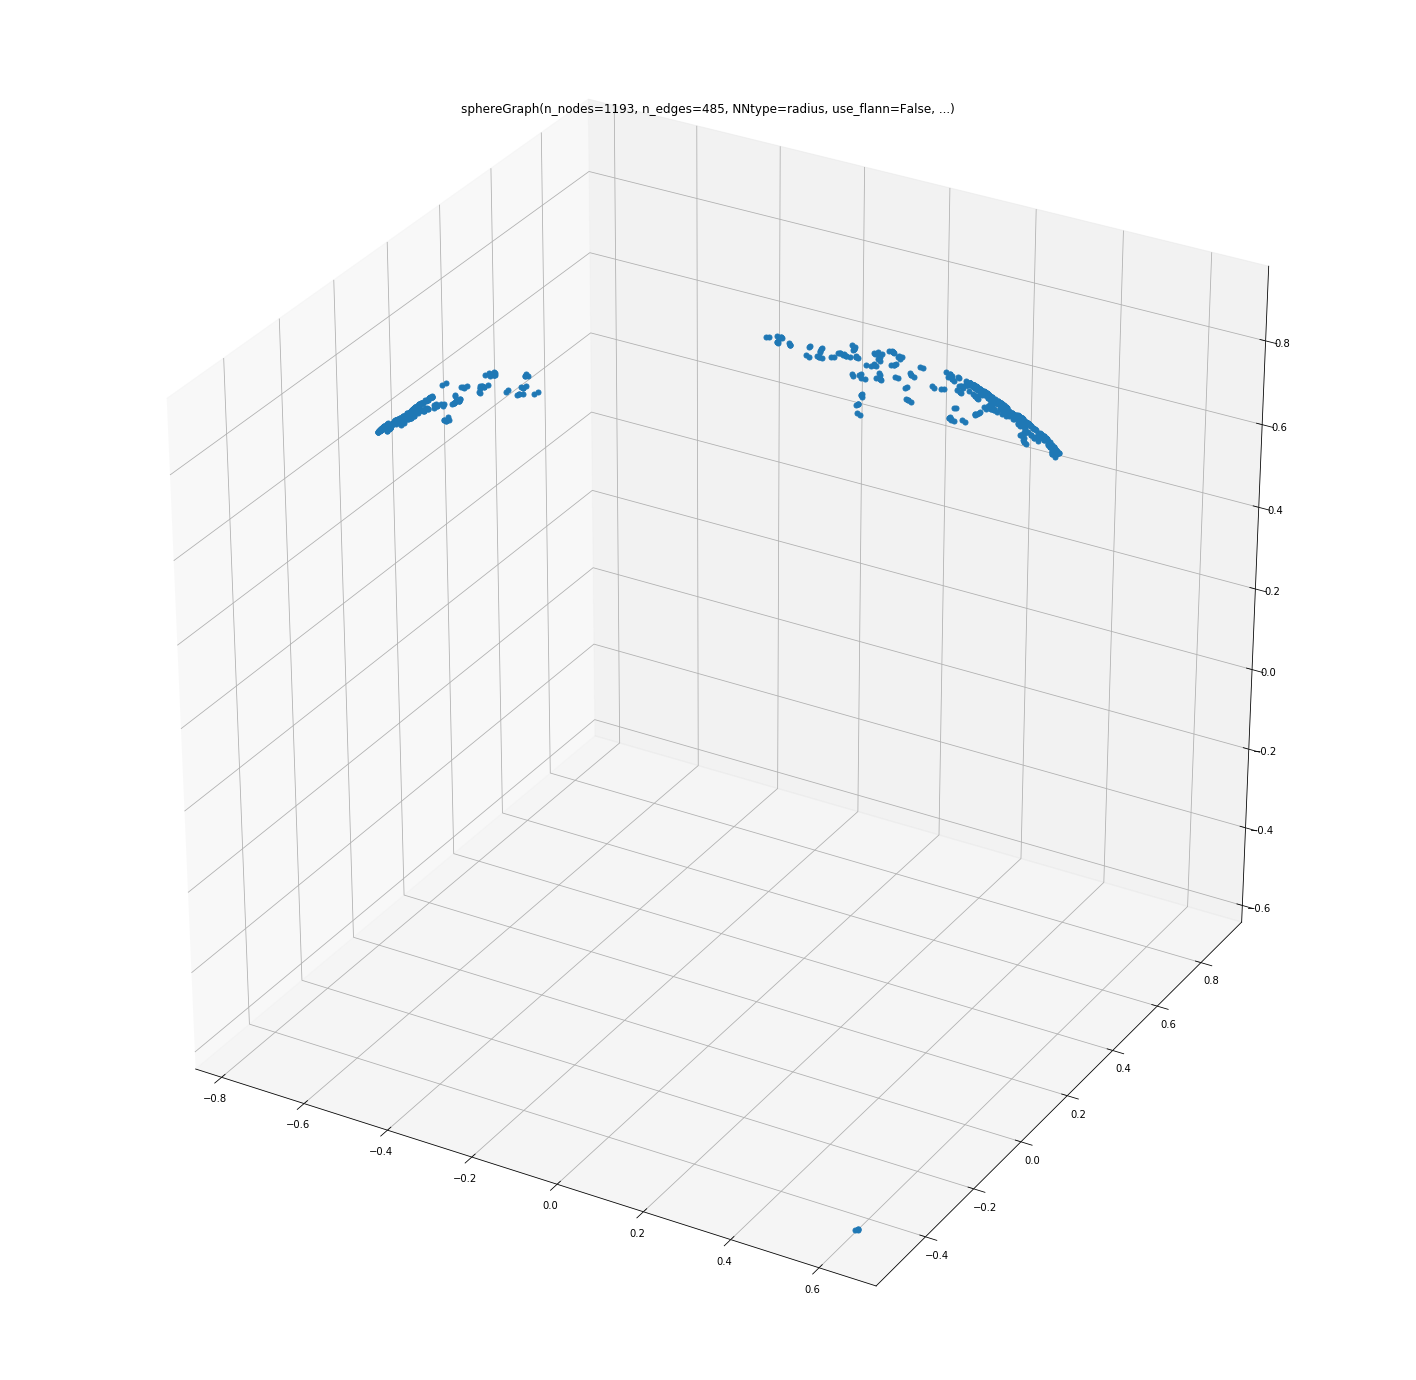

In [177]:
NCluster_2 = new_map.shape[1]//k
gTemp_2 = sphereGraph(clust_lon, clust_lat, 3*k, rad=False)
fig = plt.figure(figsize=(25,25))
axes = fig.add_subplot(111, projection='3d')
gTemp_2.plot(vertex_size=50, ax=axes)
gTemp_2.compute_laplacian('normalized')
gTemp_2.compute_fourier_basis(n_eigenvectors=NCluster_2)

In [178]:
eig_vectors2 = gTemp_2.U[:,1:NCluster_2+1]
clusters2 = KMeans(n_clusters=NCluster_2).fit_predict(eig_vectors2)

In [179]:
clust_lon2, clust_lat2 = np.empty(NCluster_2), np.empty(NCluster_2)
size = new_map.shape
size = list(size)
size[1] = NCluster_2
size = tuple(size)
new_map2 = np.zeros(size)
pool = 'max'
pool_fun = getattr(np, pool)
for i in range(NCluster_2):
    indices = np.where(clusters2==i)[0]
    clust_lon2[i] = clust_lon[indices].mean()
    clust_lat2[i] = clust_lat[indices].mean()
    data_p = new_map[:, indices, :]
    new_map2[:,i,:] = pool_fun(data_p, axis=1)

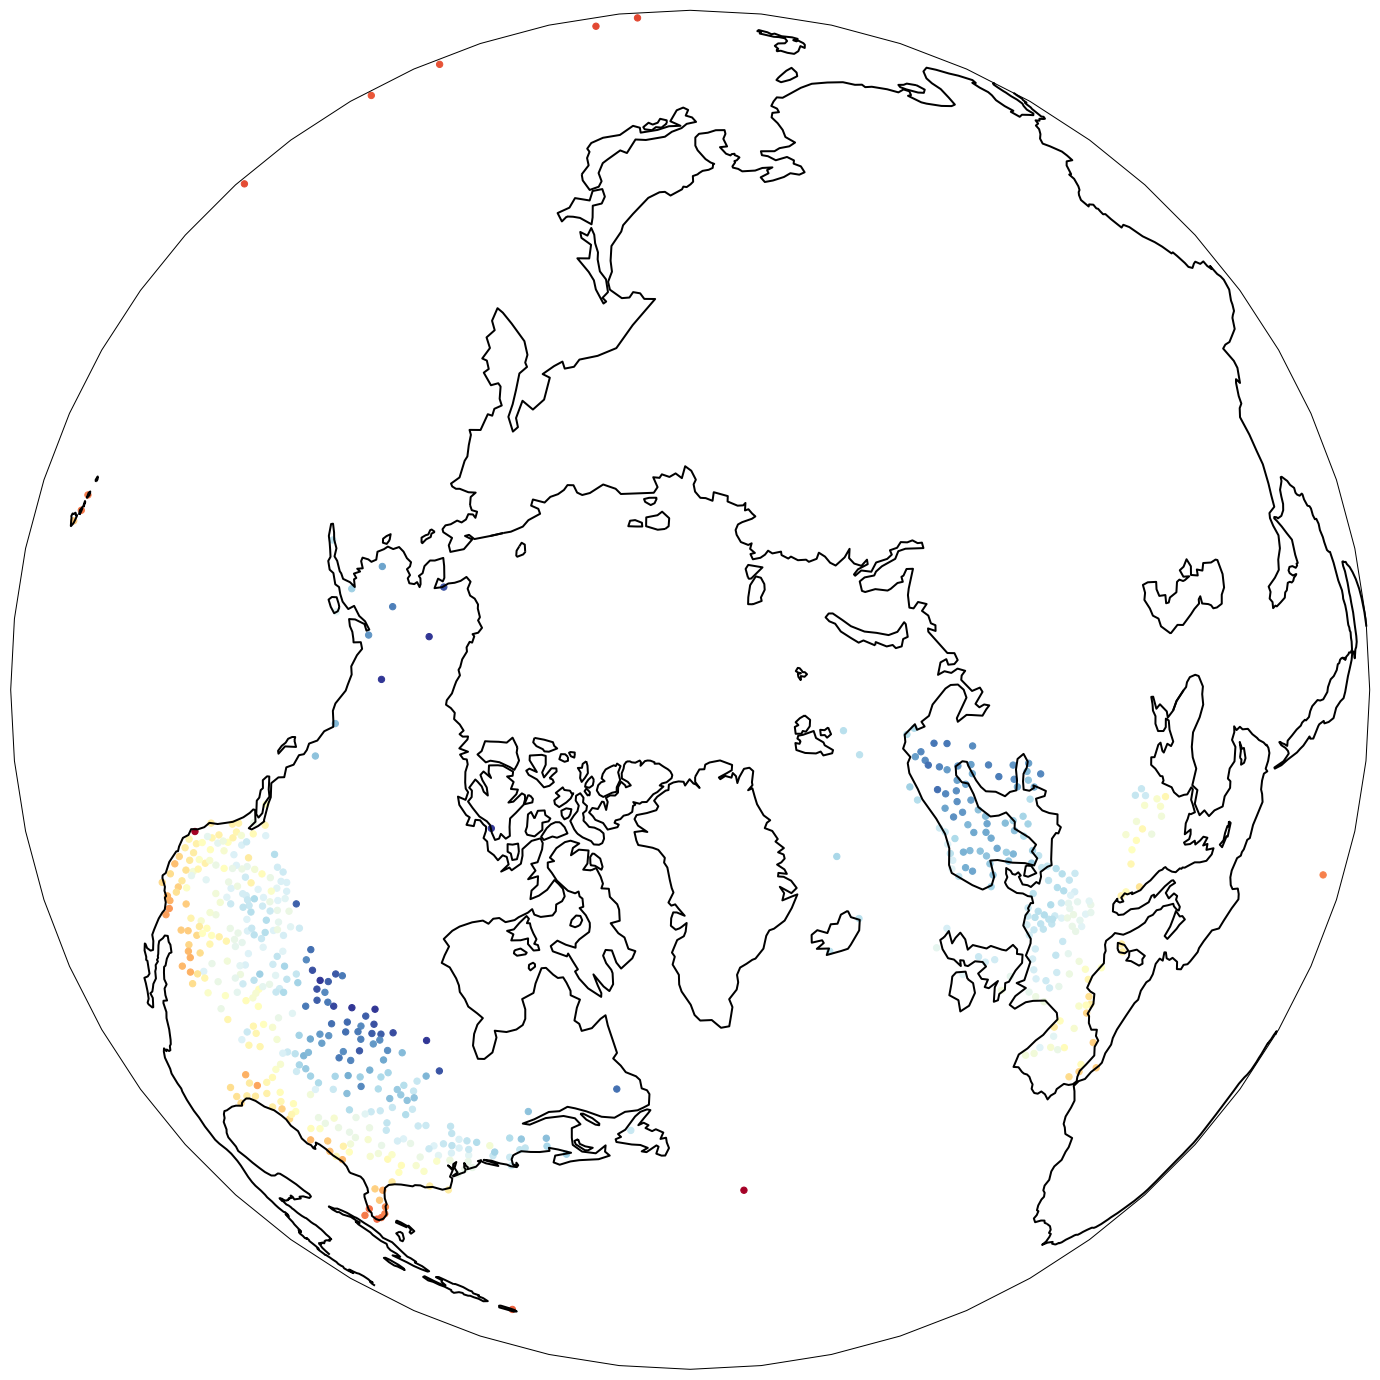

In [180]:
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(-50, 90))
ax.set_global()
ax.coastlines(linewidth=2)

zmin, zmax = -20, 40

sc = ax.scatter(clust_lon2, clust_lat2, s=40,
                c=np.clip(new_map2[0,:,1], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
                vmin=zmin, vmax=zmax, alpha=1, transform=ccrs.PlateCarree())

# Misc

In [193]:
full_data2 = np.stack(datas, axis=2)
full_data2 = full_data2[:, valid_days_list[0], :]

n_days = full_data2.shape[1]

assert n_stations == full_data2.shape[0]

print(f'n_stations: {n_stations}, n_days: {n_days}')

n_stations: 56520, n_days: 2922


In [201]:
print(sum(~np.isnan(full_data2[:,:,0]).any(axis=1)))
print(sum(~np.isnan(full_data2[:,:,1]).any(axis=1)))
print(sum(~np.isnan(full_data2[:,:,2]).any(axis=1)))
print(sum(~np.isnan(full_data2[:,:,3]).any(axis=1)))

2509
1269
1328
338


In [204]:
set1=set(np.where(~np.isnan(full_data2[:,:,0]).any(axis=1))[0])
set2=set(np.where(~np.isnan(full_data2[:,:,1]).any(axis=1))[0])
set3=set(np.where(~np.isnan(full_data2[:,:,2]).any(axis=1))[0])
set4=set(np.where(~np.isnan(full_data2[:,:,3]).any(axis=1))[0])
print(len(set1.intersection(set2, set3, set4)))
print(len(set2.intersection(set3)))

235
1198


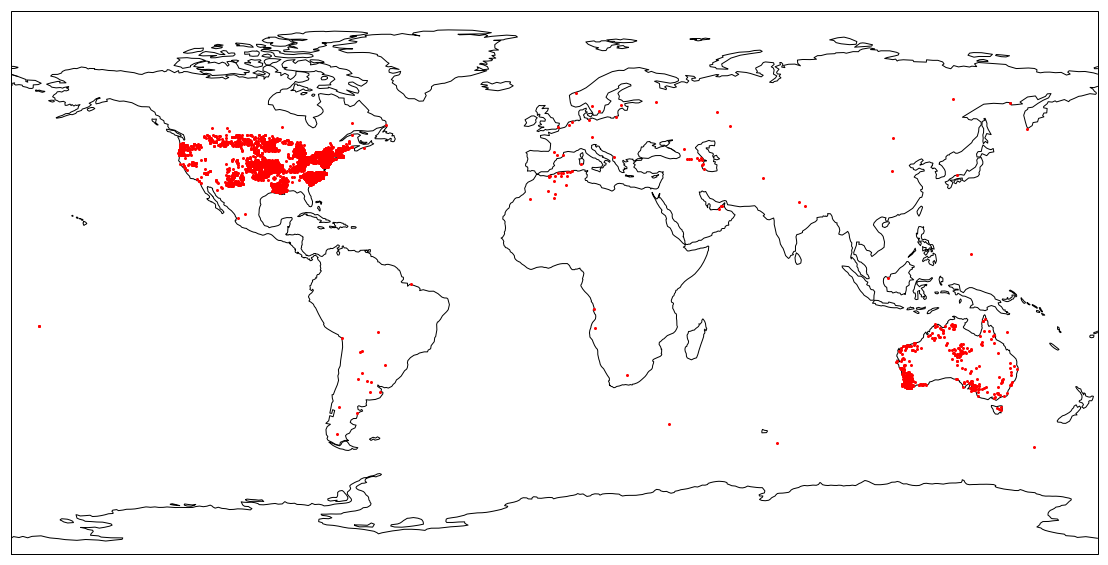

In [296]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.plot(lon[plop], lat[plop], 'or', marker='o', markerfacecolor='r', markersize=2)

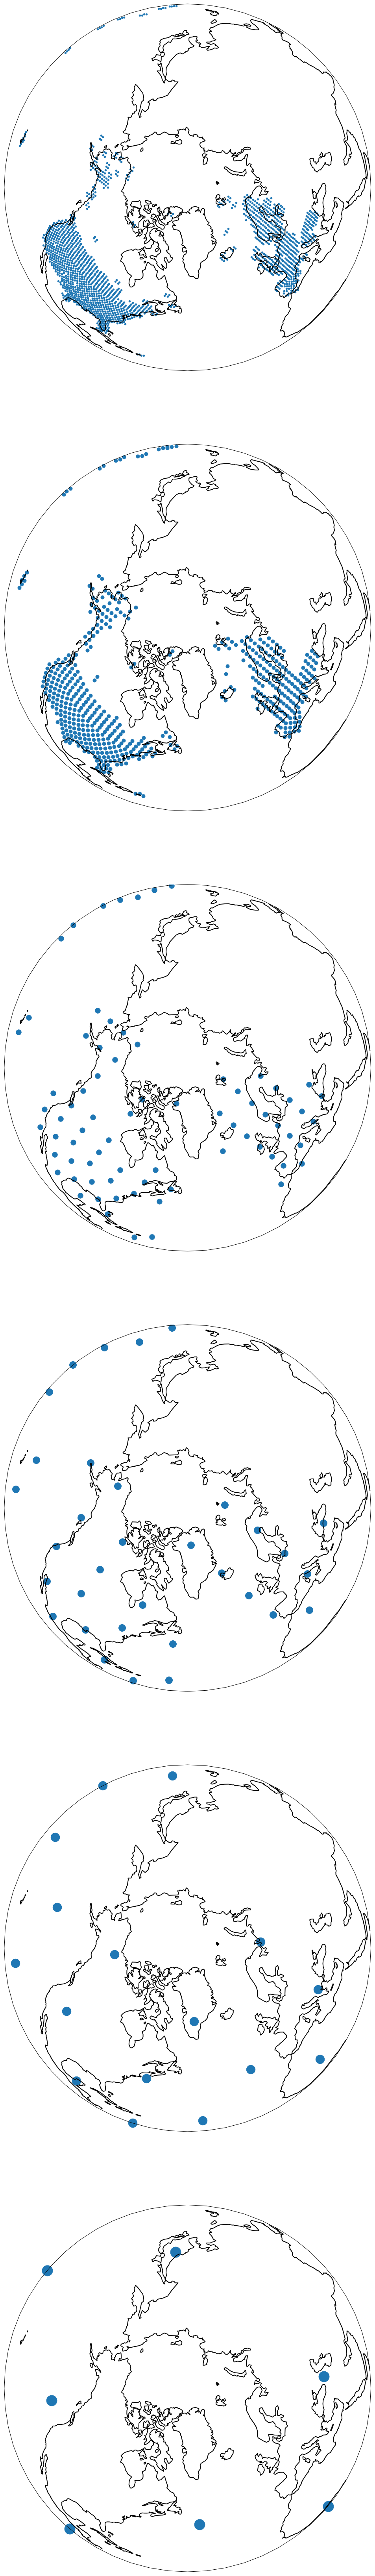

In [308]:
from deepsphere.utils import ds_index
Nsides = [64, 32, 8, 4, 2, 1]
ids = ds_index(indexes, Nsides)
fig = plt.figure(figsize=(120, 120))



for i, index in enumerate(ids):
    ax = fig.add_subplot(6, 1, i+1, projection=ccrs.Orthographic(-50, 90))
    ax.set_global()
    ax.coastlines(linewidth=2)
    new_lon, new_lat = hp.pix2ang(Nsides[i], index, nest=True, lonlat=True)
    sc = ax.scatter(new_lon,new_lat, s=20*(i+1)**2, alpha=1, transform=ccrs.PlateCarree())